# Intro and prep

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import pandas as pd
import seaborn as sns
import datetime
import geopandas as gpd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition
import pickle
import rasterio
import cv2
import warnings

prov = ['AB','BC']
abc = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)', 'm)', 'n)', 'o)', 'p)', 'q)', 'r)', 's)']
first_days_of_month = [0,31,59,90,120,151,181,212,243,273,304,334]
month_water_year = np.array([10,11,12,1,2,3,4,5,6,7,8,9]) - 1
months_str = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']

warnings.filterwarnings('ignore')

In [2]:
def plot_prov_ax(prov, ax, linewidth = 1):

  #load shapefile of provincial boundaries
  provshapes_filename = '/Users/samanderson/repos/heatwave_obs/Data/PROVINCE.SHP'
  provshapes = gpd.read_file(provshapes_filename)

  #create list of all prov/territorial abbreviations
  prov_abbreviations = [
                        'AB',
                        'SK',
                        'MB',
                        'NL',
                        'PE',
                        'NS',
                        'NT',
                        'NU',
                        'ON',
                        'NB',
                        'YT',
                        'BC',
                        'QC'
                      ]

  #if wanting to plot all borders
  if prov == 'all':
    prov = prov_abbreviations

  #loop through each input province/territory and plot borders
  for pv in prov:

    #polygons of this province/territory
    prov_poly = provshapes['geometry'][prov_abbreviations.index(pv)]

    #some jurisdictions have multiple polygones from lakes/islands/etc (e.g. BC)
    if prov_poly.geom_type == 'Polygon': #if only one polygon to plot

      lonBorder,latBorder = prov_poly.exterior.coords.xy 
      ax.plot(lonBorder,latBorder,'k', linewidth = linewidth)

    else: #if multiply polygons in shape to plot

      for ind in range(len(prov_poly.geoms)): 
        lonBorder_segment,latBorder_segment = prov_poly.geoms[ind].exterior.coords.xy 
        ax.plot(lonBorder_segment,latBorder_segment,'k', linewidth = linewidth)
        
def hillshade(array,azimuth,angle_altitude): 
    
    #from: https://www.neonscience.org/resources/learning-hub/tutorials/create-hillshade-py
    
    azimuth = 360.0 - azimuth 
    
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi/180.
    altituderad = angle_altitude*np.pi/180.
 
    shaded = np.sin(altituderad)*np.sin(slope) + np.cos(altituderad)*np.cos(slope)*np.cos((azimuthrad - np.pi/2.) - aspect)
    
    return 255*(shaded + 1)/2

# Load data

In [3]:
#create unified dataframe from yearly weather station data

dir_data = '/Users/samanderson/repos/heatwave_obs/Data/'

sites = ['Banff',
         'Columbia_Golden',
         'Similkameen_Princeton',
         'Chilliwack',
         'Pemberton',
         'Fort_St_James']

Nsites = len(sites)

dirs_data = [dir_data + site + '/' for site in sites]

data_start_years = np.array([1910,
                    1903,
                    1936,
                    1911,
                    1912,
                    1930]) 
data_end_years = np.array([2022,
                  2018,
                  2017,
                  2014,
                  2022,
                  2019])

Nyears_sites = data_end_years - data_start_years #not +1 because of water year adjustment from calendar year

df_sites = pd.DataFrame(
    {
        'Nyears' : Nyears_sites,
        'Year_start' : data_start_years,
        'Year_end' : data_end_years
    },
    index = sites
)

dir_ws_data_start_inds = [3,2,1,1,1,1] #index in each site folder (weather station)
dir_flow_data_start_inds = [1,1,0,0,0,0] #index in each site folder (stream gauge station)
dfs_weather = []
dfs_flow = []

#open each site folder, open/process weather/flow data
for kk_dir, dir_data in enumerate(dirs_data):

    site = sites[kk_dir]
    
    #weather data
    filenames = sorted(os.listdir(dir_data))[dir_ws_data_start_inds[kk_dir]:-1]
    if kk_dir == 0:
        filenames = filenames[28:] + filenames[:28] #resort: 1909 - 1994; 1995 - 2023
    df_weather = pd.concat([pd.read_csv(dir_data + filename) for filename in filenames]) #concatenate all into single dataframe
    df_weather = df_weather.set_index('Date/Time')
    df_weather.index = pd.DatetimeIndex(df_weather.index)
    idx = pd.date_range('01-01-'+str(data_start_years[kk_dir]), '12-31-'+str(data_end_years[kk_dir]))
    df_weather = df_weather.reindex(idx, fill_value=np.NaN) #fill missing data with NaN
    
    ### BELOW FOR WATER DAY OF YEAR
    
    df_weather['Day_of_year'] = ((df_weather.index.dayofyear.values-1)+92) % 365
    df_weather = df_weather.loc[str(data_start_years[kk_dir]) + '-10-01':str(data_end_years[kk_dir]) + '-09-30']
    
    water_years = np.zeros(len(df_weather))
    for kk, index in enumerate(df_weather.index):
        if df_weather['Month'].iloc[kk] > 9:
            water_years[kk] = index.year + 1
        else:
            water_years[kk] = index.year
    df_weather['Year'] = water_years
    
    ###
    
    dfs_weather.append(df_weather)

    #streamflow data
    filename = sorted(os.listdir(dir_data))[dir_flow_data_start_inds[kk_dir]]
    df_flow = pd.read_csv(dir_data + filename, header = 1)
    df_flow = df_flow.set_index('Date')
    df_flow.index = pd.DatetimeIndex(df_flow.index) 
    df_flow = df_flow[df_flow['PARAM']==1] #only select where PARAM = 1 (flow); PARAM = 2 is level
    df_flow = df_flow.reindex(idx, fill_value=np.NaN)
    df_flow['Year'] = df_flow.index.year
    df_flow['Month'] = df_flow.index.month
    
    ### BELOW FOR WATER DAY OF YEAR
    
    df_flow['Day_of_year'] = ((df_flow.index.dayofyear.values-1)+92) % 365
    df_flow = df_flow.loc[str(data_start_years[kk_dir]) + '-10-01':str(data_end_years[kk_dir]) + '-09-30']
    
    water_years = np.zeros(len(df_flow))
    for kk, index in enumerate(df_flow.index):
        if df_flow['Month'].iloc[kk] > 9:
            water_years[kk] = index.year + 1
        else:
            water_years[kk] = index.year
    df_flow['Year'] = water_years

    ###
    
    dfs_flow.append(df_flow)
    
df_longterm = pd.read_csv('Data/RHBN_longterm_stations.csv')
df_sites['Weather_stations'] = dfs_weather
df_sites['Streamflow'] = dfs_flow
df_sites['Longitude'] = df_longterm['Longitude'].values[[0,1,4,3,2,5]]
df_sites['Latitude'] = df_longterm['Latitude'].values[[0,1,4,3,2,5]]

In [4]:
dfs_flow[0].head()

ID  PARAM  Value  SYM    Year  Month  Day_of_year
1910-10-01  05BB001    1.0   30.0  NaN  1911.0     10            0
1910-10-02  05BB001    1.0   30.0  NaN  1911.0     10            1
1910-10-03  05BB001    1.0   30.0  NaN  1911.0     10            2
1910-10-04  05BB001    1.0   28.9  NaN  1911.0     10            3
1910-10-05  05BB001    1.0   27.6  NaN  1911.0     10            4

In [5]:
dfs_weather[0].head()

Longitude (x)  Latitude (y) Station Name  Climate ID    Year  \
1910-10-01        -115.57         51.18        BANFF   3050520.0  1911.0   
1910-10-02        -115.57         51.18        BANFF   3050520.0  1911.0   
1910-10-03        -115.57         51.18        BANFF   3050520.0  1911.0   
1910-10-04        -115.57         51.18        BANFF   3050520.0  1911.0   
1910-10-05        -115.57         51.18        BANFF   3050520.0  1911.0   

            Month  Day  Data Quality  Max Temp (°C) Max Temp Flag  ...  \
1910-10-01   10.0  1.0           NaN            8.9           NaN  ...   
1910-10-02   10.0  2.0           NaN            7.8           NaN  ...   
1910-10-03   10.0  3.0           NaN            6.7           NaN  ...   
1910-10-04   10.0  4.0           NaN            8.3           NaN  ...   
1910-10-05   10.0  5.0           NaN           10.6           NaN  ...   

            Total Snow Flag Total Precip (mm)  Total Precip Flag  \
1910-10-01              NaN               0.0                  T   
1910-10-02              NaN               0.0                NaN   
1910-10-03              NaN               2.0                NaN   
1910-10-04              NaN               2.8                NaN   
1910-10-05              NaN               0.0                NaN   

           Snow on Grnd (cm)  Snow on Grnd Flag Dir of Max Gust (10s deg)  \
1910-10-01               NaN                NaN                       NaN   
1910-10-02               NaN                NaN                       NaN   
1910-10-03               NaN                NaN                       NaN   
1910-10-04               NaN                NaN                       NaN   
1910-10-05               NaN                NaN                       NaN   

            Dir of Max Gust Flag Spd of Max Gust (km/h)  Spd of Max Gust Flag  \
1910-10-01                   NaN                    NaN                   NaN   
1910-10-02                   NaN                    NaN                   NaN   
1910-10-03                   NaN                    NaN                   NaN   
1910-10-04                   NaN                    NaN                   NaN   
1910-10-05                   NaN                    NaN                   NaN   

           Day_of_year  
1910-10-01           0  
1910-10-02           1  
1910-10-03           2  
1910-10-04           3  
1910-10-05           4  

[5 rows x 31 columns]

In [6]:
df_sites

Nyears  Year_start  Year_end  \
Banff                     112        1910      2022   
Columbia_Golden           115        1903      2018   
Similkameen_Princeton      81        1936      2017   
Chilliwack                103        1911      2014   
Pemberton                 110        1912      2022   
Fort_St_James              89        1930      2019   

                                                        Weather_stations  \
Banff                              Longitude (x)  Latitude (y) Statio...   
Columbia_Golden                    Longitude (x)  Latitude (y) Statio...   
Similkameen_Princeton              Longitude (x)  Latitude (y) Statio...   
Chilliwack                         Longitude (x)  Latitude (y) Statio...   
Pemberton                          Longitude (x)  Latitude (y)       ...   
Fort_St_James                      Longitude (x)  Latitude (y)   Stat...   

                                                              Streamflow  \
Banff                                   ID  PARAM  Value  SYM    Year...   
Columbia_Golden                         ID  PARAM  Value    Year  Mon...   
Similkameen_Princeton                   ID  PARAM  Value  SYM    Year...   
Chilliwack                              ID  PARAM  Value  SYM    Year...   
Pemberton                           ID  PARAM  Value  SYM    Year  Mo...   
Fort_St_James                           ID  PARAM  Value  SYM    Year...   

                       Longitude  Latitude  
Banff                   -115.572   51.1722  
Columbia_Golden         -116.913   51.2436  
Similkameen_Princeton   -120.504   49.4597  
Chilliwack              -122.800   50.3360  
Pemberton               -124.271   54.4169  
Fort_St_James           -121.967   49.0974

# Weather / flow summary

In [67]:
#calculate weather/flow summary statistics for each study site

p1 = 2.5  #2-sigma lower percentile
p2 = 16   #1-sigma lower percentile
p3 = 84   #1-sigma upper percentile
p4 = 97.5 #2-sigma upper percentile

#initialize all arrays
Tmean_mean = np.zeros((Nsites,365)) #mean temp
Tmean_p1 = np.zeros((Nsites,365))
Tmean_p2 = np.zeros((Nsites,365))
Tmean_p3 = np.zeros((Nsites,365))
Tmean_p4 = np.zeros((Nsites,365))

Tx_mean = np.zeros((Nsites,365)) #max temp
Tx_p1 = np.zeros((Nsites,365))
Tx_p2 = np.zeros((Nsites,365))
Tx_p3 = np.zeros((Nsites,365))
Tx_p4 = np.zeros((Nsites,365))

Tn_mean = np.zeros((Nsites,365)) #min temp
Tn_p1 = np.zeros((Nsites,365))
Tn_p2 = np.zeros((Nsites,365))
Tn_p3 = np.zeros((Nsites,365))
Tn_p4 = np.zeros((Nsites,365))

P_mean = np.zeros((Nsites,365)) #precip (total)
P_p1 = np.zeros((Nsites,365))
P_p2 = np.zeros((Nsites,365))
P_p3 = np.zeros((Nsites,365))
P_p4 = np.zeros((Nsites,365))

Psnow_mean = np.zeros((Nsites,365)) #precip (snow)
Psnow_p1 = np.zeros((Nsites,365))
Psnow_p2 = np.zeros((Nsites,365))
Psnow_p3 = np.zeros((Nsites,365))
Psnow_p4 = np.zeros((Nsites,365))

Prain_mean = np.zeros((Nsites,365)) #precip (rain)
Prain_p1 = np.zeros((Nsites,365))
Prain_p2 = np.zeros((Nsites,365))
Prain_p3 = np.zeros((Nsites,365))
Prain_p4 = np.zeros((Nsites,365))

Q_mean = np.zeros((Nsites,365)) #streamflow
Q_p1 = np.zeros((Nsites,365))
Q_p2 = np.zeros((Nsites,365))
Q_p3 = np.zeros((Nsites,365))
Q_p4 = np.zeros((Nsites,365))

Tmean_90 = np.zeros((Nsites,365)) #percentiles
Tx_90 = np.zeros((Nsites,365))
Tn_90 = np.zeros((Nsites,365))
Tmean_50 = np.zeros((Nsites,365))
P_running = [[] for kk in range(Nsites)]

#loop through each site and calculate stats
for kk_site, site in enumerate(sites):
    
    df_weather = df_sites['Weather_stations'][site]
    df_flow = df_sites['Streamflow'][site]
    Nyears = Nyears_sites[kk_site]

    #summary statistics for each day-of-year
    for day in range(365):
        
        if day<7:
            day_range = np.concatenate([np.arange(365 + day - 7,365), np.arange(0, day + 8)])
        elif day + 7 > 365:
            day_range = np.concatenate([np.arange(day - 7, 365), np.arange(0, 7 - (364 - day))])
        else:
            day_range = np.arange(day - 7, day + 8)

        #temp
        Tmean_mean[kk_site,day] = np.mean(df_weather['Mean Temp (°C)'][df_weather['Day_of_year']==day+1]) #day+1 because day of year starts at 1, while index starts at 0
        Tmean_p1[kk_site,day] = np.nanpercentile(df_weather['Mean Temp (°C)'][df_weather['Day_of_year']==day+1], q = p1)
        Tmean_p2[kk_site,day] = np.nanpercentile(df_weather['Mean Temp (°C)'][df_weather['Day_of_year']==day+1], q = p2)
        Tmean_p3[kk_site,day] = np.nanpercentile(df_weather['Mean Temp (°C)'][df_weather['Day_of_year']==day+1], q = p3)
        Tmean_p4[kk_site,day] = np.nanpercentile(df_weather['Mean Temp (°C)'][df_weather['Day_of_year']==day+1], q = p4)

        #max temp
        Tx_mean[kk_site,day] = np.mean(df_weather['Max Temp (°C)'][df_weather['Day_of_year']==day+1]) #day+1 because day of year starts at 1, while index starts at 0
        Tx_p1[kk_site,day] = np.nanpercentile(df_weather['Max Temp (°C)'][df_weather['Day_of_year']==day+1], q = p1)
        Tx_p2[kk_site,day] = np.nanpercentile(df_weather['Max Temp (°C)'][df_weather['Day_of_year']==day+1], q = p2)
        Tx_p3[kk_site,day] = np.nanpercentile(df_weather['Max Temp (°C)'][df_weather['Day_of_year']==day+1], q = p3)
        Tx_p4[kk_site,day] = np.nanpercentile(df_weather['Max Temp (°C)'][df_weather['Day_of_year']==day+1], q = p4)

        #min temp
        Tn_mean[kk_site,day] = np.mean(df_weather['Min Temp (°C)'][df_weather['Day_of_year']==day+1]) #day+1 because day of year starts at 1, while index starts at 0
        Tn_p1[kk_site,day] = np.nanpercentile(df_weather['Min Temp (°C)'][df_weather['Day_of_year']==day+1], q = p1)
        Tn_p2[kk_site,day] = np.nanpercentile(df_weather['Min Temp (°C)'][df_weather['Day_of_year']==day+1], q = p2)
        Tn_p3[kk_site,day] = np.nanpercentile(df_weather['Min Temp (°C)'][df_weather['Day_of_year']==day+1], q = p3)
        Tn_p4[kk_site,day] = np.nanpercentile(df_weather['Min Temp (°C)'][df_weather['Day_of_year']==day+1], q = p4)

        #precip: total
        P_mean[kk_site,day] = np.mean(df_weather['Total Precip (mm)'][df_weather['Day_of_year']==day+1]) #day+1 because day of year starts at 1, while index starts at 0
        P_p1[kk_site,day] = np.nanpercentile(df_weather['Total Precip (mm)'][df_weather['Day_of_year']==day+1], q = p1)
        P_p2[kk_site,day] = np.nanpercentile(df_weather['Total Precip (mm)'][df_weather['Day_of_year']==day+1], q = p2)
        P_p3[kk_site,day] = np.nanpercentile(df_weather['Total Precip (mm)'][df_weather['Day_of_year']==day+1], q = p3)
        P_p4[kk_site,day] = np.nanpercentile(df_weather['Total Precip (mm)'][df_weather['Day_of_year']==day+1], q = p4)

        #precip: snow
        Psnow_mean[kk_site,day] = np.mean(df_weather['Total Snow (cm)'][df_weather['Day_of_year']==day+1]) #day+1 because day of year starts at 1, while index starts at 0
        Psnow_p1[kk_site,day] = np.nanpercentile(df_weather['Total Snow (cm)'][df_weather['Day_of_year']==day+1], q = p1)
        Psnow_p2[kk_site,day] = np.nanpercentile(df_weather['Total Snow (cm)'][df_weather['Day_of_year']==day+1], q = p2)
        Psnow_p3[kk_site,day] = np.nanpercentile(df_weather['Total Snow (cm)'][df_weather['Day_of_year']==day+1], q = p3)
        Psnow_p4[kk_site,day] = np.nanpercentile(df_weather['Total Snow (cm)'][df_weather['Day_of_year']==day+1], q = p4)

        #precip: rain
        Prain_mean[kk_site,day] = np.mean(df_weather['Total Rain (mm)'][df_weather['Day_of_year']==day+1]) #day+1 because day of year starts at 1, while index starts at 0
        Prain_p1[kk_site,day] = np.nanpercentile(df_weather['Total Rain (mm)'][df_weather['Day_of_year']==day+1], q = p1)
        Prain_p2[kk_site,day] = np.nanpercentile(df_weather['Total Rain (mm)'][df_weather['Day_of_year']==day+1], q = p2)
        Prain_p3[kk_site,day] = np.nanpercentile(df_weather['Total Rain (mm)'][df_weather['Day_of_year']==day+1], q = p3)
        Prain_p4[kk_site,day] = np.nanpercentile(df_weather['Total Rain (mm)'][df_weather['Day_of_year']==day+1], q = p4)

        #flow
        Q_mean[kk_site,day] = np.mean(df_flow['Value'][df_flow['Day_of_year']==day+1]) #day+1 because day of year starts at 1, while index starts at 0
        Q_p1[kk_site,day] = np.nanpercentile(df_flow['Value'][df_flow['Day_of_year']==day+1], q = p1)
        Q_p2[kk_site,day] = np.nanpercentile(df_flow['Value'][df_flow['Day_of_year']==day+1], q = p2)
        Q_p3[kk_site,day] = np.nanpercentile(df_flow['Value'][df_flow['Day_of_year']==day+1], q = p3)
        Q_p4[kk_site,day] = np.nanpercentile(df_flow['Value'][df_flow['Day_of_year']==day+1], q = p4)
    
    #calculate stats over a running 15-day window (for heatwave identification: periods that exceed this 15-day running window)
    Tmean = df_weather['Mean Temp (°C)']
    P = df_weather['Total Precip (mm)']
    Psnow = df_weather['Total Snow (cm)']
    Prain = df_weather['Total Rain (mm)']
    Q = df_flow['Value']
    Ndays = len(Q)

    #summary statistics for each day-of-year
    for day in range(365):

        if day<7:
            day_range = np.concatenate([np.arange(365 + day - 7,365), np.arange(0, day + 8)])
        elif day + 7 >= 365:
            day_range = np.concatenate([np.arange(day - 7, 365), np.arange(0, 7 - (364 - day))])
        else:
            day_range = np.arange(day - 7, day + 8)

        Tmean_range = []
        P_range = []
        Q_range = []
        for kk, dd in enumerate(day_range):
            Tmean_range.extend(Tmean[df_weather['Day_of_year'] == dd].values)
            P_range.extend(P[df_weather['Day_of_year'] == dd].values)
            Q_range.extend(Q[df_weather['Day_of_year'] == dd].values)

        #temp
        Tmean_90[kk_site,day] = np.nanpercentile(Tmean_range, q = 80)
        Tmean_50[kk_site,day] = np.nanpercentile(Tmean_range, q = 50)

    P_running[kk_site] = np.zeros(np.shape(P))
    prior_days = 7
    for day in range(len(P)):
        P_running[kk_site][day] = np.nansum(P[day - prior_days + 1 : day + 1])

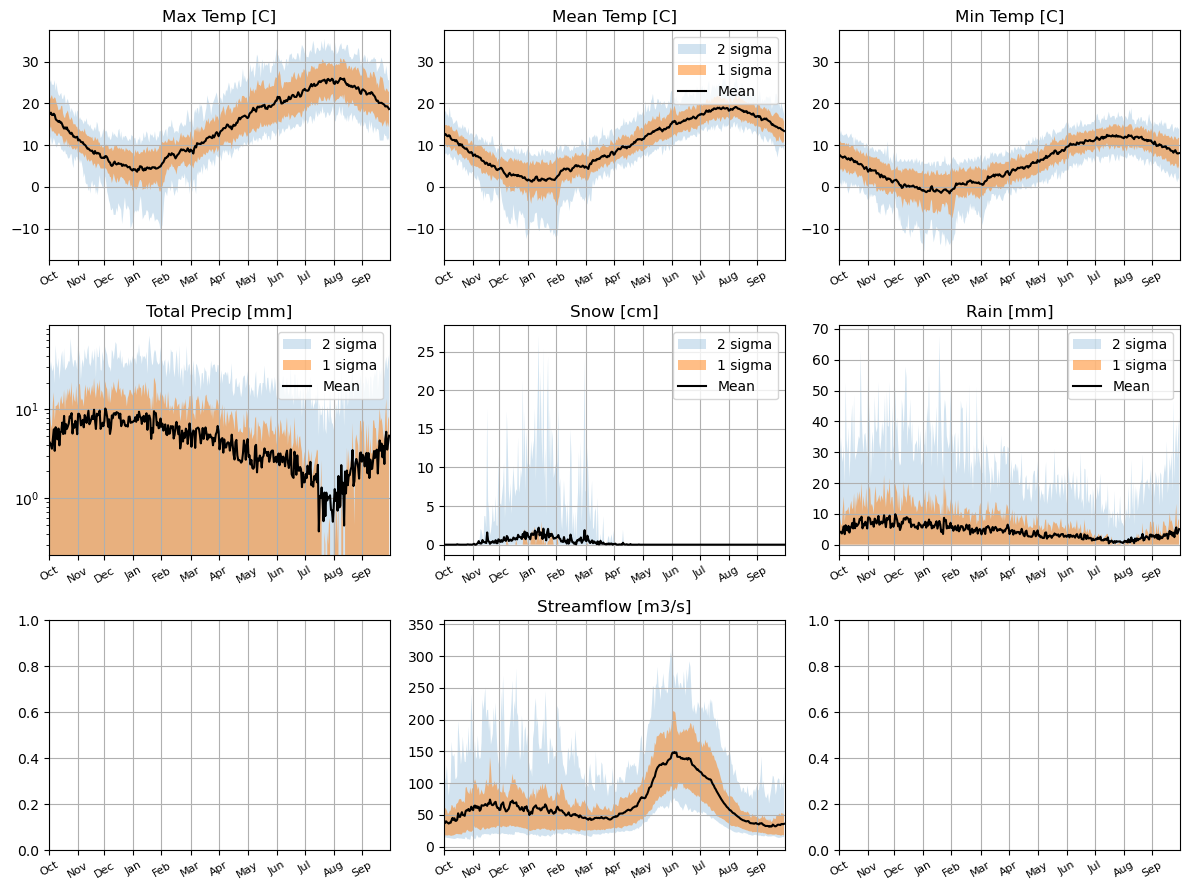

In [68]:
#visualize summary

saveIt = 0

site = 'Banff'
site = 'Columbia_Golden'
site = 'Chilliwack'
# site = 'Pemberton'
kk_site = sites.index(site)

nrows = 3
ncols = 3

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 3*nrows))

ax = axes[0,0]
ax.fill_between(x = np.arange(365), y1 = Tx_p1[kk_site,:], y2 = Tx_p4[kk_site,:], alpha = 0.2, label = '2 sigma')
ax.fill_between(x = np.arange(365), y1 = Tx_p2[kk_site,:], y2 = Tx_p3[kk_site,:], alpha = 0.5, label = '1 sigma')
ax.plot(Tx_mean[kk_site,:], color = 'k', label = 'Mean')
ax.set_title('Max Temp [C]')

ax = axes[0,1]
ax.fill_between(x = np.arange(365), y1 = Tmean_p1[kk_site,:], y2 = Tmean_p4[kk_site,:], alpha = 0.2, label = '2 sigma')
ax.fill_between(x = np.arange(365), y1 = Tmean_p2[kk_site,:], y2 = Tmean_p3[kk_site,:], alpha = 0.5, label = '1 sigma')
ax.plot(Tmean_mean[kk_site,:], color = 'k', label = 'Mean')
ax.set_title('Mean Temp [C]')
ax.legend()

ax = axes[0,2]
ax.fill_between(x = np.arange(365), y1 = Tn_p1[kk_site,:], y2 = Tn_p4[kk_site,:], alpha = 0.2, label = '2 sigma')
ax.fill_between(x = np.arange(365), y1 = Tn_p2[kk_site,:], y2 = Tn_p3[kk_site,:], alpha = 0.5, label = '1 sigma')
ax.plot(Tn_mean[kk_site,:], color = 'k', label = 'Mean')
ax.set_title('Min Temp [C]')
# ax.legend()

ax = axes[1,0]
ax.fill_between(x = np.arange(365), y1 = P_p1[kk_site,:], y2 = P_p4[kk_site,:], alpha = 0.2, label = '2 sigma')
ax.fill_between(x = np.arange(365), y1 = P_p2[kk_site,:], y2 = P_p3[kk_site,:], alpha = 0.5, label = '1 sigma')
ax.plot(P_mean[kk_site,:], color = 'k', label = 'Mean')
ax.set_yscale('log')
ax.set_title('Total Precip [mm]')
ax.legend()

ax = axes[1,1]
ax.fill_between(x = np.arange(365), y1 = Psnow_p1[kk_site,:], y2 = Psnow_p4[kk_site,:], alpha = 0.2, label = '2 sigma')
ax.fill_between(x = np.arange(365), y1 = Psnow_p2[kk_site,:], y2 = Psnow_p3[kk_site,:], alpha = 0.5, label = '1 sigma')
ax.plot(Psnow_mean[kk_site,:], color = 'k', label = 'Mean')
ax.set_title('Snow [cm]')
ax.legend()

ax = axes[1,2]
ax.fill_between(x = np.arange(365), y1 = Prain_p1[kk_site,:], y2 = Prain_p4[kk_site,:], alpha = 0.2, label = '2 sigma')
ax.fill_between(x = np.arange(365), y1 = Prain_p2[kk_site,:], y2 = Prain_p3[kk_site,:], alpha = 0.5, label = '1 sigma')
ax.plot(Prain_mean[kk_site,:], color = 'k', label = 'Mean')
ax.set_title('Rain [mm]')
ax.legend()

ax = axes[2,1]
ax.fill_between(x = np.arange(365), y1 = Q_p1[kk_site,:], y2 = Q_p4[kk_site,:], alpha = 0.2, label = '2 sigma')
ax.fill_between(x = np.arange(365), y1 = Q_p2[kk_site,:], y2 = Q_p3[kk_site,:], alpha = 0.5, label = '1 sigma')
ax.plot(Q_mean[kk_site,:], color = 'k', label = 'Mean')
ax.set_title('Streamflow [m3/s]')

for ax in axes[0,:]:
    ax.set_ylim(top = np.nanmax(Tx_p4[kk_site]) + 2, bottom = np.nanmin(Tn_p1[kk_site]) - 2)

for ax in axes.flatten():
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 30, fontsize = 8)
    
plt.tight_layout()

if saveIt:
    plt.savefig('climate_summary.png', dpi = 300, bbox_inches = 'tight')
    
plt.show()

In [9]:
#calculate cumulative values

Pcumulative = [np.zeros((Nyears,365)) for Nyears in Nyears_sites]
Psnowcumulative = [np.zeros((Nyears,365)) for Nyears in Nyears_sites]
Qcumulative = [np.zeros((Nyears,365)) for Nyears in Nyears_sites]
Qcumulative_filled = [np.zeros((Nyears,365)) for Nyears in Nyears_sites]
Qyearly = [np.zeros((Nyears,365)) for Nyears in Nyears_sites]
Qyearly_filled = [np.zeros((Nyears,365)) for Nyears in Nyears_sites]

for kk_site, site in enumerate(sites):

    df_weather = df_sites['Weather_stations'][site]
    df_flow = df_sites['Streamflow'][site]
    Nyears = Nyears_sites[kk_site]
    data_start_year = df_sites['Year_start'][site]
    Q = df_flow['Value']
    P = df_weather['Total Precip (mm)']
    Psnow = df_weather['Total Snow (cm)']
    
    #fill missing values in Q
    for year in range(0,Nyears):

        day_oct1 = np.argwhere(
            (df_weather.index.year == data_start_year + year) & 
            (df_weather.index.month == 10) & 
            (df_weather.index.day == 1)
        ).squeeze()

        Qyearly[kk_site][year,:] = Q.values[day_oct1:day_oct1 + 365]
        Qcumulative[kk_site][year,:] = np.nancumsum(Q.values[day_oct1:day_oct1 + 365])

    Qyearly_filled[kk_site] = np.copy(Qyearly[kk_site])
    for year in range(Nyears):
        naninds = np.argwhere(np.isnan(Qyearly[kk_site][year,:])).squeeze()
        Qyearly_filled[kk_site][year,naninds] = np.nanmean(Qyearly[kk_site], axis = 0)[naninds]

    #calculate cumulative yearly values
    for year in range(0,Nyears):

        day_oct1 = np.argwhere(
            (df_weather.index.year == data_start_year + year) & 
            (df_weather.index.month == 10) & 
            # (df_weather.index.month == 1) & 
            (df_weather.index.day == 1)
        ).squeeze()

        Pcumulative[kk_site][year,:] = np.nancumsum(P.values[day_oct1:day_oct1 + 365])
        Psnowcumulative[kk_site][year,:] = np.nancumsum(Psnow.values[day_oct1:day_oct1 + 365])
        Qcumulative_filled[kk_site][year,:] = np.nancumsum(Qyearly_filled[kk_site][year,:])
        Qyearly[kk_site][year,:] = Q.values[day_oct1:day_oct1 + 365]
    
Psnowcumulative_june1 = np.array([Psnowcumulative[kk_site][:,first_days_of_month[8]] for kk_site in range(Nsites)])

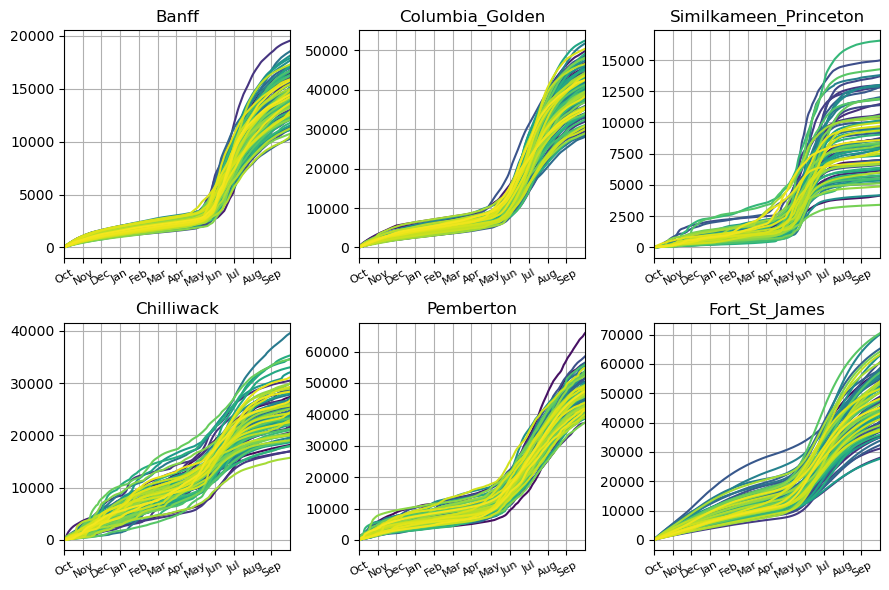

In [10]:
#cumulative flow

nrows = 2
ncols = 3

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3*ncols, 3*nrows))

for ax in axes.flatten():
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 30, fontsize = 8)

for kk_site, site in enumerate(sites):
    
    ax = axes.flatten()[kk_site]
    
    for year in range (Nyears_sites[kk_site]-1):

        color = matplotlib.cm.get_cmap('viridis')(year / Nyears_sites[kk_site])
        ax.plot(Qcumulative_filled[kk_site][year,:], color = color)
    ax.set_title(site)
    
plt.tight_layout()

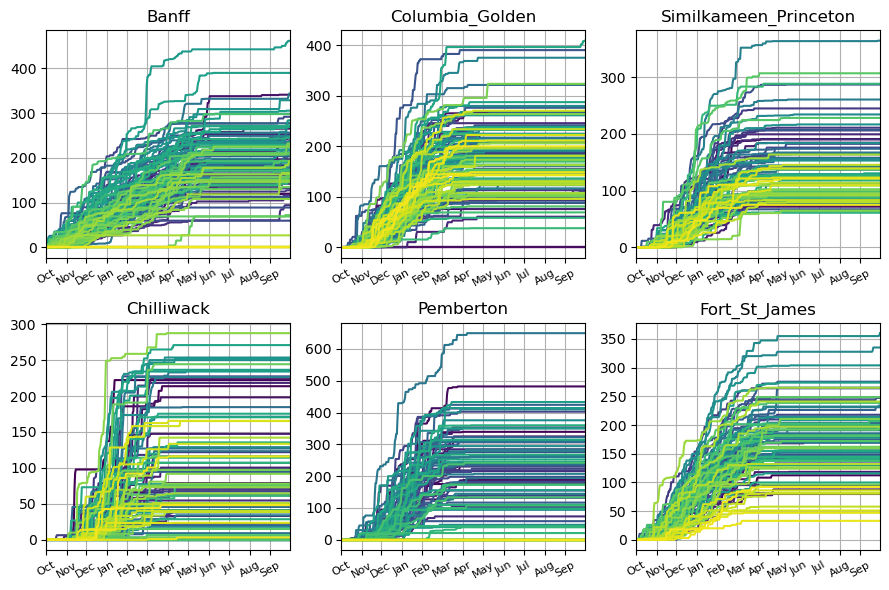

In [11]:
#cumulative snow precip

nrows = 2
ncols = 3

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3*ncols, 3*nrows))

for ax in axes.flatten():
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 30, fontsize = 8)

for kk_site, site in enumerate(sites):
    
    ax = axes.flatten()[kk_site]
    
    for year in range (Nyears_sites[kk_site]-1):

        color = matplotlib.cm.get_cmap('viridis')(year / Nyears_sites[kk_site])
        ax.plot(Psnowcumulative[kk_site][year,:], color = color)
    ax.set_title(site)
    
plt.tight_layout()

# Year categorization

In [12]:
#calculate freshet day (when Qcum threshold reached) for each site

freshet_threshold_sites = np.array([0.25*np.median(Qcumulative_filled[kk_site][:,-1]) for kk_site in range(Nsites)])
freshet_day = [np.zeros(Nyears) for Nyears in Nyears_sites]
years_future_proxy = []
years_baseline = []
years = []

for kk_site, site in enumerate(sites):

    freshet_threshold = freshet_threshold_sites[kk_site]
    Nyears = Nyears_sites[kk_site]
    
    for year in range(len(Qcumulative_filled[kk_site][:,0])):
        var = Qcumulative_filled[kk_site][year,:] - Qcumulative_filled[kk_site][year,183]
        freshet_day[kk_site][year] = np.max(np.argwhere(var<freshet_threshold))
    
# categorize years by freshet timing AND cumulative snowfall, rather than freshet timing alone

years_early_dry = []
years_late_wet = []

years_early_wet = []
years_late_dry = []

for kk_site in range(Nsites):

    var1 = freshet_day[kk_site]
    var2 = Psnowcumulative_june1[kk_site]

    early_dry = np.argwhere(
        (var1 < np.mean(var1)) & 
        (var2 < np.mean(var2[var2>0])) & 
        (var2 > 0)
    ).squeeze()

    late_wet = np.argwhere(
        (var1 > np.mean(var1)) & 
        (var2 > np.mean(var2[var2>0]))
    ).squeeze()
    
    early_wet = np.argwhere(
        (var1 < np.mean(var1)) & 
        (var2 > np.mean(var2[var2>0])) & 
        (var2 > 0)
    ).squeeze()

    late_dry = np.argwhere(
        (var1 > np.mean(var1)) & 
        (var2 < np.mean(var2[var2>0])) & 
        (var2 > 0)
    ).squeeze()
    
    years_early_dry.append(early_dry)
    years_late_wet.append(late_wet)
    
    years_early_wet.append(early_wet)
    years_late_dry.append(late_dry)
    
    print(sites[kk_site] + ':')
    print('\t# early/dry years: ' + str(len(early_dry)))
    print('\t# late/wet years:  ' + str(len(late_wet)))
    print('\t# early/wet years: ' + str(len(early_wet)))
    print('\t# late/dry years:  ' + str(len(late_dry)))

years_future_proxy = years_early_dry
years_baseline = years_late_wet

Nyears_future_proxy = np.array([len(yy) for yy in years_early_dry])
Nyears_baseline = np.array([len(yy) for yy in years_late_wet])

Banff:
	# early/dry years: 26
	# late/wet years:  23
	# early/wet years: 22
	# late/dry years:  27
Columbia_Golden:
	# early/dry years: 22
	# late/wet years:  22
	# early/wet years: 33
	# late/dry years:  34
Similkameen_Princeton:
	# early/dry years: 24
	# late/wet years:  15
	# early/wet years: 19
	# late/dry years:  23
Chilliwack:
	# early/dry years: 29
	# late/wet years:  12
	# early/wet years: 25
	# late/dry years:  25
Pemberton:
	# early/dry years: 14
	# late/wet years:  20
	# early/wet years: 18
	# late/dry years:  23
Fort_St_James:
	# early/dry years: 19
	# late/wet years:  14
	# early/wet years: 31
	# late/dry years:  25


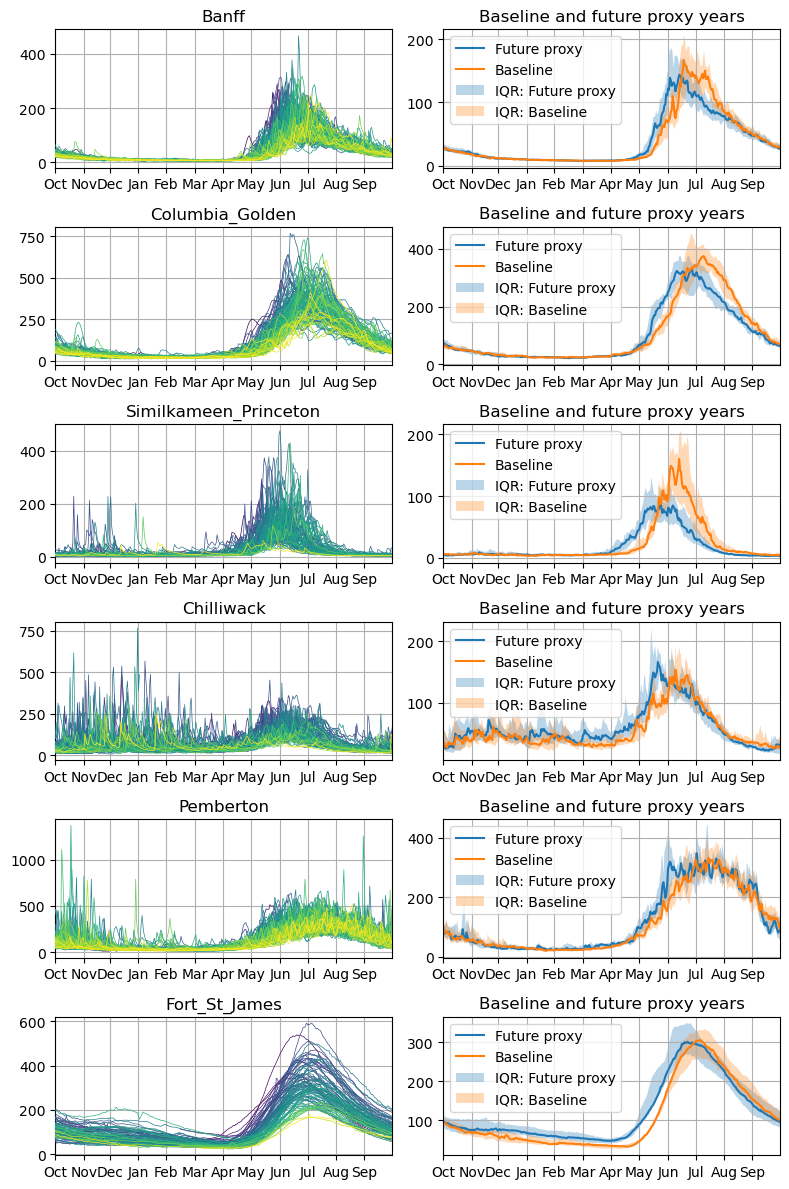

In [15]:
saveIt = 0

nrows = Nsites
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 2*nrows))

for ax in axes.flatten():
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0)

for kk_site, site in enumerate(sites):
    
    for year in range (Nyears_sites[kk_site] - 1):

        #color by freshet timing
        vmax = np.nanmax(freshet_day[kk_site])
        vmin = np.nanmin(freshet_day[kk_site])
        color = matplotlib.cm.get_cmap('viridis')( (freshet_day[kk_site][year] - vmin)/(vmax-vmin) )
        axes[kk_site,0].plot(Qyearly[kk_site][year,:], color = color, linewidth = 0.5, zorder = freshet_day[kk_site][year])

    axes[kk_site,0].set_title(site)
    axes[kk_site,1].set_title('Baseline and future proxy years')

    #plot average of early and late freshet years
    axes[kk_site,1].plot(np.nanmedian(Qyearly[kk_site][years_future_proxy[kk_site],:],axis = 0), label = 'Future proxy')
    axes[kk_site,1].plot(np.nanmedian(Qyearly[kk_site][years_baseline[kk_site],:],axis = 0), label = 'Baseline')

    p1 = 16#25
    p2 = 84#75
    p1 = 25
    p2 = 75
    y1 = np.nanpercentile(Qyearly[kk_site][years_future_proxy[kk_site],:], q = p1, axis = 0)
    y2 = np.nanpercentile(Qyearly[kk_site][years_future_proxy[kk_site],:], q = p2, axis = 0)
    y3 = np.nanpercentile(Qyearly[kk_site][years_baseline[kk_site],:], q = p1, axis = 0)
    y4 = np.nanpercentile(Qyearly[kk_site][years_baseline[kk_site],:], q = p2, axis = 0)
    axes[kk_site,1].fill_between(x = np.arange(365), y1 = y1, y2 = y2, alpha = 0.3, label = 'IQR: Future proxy')
    axes[kk_site,1].fill_between(x = np.arange(365), y1 = y3, y2 = y4, alpha = 0.3, label = 'IQR: Baseline')

    axes[kk_site,1].legend()
    
plt.tight_layout()

if saveIt:
    plt.savefig('streamflow_by_year_classes_freshet_snow.png', dpi = 300, bbox_inches = 'tight')

plt.show()

In [16]:
sites_short = [
    'Bow River',
    'Columbia River',
    'Similkameen River',
    'Lillooet River',
    'Stuart River',
    'Chilliwack River'
]

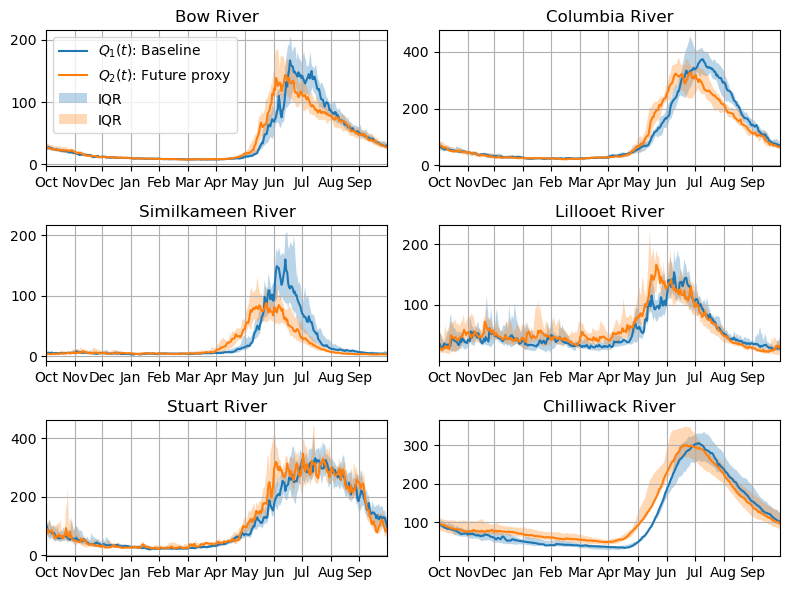

In [17]:
saveIt = 0

nrows = 3
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 2*nrows))

for ax in axes.flatten():
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0)

for kk_site, ax in enumerate(axes.flatten()):
    
    ax.set_title(sites_short[kk_site])

    #plot average of early and late freshet years
    ax.plot(np.nanmedian(Qyearly[kk_site][years_baseline[kk_site],:],axis = 0), label = '$Q_1(t)$: Baseline')
    ax.plot(np.nanmedian(Qyearly[kk_site][years_future_proxy[kk_site],:],axis = 0), label = '$Q_2(t)$: Future proxy')

    p1 = 25
    p2 = 75
    y1 = np.nanpercentile(Qyearly[kk_site][years_future_proxy[kk_site],:], q = p1, axis = 0)
    y2 = np.nanpercentile(Qyearly[kk_site][years_future_proxy[kk_site],:], q = p2, axis = 0)
    y3 = np.nanpercentile(Qyearly[kk_site][years_baseline[kk_site],:], q = p1, axis = 0)
    y4 = np.nanpercentile(Qyearly[kk_site][years_baseline[kk_site],:], q = p2, axis = 0)
    ax.fill_between(x = np.arange(365), y1 = y3, y2 = y4, alpha = 0.3, label = 'IQR')
    ax.fill_between(x = np.arange(365), y1 = y1, y2 = y2, alpha = 0.3, label = 'IQR')

axes[0,0].legend()
    
plt.tight_layout()

if saveIt:
    plt.savefig('Figures/Supplementary/streamflow_regimes.png', dpi = 300, bbox_inches = 'tight')

plt.show()

# Study region figure

In [18]:
#load basin data
basinspickle = 'WSC_basins_1979_2015_missing_40_40_1.pickle' #filename of pickle file which contains the basin outlines
pickle_in = open('/Users/samanderson/repos/heatwave_obs/Data/' + basinspickle, 'rb')
stationBasins = pickle.load(pickle_in)
basin_inds = [157, 51, 88, 80, 121]
basin_inds = [157, 51, 121, 80, 88]
basin_inds = [157, 51, 121, 82, 80, 88]

In [19]:
#load DEM of region and characterize study basins

mosaic = rasterio.open('/Users/samanderson/repos/heatwave_obs/Data/AB_BC_mosaic.tif')
minlon, maxlat = mosaic.xy(0,0)
maxlon, minlat = mosaic.xy(15601,20401)
extentDEM = [minlon,maxlon,minlat,maxlat]
dem = mosaic.read(1)
dem = np.array(dem, dtype = np.float32)
dem[dem<0] = 0

minlon, maxlat = mosaic.xy(0,0)
maxlon, minlat = mosaic.xy(15601,20401)
extentDEM = [minlon,maxlon,minlat,maxlat]

demLon = np.linspace(minlon,maxlon,15601)
demLat = np.linspace(minlat,maxlat,20401)

In [20]:
#make hillshade
nn = 2000
res = cv2.resize(dem, dsize=(nn, nn), interpolation=cv2.INTER_LINEAR) #resize to smaller dimensions
demLon = np.linspace(minlon,maxlon,nn)
demLat = np.linspace(minlat,maxlat,nn)
hs_array = hillshade(res,315,315) #hillshade
hs_array = hillshade(res,315,360) #hillshade
demLat = np.flipud(demLat.reshape(-1,1)).squeeze()

In [22]:
#open RGI data and extract area/locations

rgi_dir = '/Users/samanderson/repos/heatwave_obs/Data/'

poly_filename = '02_rgi60_WesternCanadaUS.shp'
polys = gpd.read_file(rgi_dir + poly_filename)
cenLon = polys['CenLon']
cenLat = polys['CenLat']
area = polys['Area']

In [69]:

sites_short = [
    'Bow River',
    'Columbia River',
    'Similkameen River',
    'Chilliwack River',
    'Lillooet River',
    'Stuart River'
]

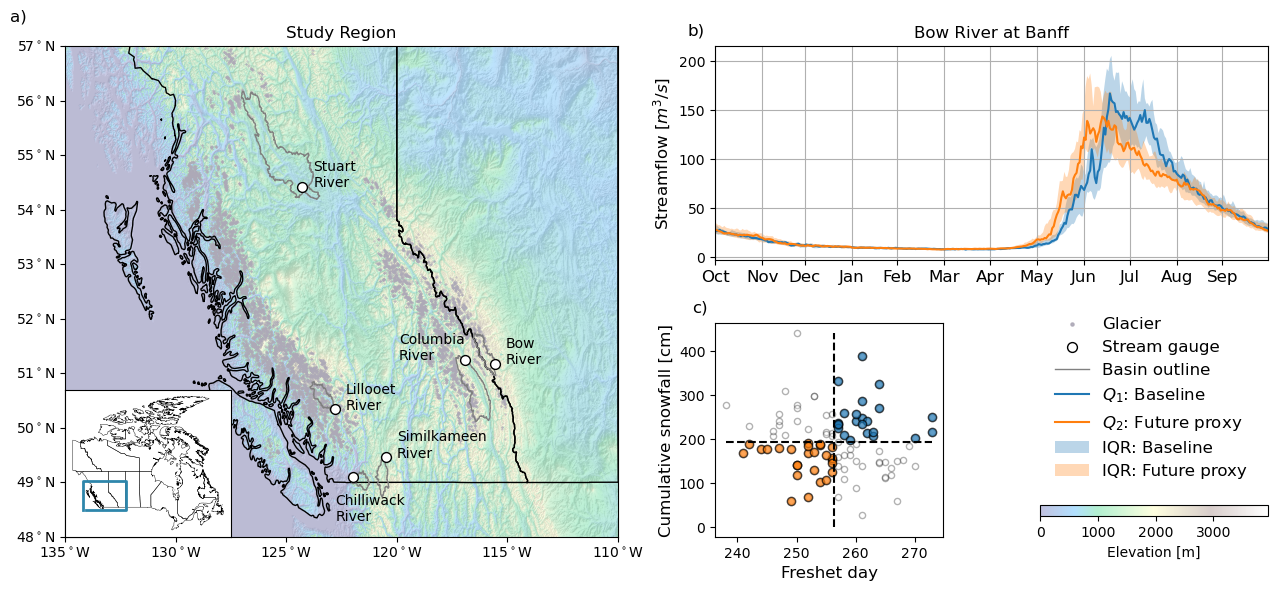

In [24]:
#visualize study region

saveIt = 0

fs = 12

nrows = 4
ncols = 4
fig = plt.figure(figsize = (3.2*ncols, 1.5*nrows))
gs = fig.add_gridspec(nrows = nrows, ncols = ncols)

ax_map = fig.add_subplot(gs[:,:-2])
ax_banff = fig.add_subplot(gs[:2,-2:])
ax_years = fig.add_subplot(gs[2:,-2])
ax_legend = fig.add_subplot(gs[2:,-1])

##### INSET
rgb_bb = np.array([46, 134, 171]) / 255
canada_east = -108
canada_west = -142
canada_north = 60
canada_south = 46
ax_inset = plt.axes([0,0,1,1], aspect = 'auto')
ip = InsetPosition(ax_map, [0,0,0.3,0.3])
ax_inset.set_axes_locator(ip)
plot_prov_ax(prov = 'all', ax = ax_inset, linewidth = 0.3)

#bounding box
x = [-135,-135,-110,-110,-133]
y = [48,57,57,48,48]
ax_inset.plot(x,y, color = rgb_bb, linewidth = 2)
ax_inset.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)
#####

##### MAP
topo = ax_map.imshow(res, aspect = 'auto', vmin = 0, alpha = 0.3, cmap = 'terrain', extent = extentDEM)
hill = ax_map.imshow(hs_array, aspect = 'auto', alpha = 0.15, cmap = 'Greys', extent = extentDEM)
plot_prov_ax(prov=prov, ax = ax_map)
cc = np.array([173, 169, 183]) / 255
ax_map.scatter(cenLon[cenLat>49],cenLat[cenLat>49], color=cc, s = 0.15, alpha = 0.9) #glaciers in figure
ax_map.scatter(0,0, color=cc, s = 5, alpha = 0.9, label = 'Glacier') #for legend
ax_map.scatter(df_sites['Longitude'],df_sites['Latitude'], color='w', s = 50, linewidth = 1, edgecolor = 'k', zorder = 3, label = 'Stream gauge')

ax_map.tick_params(labelsize = fs-2)
ax_map.set_title('Study Region', fontsize = fs)
ax_map.set_ylim(bottom = 48, top = 57)
ax_map.set_xlim(left = -135, right = -110)

#basins
jj = 0
for kk,basin in enumerate([stationBasins[ind] for ind in basin_inds]):
  if basin is not None:
    jj+=1
    x,y = basin.exterior.xy
    #label
    if jj == 1:
      ax_map.plot(x, y, color = 'gray', linewidth = 1, label = 'Basin outline')
    else:
      ax_map.plot(x, y, color = 'gray', linewidth = 1)

# ax_map.legend(fontsize = 9, loc = 'upper left')
ax_map.text(x = -0.1, y = 1.05, s = abc[0], transform = ax_map.transAxes, fontsize = fs)
ax_map.tick_params(labelsize = fs-2)
#####

##### BANFF FLOW
kk_site = 0
p1 = 16#25
p2 = 84#75
p1 = 25
p2 = 75
y1 = np.nanpercentile(Qyearly[kk_site][years_future_proxy[kk_site],:], q = p1, axis = 0)
y2 = np.nanpercentile(Qyearly[kk_site][years_future_proxy[kk_site],:], q = p2, axis = 0)
y3 = np.nanpercentile(Qyearly[kk_site][years_baseline[kk_site],:], q = p1, axis = 0)
y4 = np.nanpercentile(Qyearly[kk_site][years_baseline[kk_site],:], q = p2, axis = 0)
ax_banff.plot(np.nanmedian(Qyearly[kk_site][years_baseline[kk_site],:],axis = 0), label = '$Q_1$: Baseline')
ax_banff.plot(np.nanmedian(Qyearly[kk_site][years_future_proxy[kk_site],:],axis = 0), label = '$Q_2$: Future proxy')
ax_banff.fill_between(x = np.arange(365), y1 = y3, y2 = y4, alpha = 0.3, label = 'IQR: Baseline')
ax_banff.fill_between(x = np.arange(365), y1 = y1, y2 = y2, alpha = 0.3, label = 'IQR: Future proxy')

ax_banff.set_title('Bow River at Banff', fontsize = fs)
ax_banff.set_ylabel('Streamflow [$m^3/s$]', fontsize = fs)
ax_banff.tick_params(labelsize = fs-2)
ax_banff.text(x = -0.05, y = 1.05, s = abc[1], transform = ax_banff.transAxes, fontsize = fs)

##### freshet timing vs cumulative snowfall
freshet_day_mean = np.array([np.nanmean(freshet_day[kk_site]) for kk_site in range(Nsites)])
var = Psnowcumulative_june1
Psnowcumulative_june1_mean = np.array([np.nanmean(var[kk_site][var[kk_site]>0]) for kk_site in range(Nsites)])
inds = np.argwhere(var[kk_site]>0).squeeze()

inds_baseline = np.argwhere(
    (var[kk_site][inds]>Psnowcumulative_june1_mean[kk_site]) & 
    (freshet_day[kk_site][inds]>freshet_day_mean[kk_site])).squeeze()
    
inds_future = np.argwhere(
    (var[kk_site][inds]<Psnowcumulative_june1_mean[kk_site]) & 
    (freshet_day[kk_site][inds]<freshet_day_mean[kk_site])).squeeze()

ax_years.scatter(freshet_day[kk_site][inds], Psnowcumulative_june1[kk_site][inds], s = 20, facecolor = 'w', edgecolor = 'k', alpha = 0.3)
ax_years.scatter(freshet_day[kk_site][inds][inds_baseline], Psnowcumulative_june1[kk_site][inds][inds_baseline], edgecolor = 'k', alpha = 0.7)
ax_years.scatter(freshet_day[kk_site][inds][inds_future], Psnowcumulative_june1[kk_site][inds][inds_future], edgecolor = 'k', alpha = 0.7)

ax_years.plot([freshet_day_mean[kk_site], freshet_day_mean[kk_site]],
        [np.nanmin(Psnowcumulative_june1[kk_site]), np.nanmax(Psnowcumulative_june1[kk_site])],
       'k--')

ax_years.plot([np.nanmin(freshet_day[kk_site]), np.nanmax(freshet_day[kk_site])],
        [Psnowcumulative_june1_mean[kk_site], Psnowcumulative_june1_mean[kk_site]],
       'k--')

ax_years.set_xlabel('Freshet day', fontsize = fs)
ax_years.set_ylabel('Cumulative snowfall [cm]', fontsize = fs)
# ax_years.set_title(sites[kk_site])
ax_years.tick_params(labelsize = fs-2)
ax_years.text(x = -0.1, y = 1.05, s = abc[2], transform = ax_years.transAxes, fontsize = fs)
#####

#### FIGURE FORMATTING

#legend
h0, l0 = ax_map.get_legend_handles_labels()
h1, l1 = ax_banff.get_legend_handles_labels()
h2, l2 = ax_years.get_legend_handles_labels()
labels = l0+l1+l2
handles = h0+h1+h2
ax_legend.legend(handles, labels, fontsize = fs, frameon = False, loc = 'center left')
ax_legend.axis('off')

#ticks/etc
for ax in [ax_banff]:
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0, fontsize = fs)
    
cbar = plt.colorbar(topo, ax = ax_legend, orientation='horizontal')
cbar.ax.set_xlabel('Elevation [m]', fontsize = fs-2)

plt.tight_layout()

#edit ticklabels
xtls = [item.get_text()[1:] + '$^\circ$W' for item in ax_map.get_xticklabels()]
ax_map.set_xticklabels(xtls)
ytls = [item.get_text() + '$^\circ$N' for item in ax_map.get_yticklabels()]
ax_map.set_yticklabels(ytls)

#add station labels
ax_map.text(x = df_sites['Longitude'][0]+0.5, y = df_sites['Latitude'][0], s = sites_short[0])
ax_map.text(x = df_sites['Longitude'][1]-3, y = df_sites['Latitude'][1], s = sites_short[1])
ax_map.text(x = df_sites['Longitude'][2]+0.5, y = df_sites['Latitude'][2], s = sites_short[2])
ax_map.text(x = df_sites['Longitude'][3]+0.5, y = df_sites['Latitude'][3], s = sites_short[4])
ax_map.text(x = df_sites['Longitude'][4]+0.5, y = df_sites['Latitude'][4], s = sites_short[5])
ax_map.text(x = df_sites['Longitude'][5]-0.8, y = df_sites['Latitude'][5]-0.8, s = sites_short[3])

#####
    
if saveIt:
    plt.savefig('Figures/study_region.png', bbox_inches = 'tight', dpi = 300)

plt.show()

# Calculate climate of year categories

In [26]:
Qcumulative_future_proxy = np.zeros((Nsites,365))
Qcumulative_baseline = np.zeros((Nsites,365))
Pcumulative_future_proxy = np.zeros((Nsites,365))
Pcumulative_baseline = np.zeros((Nsites,365))
Psnowcumulative_future_proxy = np.zeros((Nsites,365))
Psnowcumulative_baseline = np.zeros((Nsites,365))

Tmean_future_proxy = [np.zeros(nn) for nn in Nyears_future_proxy]
Tmean_baseline = [np.zeros(nn) for nn in Nyears_baseline]
Tmean_future_proxy_monthly = [np.zeros((12,nn)) for nn in Nyears_future_proxy]
Tmean_baseline_monthly = [np.zeros((12,nn)) for nn in Nyears_baseline]

Tmax_future_proxy = [np.zeros(nn) for nn in Nyears_future_proxy]
Tmax_baseline = [np.zeros(nn) for nn in Nyears_baseline]
Tmax_future_proxy_monthly = [np.zeros((12,nn)) for nn in Nyears_future_proxy]
Tmax_baseline_monthly = [np.zeros((12,nn)) for nn in Nyears_baseline]

Tmin_future_proxy = [np.zeros(nn) for nn in Nyears_future_proxy]
Tmin_baseline = [np.zeros(nn) for nn in Nyears_baseline]
Tmin_future_proxy_monthly = [np.zeros((12,nn)) for nn in Nyears_future_proxy]
Tmin_baseline_monthly = [np.zeros((12,nn)) for nn in Nyears_baseline]

P_future_proxy = [np.zeros(nn) for nn in Nyears_future_proxy]
P_baseline = [np.zeros(nn) for nn in Nyears_baseline]
P_future_proxy_monthly = [np.zeros((12,nn)) for nn in Nyears_future_proxy]
P_baseline_monthly = [np.zeros((12,nn)) for nn in Nyears_baseline]

for kk_site, site in enumerate(sites):  
    
    df_weather = df_sites['Weather_stations'][site]
    year_start = df_sites['Year_start'][site] + 1
    
    #cumulative flow
    Qcumulative_future_proxy[kk_site,:] = np.mean(Qcumulative_filled[kk_site][years_future_proxy[kk_site],:], axis = 0)
    Qcumulative_baseline[kk_site,:] = np.mean(Qcumulative_filled[kk_site][years_baseline[kk_site],:], axis = 0)

    #cumulative precip
    Pcumulative_future_proxy[kk_site,:] = np.mean(Pcumulative[kk_site][years_future_proxy[kk_site],:], axis = 0)
    Pcumulative_baseline[kk_site,:] = np.mean(Pcumulative[kk_site][years_baseline[kk_site],:], axis = 0)
    Psnowcumulative_future_proxy[kk_site,:] = np.mean(Psnowcumulative[kk_site][years_future_proxy[kk_site],:], axis = 0)
    Psnowcumulative_baseline[kk_site,:] = np.mean(Psnowcumulative[kk_site][years_baseline[kk_site],:], axis = 0)

    #mean temperature by year and month
    Tmean_future_proxy[kk_site] = np.array([np.mean(df_weather['Mean Temp (°C)'][df_weather['Year']==year+year_start]) for year in years_future_proxy[kk_site]])
    Tmean_baseline[kk_site] = np.array([np.mean(df_weather['Mean Temp (°C)'][df_weather['Year']==year+year_start]) for year in years_baseline[kk_site]])
    Tmean_future_proxy_monthly[kk_site] = np.array([np.array([np.mean(df_weather['Mean Temp (°C)'][(df_weather['Year']==year+year_start) & (df_weather['Month']==month+1)]) for year in years_future_proxy[kk_site]]) for month in range(12)])
    Tmean_baseline_monthly[kk_site] = np.array([np.array([np.mean(df_weather['Mean Temp (°C)'][(df_weather['Year']==year+year_start) & (df_weather['Month']==month+1)]) for year in years_baseline[kk_site]]) for month in range(12)])

    #max temperature by year and month
    Tmax_future_proxy[kk_site] = np.array([np.mean(df_weather['Max Temp (°C)'][df_weather['Year']==year+year_start]) for year in years_future_proxy[kk_site]])
    Tmax_baseline[kk_site] = np.array([np.mean(df_weather['Max Temp (°C)'][df_weather['Year']==year+year_start]) for year in years_baseline[kk_site]])
    Tmax_future_proxy_monthly[kk_site] = np.array([np.array([np.mean(df_weather['Max Temp (°C)'][(df_weather['Year']==year+year_start) & (df_weather['Month']==month+1)]) for year in years_future_proxy[kk_site]]) for month in range(12)])
    Tmax_baseline_monthly[kk_site] = np.array([np.array([np.mean(df_weather['Max Temp (°C)'][(df_weather['Year']==year+year_start) & (df_weather['Month']==month+1)]) for year in years_baseline[kk_site]]) for month in range(12)])

    #min temperature by year and month
    Tmin_future_proxy[kk_site] = np.array([np.mean(df_weather['Min Temp (°C)'][df_weather['Year']==year+year_start]) for year in years_future_proxy[kk_site]])
    Tmin_baseline[kk_site] = np.array([np.mean(df_weather['Min Temp (°C)'][df_weather['Year']==year+year_start]) for year in years_baseline[kk_site]])
    Tmin_future_proxy_monthly[kk_site] = np.array([np.array([np.mean(df_weather['Min Temp (°C)'][(df_weather['Year']==year+year_start) & (df_weather['Month']==month+1)]) for year in years_future_proxy[kk_site]]) for month in range(12)])
    Tmin_baseline_monthly[kk_site] = np.array([np.array([np.mean(df_weather['Min Temp (°C)'][(df_weather['Year']==year+year_start) & (df_weather['Month']==month+1)]) for year in years_baseline[kk_site]]) for month in range(12)])

    #precip by year and month
    P_future_proxy[kk_site] = np.array([np.nansum(df_weather['Total Precip (mm)'][df_weather['Year']==year+year_start]) for year in years_future_proxy[kk_site]])
    P_baseline[kk_site] = np.array([np.nansum(df_weather['Total Precip (mm)'][df_weather['Year']==year+year_start]) for year in years_baseline[kk_site]])
    P_future_proxy_monthly[kk_site] = np.array([np.array([np.nansum(df_weather['Total Precip (mm)'][(df_weather['Year']==year+year_start) & (df_weather['Month']==month+1)]) for year in years_future_proxy[kk_site]]) for month in range(12)])
    P_baseline_monthly[kk_site] = np.array([np.array([np.nansum(df_weather['Total Precip (mm)'][(df_weather['Year']==year+year_start) & (df_weather['Month']==month+1)]) for year in years_baseline[kk_site]]) for month in range(12)])

In [27]:
for kk_site, site in enumerate(sites):
    x1 = np.nanmean(Tmean_future_proxy[kk_site])
    x2 = np.nanmean(Tmean_baseline[kk_site])
    x3 = Psnowcumulative_future_proxy[kk_site][-1]
    x4 = Psnowcumulative_baseline[kk_site][-1]
    x5 = Pcumulative_future_proxy[kk_site][-1]
    x6 = Pcumulative_baseline[kk_site][-1]
    
    dT = x1 - x2
    dPsnow = 100 * (x3 - x4) / x4
    dP = 100 * (x5 - x6) / x6
    
    print(site)
    print()
    print('\tEarly/dry temp:  ', np.round(x1, decimals = 2), 'C')
    print('\tLate/wet temp:   ', np.round(x2, decimals = 2), 'C')
    print('\tEarly/dry snow:  ', np.round(x3, decimals = 2), 'cm')
    print('\tLate/wet snow:   ', np.round(x4, decimals = 2), 'cm')
    print('\tEarly/dry precip:  ', np.round(x5, decimals = 2), 'mm')
    print('\tLate/wet precip:   ', np.round(x6, decimals = 2), 'mm')
    print()
    print('\tTemp diff:       ', np.round(dT, decimals = 2), 'C')
    print('\tSnow diff:       ', np.round(dPsnow, decimals = 2), '%')
    print('\tPrecip diff:     ', np.round(dP, decimals = 2), '%')
    print()

Banff

	Early/dry temp:   2.21 C
	Late/wet temp:    2.14 C
	Early/dry snow:   160.18 cm
	Late/wet snow:    258.1 cm
	Early/dry precip:   422.84 mm
	Late/wet precip:    480.15 mm

	Temp diff:        0.07 C
	Snow diff:        -37.94 %
	Precip diff:      -11.94 %

Columbia_Golden

	Early/dry temp:   5.34 C
	Late/wet temp:    4.27 C
	Early/dry snow:   130.7 cm
	Late/wet snow:    215.15 cm
	Early/dry precip:   424.74 mm
	Late/wet precip:    500.7 mm

	Temp diff:        1.07 C
	Snow diff:        -39.25 %
	Precip diff:      -15.17 %

Similkameen_Princeton

	Early/dry temp:   6.64 C
	Late/wet temp:    5.7 C
	Early/dry snow:   102.99 cm
	Late/wet snow:    170.8 cm
	Early/dry precip:   321.76 mm
	Late/wet precip:    352.17 mm

	Temp diff:        0.95 C
	Snow diff:        -39.7 %
	Precip diff:      -8.64 %

Chilliwack

	Early/dry temp:   10.27 C
	Late/wet temp:    9.93 C
	Early/dry snow:   46.19 cm
	Late/wet snow:    159.81 cm
	Early/dry precip:   1497.71 mm
	Late/wet precip:    1621.67 mm

	Temp

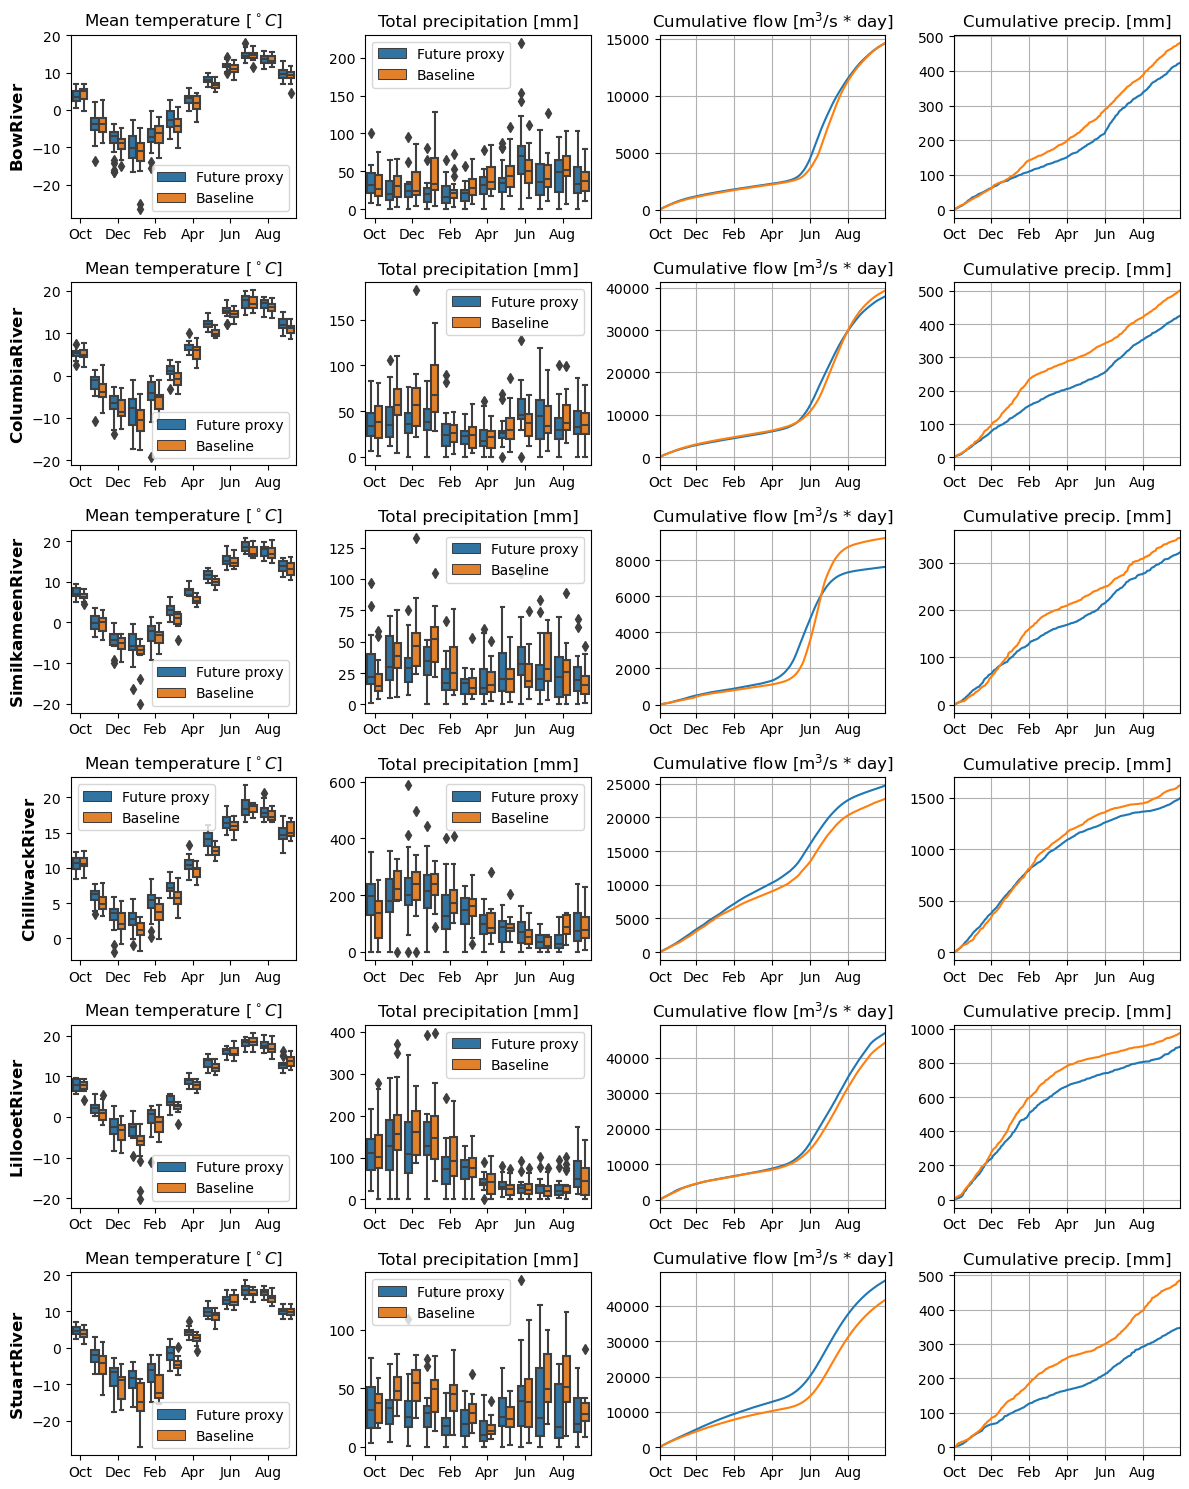

In [70]:
saveIt = 0

nrows = Nsites
ncols = 4

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3*ncols, 2.5*nrows))

for kk_site, site in enumerate(sites):

    ax = axes[kk_site,0]

    aa = np.concatenate([Tmean_future_proxy_monthly[kk_site][month,:] for month in month_water_year])
    bb = np.concatenate([Tmean_baseline_monthly[kk_site][month,:] for month in month_water_year])

    cc = np.concatenate([aa,bb])
    bins = np.concatenate([np.concatenate([month*np.ones(len(var[month,:])) for month in range(12)]) for var in [Tmean_future_proxy_monthly[kk_site], Tmean_baseline_monthly[kk_site]]])
    hue = np.concatenate([np.tile('Future proxy',len(aa)), np.tile('Baseline', len(bb))])
    sns.boxplot(
        x = bins,
        y = cc,
        hue = hue,
        ax = ax
    )
    ax.set_title('Mean temperature [$^\circ C$]')
    ax.set_ylabel(r'$\bf{' + sites_short[kk_site] + '}$', fontsize = fs)
                

    ax = axes[kk_site,1]
    aa = np.concatenate([P_future_proxy_monthly[kk_site][month,:] for month in month_water_year])
    bb = np.concatenate([P_baseline_monthly[kk_site][month,:] for month in month_water_year])
    cc = np.concatenate([aa,bb])
    hue = np.concatenate([np.tile('Future proxy',len(aa)), np.tile('Baseline', len(bb))])
    sns.boxplot(
        x = bins,
        y = cc,
        hue = hue,
        ax = ax
    )
    ax.set_title('Total precipitation [mm]')

    ax = axes[kk_site,2]
    ax.plot(Qcumulative_future_proxy[kk_site], label = 'Future proxy')
    ax.plot(Qcumulative_baseline[kk_site], label = 'Baseline')
    ax.set_title('Cumulative flow [m$^3$/s * day]')

    ax = axes[kk_site,3]
    ax.plot(Pcumulative_future_proxy[kk_site], label = 'Future proxy')
    ax.plot(Pcumulative_baseline[kk_site], label = 'Baseline')
    ax.set_title('Cumulative precip. [mm]')

for ax in axes[:,:2].flatten():
    ax.set_xticks(ax.get_xticks()[::2])
    ax.set_xticklabels(months_str[::2], rotation = 0)
    
for ax in axes[:,2:].flatten():
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_xticks(first_days_of_month[::2])
    ax.set_xticklabels(months_str[::2], rotation = 0)
    
plt.tight_layout()

if saveIt:
    plt.savefig('Figures/Supplementary/year_classes_climate_summary.png', dpi = 300, bbox_inches = 'tight')

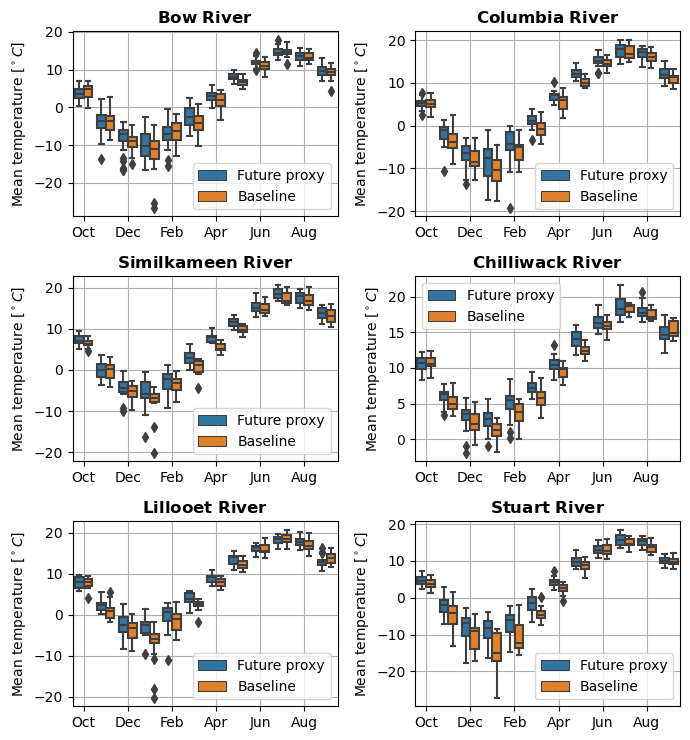

In [71]:
#TEMPERATURE: BY YEAR CATEGORY

saveIt = 0

nrows = 3
ncols = 2

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3.5*ncols, 2.5*nrows))

for kk_site, ax in enumerate(axes.flatten()):

    bb = np.concatenate([Tmean_baseline_monthly[kk_site][month,:] for month in month_water_year])
    aa = np.concatenate([Tmean_future_proxy_monthly[kk_site][month,:] for month in month_water_year])

    cc = np.concatenate([aa,bb])
    bins = np.concatenate([np.concatenate([month*np.ones(len(var[month,:])) for month in range(12)]) for var in [Tmean_future_proxy_monthly[kk_site], Tmean_baseline_monthly[kk_site]]])
    hue = np.concatenate([np.tile('Future proxy',len(aa)), np.tile('Baseline', len(bb))])
    sns.boxplot(
        x = bins,
        y = cc,
        hue = hue,
        ax = ax
    )
    ax.set_ylabel('Mean temperature [$^\circ C$]')
    ax.set_title(r'$\bf{' + sites_short[kk_site][:-5] + '}$' + ' ' + r'$\bf{' + sites_short[kk_site][-5:] + '}$')

for ax in axes.flatten():
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.set_xticks(ax.get_xticks()[::2])
    ax.set_xticklabels(months_str[::2], rotation = 0)

    
plt.tight_layout()

if saveIt:
    plt.savefig('Figures/Supplementary/year_classes_temp_summary.png', dpi = 300, bbox_inches = 'tight')

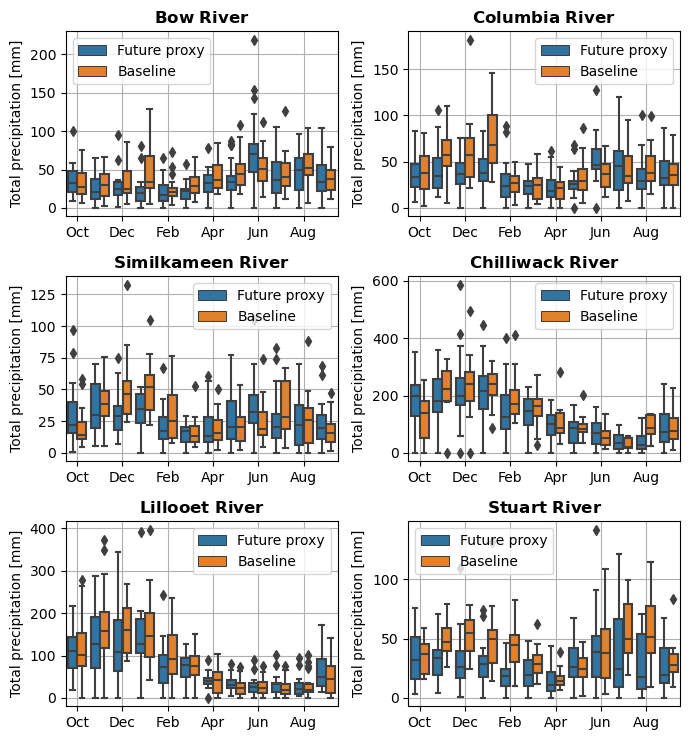

In [72]:
#PRECIP: BY YEAR CATEGORY

saveIt = 0

nrows = 3
ncols = 2

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3.5*ncols, 2.5*nrows))

for kk_site, ax in enumerate(axes.flatten()):               

    aa = np.concatenate([P_future_proxy_monthly[kk_site][month,:] for month in month_water_year])
    bb = np.concatenate([P_baseline_monthly[kk_site][month,:] for month in month_water_year])
    cc = np.concatenate([aa,bb])
    bins = np.concatenate([np.concatenate([month*np.ones(len(var[month,:])) for month in range(12)]) for var in [Tmean_future_proxy_monthly[kk_site], Tmean_baseline_monthly[kk_site]]])
    hue = np.concatenate([np.tile('Future proxy',len(aa)), np.tile('Baseline', len(bb))])
    sns.boxplot(
        x = bins,
        y = cc,
        hue = hue,
        ax = ax
    )
    ax.set_ylabel('Total precipitation [mm]')
    ax.set_title(r'$\bf{' + sites_short[kk_site][:-5] + '}$' + ' ' + r'$\bf{' + sites_short[kk_site][-5:] + '}$')


for ax in axes.flatten():
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.set_xticks(ax.get_xticks()[::2])
    ax.set_xticklabels(months_str[::2], rotation = 0)

    
plt.tight_layout()

if saveIt:
    plt.savefig('Figures/Supplementary/year_classes_precip_summary.png', dpi = 300, bbox_inches = 'tight')

# Calculate heatwaves and their qualities

In [31]:
Psnow_dec1 = [np.zeros(nn) for nn in Nyears_sites]
years_snowy = [None for kk in range(Nsites)]
years_dry = [None for kk in range(Nsites)]

for kk_site in range(Nsites):

    Psnow_dec1[kk_site] = Psnowcumulative[kk_site][:,61]
    years_snowy[kk_site] = np.argwhere(Psnow_dec1[kk_site] > 0).squeeze()
    years_dry[kk_site] = np.argwhere(Psnow_dec1[kk_site] == 0).squeeze()

In [32]:
#calculate:
#when are heatwaves?
#what are the qualities and meteorological characteristics of all heatwaves?

hws = [[] for kk in range(Nsites)]
Tmean_exceedance = []

for kk_site, site in enumerate(sites):

    df_weather = df_sites['Weather_stations'][site]
    df_flow = df_sites['Streamflow'][site]
    Nyears = Nyears_sites[kk_site]
    data_start_year = df_sites['Year_start'][site]
    Q = df_flow['Value']
    Tmean = df_weather['Mean Temp (°C)']
    Tx = df_weather['Max Temp (°C)']
    Tn = df_weather['Min Temp (°C)']
    Ndays = len(Q)
    
    #temp exceedance and anomaly
    Tmean_90_4year = np.concatenate([Tmean_90[kk_site],Tmean_90[kk_site],Tmean_90[kk_site],np.array([Tmean_90[kk_site][-1]]),Tmean_90[kk_site]]) #3 normal years and 1 leap year in 1912
    Tmean_50_4year = np.concatenate([Tmean_50[kk_site],Tmean_50[kk_site],Tmean_50[kk_site],np.array([Tmean_50[kk_site][-1]]),Tmean_50[kk_site]]) #3 normal years and 1 leap year in 1912
    Tmean_90_vector = np.tile(Tmean_90_4year,29)[:len(Q)]
    Tmean_50_vector = np.tile(Tmean_50_4year,29)[:len(Q)]
    Tmean_exceedance.append(Tmean - Tmean_90_vector)
    Tmean_anomaly = Tmean - Tmean_50_vector

    inds_hotter_90 = np.argwhere([Tmean > Tmean_90_vector])[:,1]
    is_heatwave = np.zeros(Ndays)

    #determine the indices of all heatwave days in temperature record
    for kk,ind in enumerate(inds_hotter_90[2:]):
        if (inds_hotter_90[2:][kk-2]==ind-2) & (inds_hotter_90[2:][kk-1]==ind-1): #if prior two days were also >90th percentile
            if P_running[kk_site][ind] < 200: #adjust running precip threshold to identify hot/dry vs just hot events
                if (np.isnan(Q[ind]) == False) & (np.isnan(Q[ind-1]) == False) & (np.isnan(Q[ind-2]) == False): #if streamflow data is available
                    is_heatwave[ind] = 1
                    is_heatwave[ind-1] = 1
                    is_heatwave[ind-2] = 1
    inds_heatwave = np.argwhere(is_heatwave==1)

    #define heatwaves as events, defined by a start day and end day
    jj_hw = 0
    hws[kk_site] = np.zeros([6000,2])
    hws[kk_site][0,0] = inds_heatwave[0]
    for kk, ind in enumerate(inds_heatwave[:-1]):
        if inds_heatwave[kk+1] != ind + 1: #if the next heatwave day is not the following day, it means we have reached the end of this heatwave
            hws[kk_site][jj_hw,1] = ind #final day of current heatwave is the present day
            hws[kk_site][jj_hw+1,0] = inds_heatwave[kk+1] #first day of next heatwave is the next heatwave day
            jj_hw+=1
    hws[kk_site] = hws[kk_site][:jj_hw-1,:] #clip final hw (end day of final hw is day 0)

In [36]:
#hw characteristics 

Nhws = [len(hh) for hh in hws]
hwd = [np.zeros(nn) for nn in Nhws]   #duration (days)
hwm = [np.zeros(nn) for nn in Nhws]   #magnitude (degrees)
t_hw = [np.zeros(nn) for nn in Nhws]  #timing (day of year)

year_categories_hw = [np.zeros(nn) for nn in Nhws] #0: basic year; 1: baseline; 2: future proxy

dQ_hw = [np.zeros(nn) for nn in Nhws] #change in streamflow (m3/s)
dQdt_hw = [np.zeros(nn) for nn in Nhws] #rate of change in streamflow (m3/s)
dQdT_hw = [np.zeros(nn) for nn in Nhws]
Qinit = [np.zeros(nn) for nn in Nhws]
Qfinal = [np.zeros(nn) for nn in Nhws]

Tmean_hw = [np.zeros(nn) for nn in Nhws]  #mean temp during heatwave (degrees)
Tmean_prior_week = [np.zeros(nn) for nn in Nhws]  #mean temp before heatwave (degrees)
Tmean_prior_month = [np.zeros(nn) for nn in Nhws]  #mean temp before heatwave (degrees)
Tmean_prior_season = [np.zeros(nn) for nn in Nhws]  #mean temp before heatwave (degrees)
Tmean_prior_year = [np.zeros(nn) for nn in Nhws]

P_hw = [np.zeros(nn) for nn in Nhws]  #precip during heatwave (mm)
P_prior_week = [np.zeros(nn) for nn in Nhws]  #precip before heatwave (degrees)
P_prior_month = [np.zeros(nn) for nn in Nhws]  #precip before heatwave (degrees)
P_prior_season = [np.zeros(nn) for nn in Nhws]  #precip before heatwave (degrees)
P_prior_year = [np.zeros(nn) for nn in Nhws]

Tmean_prior_week_anomaly = [np.zeros(nn) for nn in Nhws]  #mean temp before heatwave (degrees)
Tmean_prior_month_anomaly = [np.zeros(nn) for nn in Nhws]  #mean temp before heatwave (degrees)
Tmean_prior_season_anomaly = [np.zeros(nn) for nn in Nhws]  #mean temp before heatwave (degrees)
Tmean_prior_year_anomaly = [np.zeros(nn) for nn in Nhws]

hw_year = [np.zeros(nn) for nn in Nhws] #year of heatwave
hw_month = [np.zeros(nn) for nn in Nhws] #month of heatwave

Pcumulative_hw = [np.zeros(nn) for nn in Nhws]

future_proxy_hw = [np.zeros(nn) for nn in Nhws]
baseline_hw = [np.zeros(nn) for nn in Nhws]
freshet_day_hw = [np.zeros(nn) for nn in Nhws]

dry_hw = [np.zeros(nn) for nn in Nhws]
snowy_hw = [np.zeros(nn) for nn in Nhws]

Q_future_proxy = np.zeros((Nsites,365))
Q_baseline = np.zeros((Nsites,365))
Q_diff_freshet = np.zeros((Nsites,365))

Q_dry = np.zeros((Nsites,365))
Q_snowy = np.zeros((Nsites,365))
Q_diff_snowy = np.zeros((Nsites,365))

inds_future_proxy_hw = []
inds_baseline_hw = []
inds_dry_hw = []
inds_snowy_hw = []
inds_DJF = []
inds_MAM = []
inds_JJA = []
inds_SON = []
inds_MAMJ = []

for kk_site, site in enumerate(sites):

    df_weather = df_sites['Weather_stations'][site]
    df_flow = df_sites['Streamflow'][site]
    Nyears = Nyears_sites[kk_site]
    data_start_year = df_sites['Year_start'][site] + 1
    Q = df_flow['Value']
    Tmean = df_weather['Mean Temp (°C)']
    Tx = df_weather['Max Temp (°C)']
    Tn = df_weather['Min Temp (°C)']
    Ndays = len(Q)
    
    for kk_hw in range(Nhws[kk_site]):

        day_start = int(hws[kk_site][kk_hw][0])
        day_final = int(hws[kk_site][kk_hw][1])

        hwd[kk_site][kk_hw] = hws[kk_site][kk_hw,1] - hws[kk_site][kk_hw,0] + 1
        hwm[kk_site][kk_hw] = np.mean(Tmean_exceedance[kk_site][day_start  : day_final+1])
        t_hw[kk_site][kk_hw] = df_weather['Day_of_year'][day_start] #day of year
        hw_year[kk_site][kk_hw] = int(df_weather.iloc[day_start]['Year'])
        hw_month[kk_site][kk_hw] = df_weather.index[day_start].month
                
        if len(np.argwhere(years_future_proxy[kk_site] == (hw_year[kk_site][kk_hw]-data_start_years[kk_site]-1))) == 1: #future proxy
            year_categories_hw[kk_site][kk_hw] = 2
        if len(np.argwhere(years_baseline[kk_site] == (hw_year[kk_site][kk_hw]-data_start_years[kk_site]-1))) == 1: #baseline
            year_categories_hw[kk_site][kk_hw] = 1
            
        Q_start = Q[day_start]
        Q_final = Q[day_final]
        Q_max_hw = np.nanmax(Q[day_start : day_final + 1])
        day_max = np.argwhere(Q[day_start : day_final + 1].values == Q_max_hw).squeeze()
        if np.size(day_max) > 1:
            day_max = day_max[0]
        dQ_hw[kk_site][kk_hw] = Q_max_hw - Q_start
        dQdt_hw[kk_site][kk_hw] = dQ_hw[kk_site][kk_hw] / (day_max)
        Qinit[kk_site][kk_hw] = Q_start
        Qfinal[kk_site][kk_hw] = Q_final

        Tmean_hw[kk_site][kk_hw] = np.nanmean(Tmean[day_start  : day_final+1])
        P_hw[kk_site][kk_hw] = np.nansum(P[day_start : day_final + 1])

        Tmean_prior_week[kk_site][kk_hw] = np.nanmean(Tmean[day_start - 7 : day_start])
        P_prior_week[kk_site][kk_hw] = np.nansum(P[day_start - 7 : day_start])
        Tmean_prior_week_anomaly[kk_site][kk_hw] = np.nanmean(Tmean_anomaly[day_start - 7 : day_start])

        Tmean_prior_month[kk_site][kk_hw] = np.nanmean(Tmean[day_start - 30 : day_start])
        P_prior_month[kk_site][kk_hw] = np.nansum(P[day_start - 30 : day_start])
        Tmean_prior_month_anomaly[kk_site][kk_hw] = np.nanmean(Tmean_anomaly[day_start - 30 : day_start])

        Tmean_prior_season[kk_site][kk_hw] = np.nanmean(Tmean[day_start - 90 : day_start])
        P_prior_season[kk_site][kk_hw] = np.nansum(P[day_start - 90 : day_start])
        Tmean_prior_season_anomaly[kk_site][kk_hw] = np.nanmean(Tmean_anomaly[day_start - 90 : day_start])

        Tmean_prior_year[kk_site][kk_hw] = np.nanmean(Tmean[day_start - 365 : day_start])
        P_prior_year[kk_site][kk_hw] = np.nansum(P[day_start - 365 : day_start])
        Tmean_prior_year_anomaly[kk_site][kk_hw] = np.nanmean(Tmean_anomaly[day_start - 365 : day_start])

    dQdT_hw[kk_site] = dQ_hw[kk_site] / ((Tmean_hw[kk_site] + 273)*hwd[kk_site])

    #freshet stuff
    for kk_hw, year in enumerate(hw_year[kk_site]-data_start_year):
        if year < Nyears_sites[kk_site]-1:
            if year > -1:
                freshet_day_hw[kk_site][kk_hw] = freshet_day[kk_site][int(year)]
            if np.size(np.argwhere(year==years_future_proxy[kk_site]))>0:
                future_proxy_hw[kk_site][kk_hw] = 1
            elif np.size(np.argwhere(year==years_baseline[kk_site]))>0:
                baseline_hw[kk_site][kk_hw] = 1

    inds_future_proxy_hw.append(np.argwhere(future_proxy_hw[kk_site] == 1).squeeze())
    inds_baseline_hw.append(np.argwhere(baseline_hw[kk_site] == 1).squeeze())
    
    Q_future_proxy[kk_site] = np.nanmean(Qyearly[kk_site][years_future_proxy[kk_site],:],axis = 0)
    Q_baseline[kk_site] = np.nanmean(Qyearly[kk_site][years_baseline[kk_site],:],axis = 0)
    Q_diff_freshet[kk_site] = Q_future_proxy[kk_site] - Q_baseline[kk_site]
    
    inds_DJF.append(np.argwhere( (t_hw[kk_site] > 60)  & (t_hw[kk_site] < 150 ) & (dQ_hw[kk_site]>0)).squeeze())
    inds_MAM.append(np.argwhere( (t_hw[kk_site] > 150)  & (t_hw[kk_site] < 240 ) & (dQ_hw[kk_site]>0)).squeeze())
    inds_JJA.append(np.argwhere( (t_hw[kk_site] > 240) & (t_hw[kk_site] < 335 ) & (dQ_hw[kk_site]>0)).squeeze())
    inds_SON.append(np.argwhere( ((t_hw[kk_site] > 335) | (t_hw[kk_site] < 60 )) & (dQ_hw[kk_site]>0)).squeeze())
    inds_MAMJ.append(np.argwhere( (t_hw[kk_site] > 60)  & (t_hw[kk_site] < 180 ) & (dQ_hw[kk_site]>0)).squeeze())
    

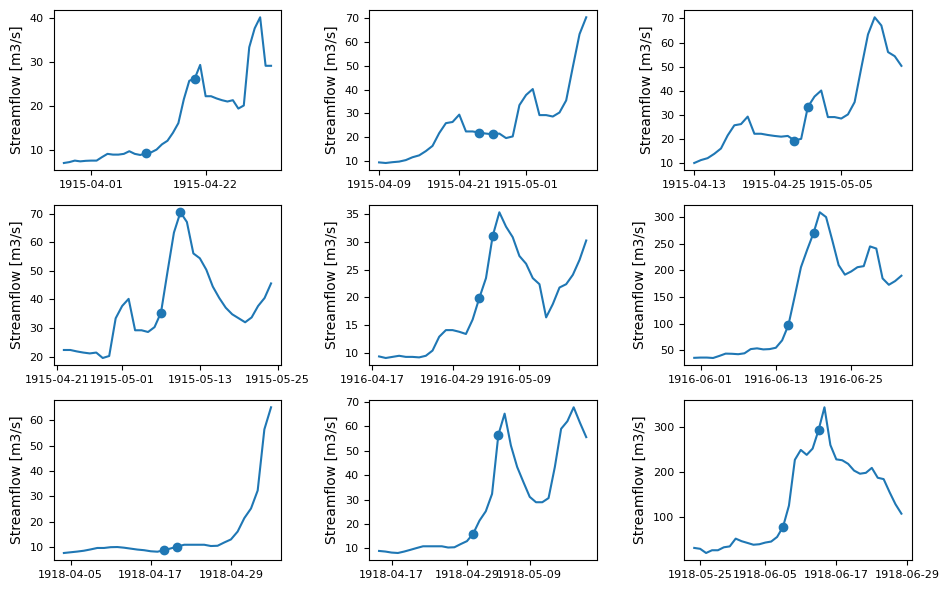

In [37]:
#visualize events

site = 'Banff'
kk_site = sites.index(site)
df_flow = df_sites['Streamflow'][site]
Q = df_flow['Value']

nrows = 3
ncols = 3

inds_freshet = np.argwhere((t_hw[kk_site] >= 190) & (t_hw[kk_site] < 270)).squeeze()
t_hw_freshet = t_hw[kk_site][inds_freshet]
hws_freshet = hws[kk_site][inds_freshet]

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3.2*ncols, 2*nrows))

for kk, ax in enumerate(axes.flatten()):
    
    kk_hw = kk+10

    window = 15

    hw_start = int(hws_freshet[kk_hw][0])
    hw_final = int(hws_freshet[kk_hw][1])
    start = int(hws_freshet[kk_hw][0] - window)
    final = int(hws_freshet[kk_hw][1] + window)
    
    ax.plot(Q[start:final])
    ax.scatter([df_flow.index[hw_start], df_flow.index[hw_final]], [Q[hw_start], Q[hw_final]])

    ax.set_xticks(ax.get_xticks()[::3])
    ax.tick_params(labelsize = 8)
    ax.set_ylabel('Streamflow [m3/s]')

plt.tight_layout()
    
plt.show()

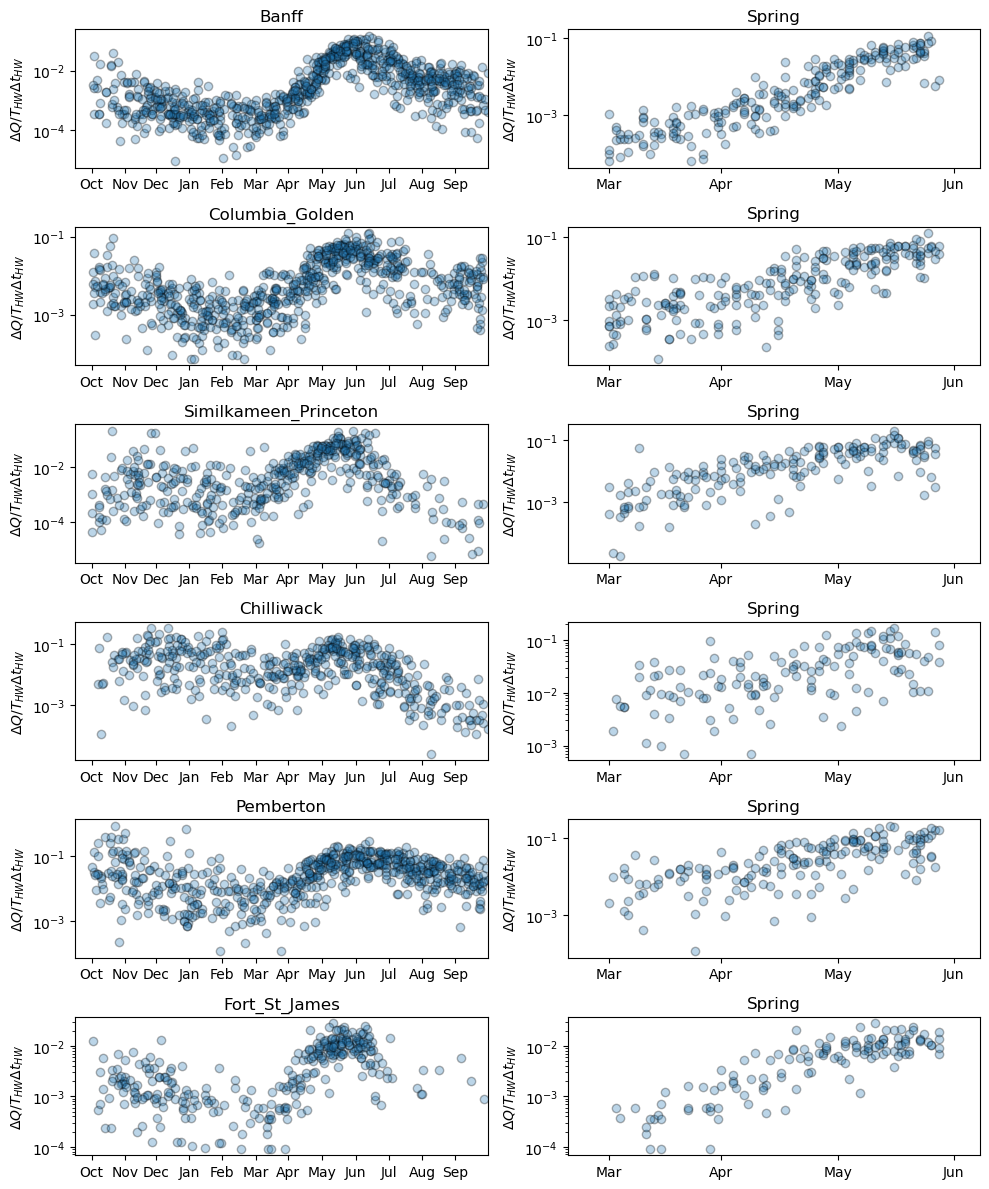

In [38]:
nrows = Nsites
ncols = 2

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 2*nrows))

for kk_site, site in enumerate(sites):

    var1 = t_hw[kk_site]
    var2 = dQdT_hw[kk_site]

    axes[kk_site,0].scatter(var1,var2, edgecolor = 'k', alpha = 0.3)
    axes[kk_site,0].set_xlim(left = -15,right = 364)
    # axes[0].scatter(var1, var2)
    axes[kk_site,0].set_xticks(first_days_of_month)
    axes[kk_site,0].set_xticklabels(months_str, rotation = 0)
    axes[kk_site,0].set_title(site)

    axes[kk_site,1].scatter(var1[inds_MAM[kk_site]],var2[inds_MAM[kk_site]], edgecolor = 'k', alpha = 0.3)
    axes[kk_site,1].set_xticks(first_days_of_month)
    axes[kk_site,1].set_xticklabels(months_str, rotation = 0)
    axes[kk_site,1].set_xlim(left = 140,right = 250)
    axes[kk_site,1].set_title('Spring')

for ax in axes.flatten():
    ax.set_yscale('log')
    ax.set_ylabel('$\Delta Q / T_{HW} \Delta t_{HW}$')
    
plt.tight_layout()
plt.show()

In [39]:
#calculate over rolling 30-day windows for baseline and future proxy cases

dQdT_rolling_future_proxy = np.zeros((Nsites,335))
dQdT_rolling_future_proxy_p1 = np.zeros((Nsites,335))
dQdT_rolling_future_proxy_p2 = np.zeros((Nsites,335))
dQdT_rolling_future_proxy_std = np.zeros((Nsites,335))

dQdT_rolling_baseline = np.zeros((Nsites,335))
dQdT_rolling_baseline_p1 = np.zeros((Nsites,335))
dQdT_rolling_baseline_p2 = np.zeros((Nsites,335))
dQdT_rolling_baseline_std = np.zeros((Nsites,335))

Q_future_proxy_rolling = np.zeros((Nsites,335))
Q_baseline_rolling = np.zeros((Nsites,335))
Q_diff_freshet_rolling = np.zeros((Nsites,335))

N_future_proxy_hw = np.zeros((Nsites,335))
N_baseline_hw = np.zeros((Nsites,335))
N_all_hw = np.zeros((Nsites,335))

bin_width = 30

for kk_site, site in enumerate(sites):

    for day_start in range(0,335):

        inds_bin_future_proxy = np.argwhere(
            (t_hw[kk_site][inds_future_proxy_hw[kk_site]] >= day_start) & 
            (t_hw[kk_site][inds_future_proxy_hw[kk_site]] < day_start + bin_width)
        ).squeeze()

        inds_bin_baseline = np.argwhere(
            (t_hw[kk_site][inds_baseline_hw[kk_site]] >= day_start) & 
            (t_hw[kk_site][inds_baseline_hw[kk_site]] < day_start + bin_width)
        ).squeeze()
        
        inds_bin_all = np.argwhere(
            (t_hw[kk_site] >= day_start) & 
            (t_hw[kk_site] < day_start + bin_width)
        ).squeeze()

        N_future_proxy_hw[kk_site,day_start] = np.size(inds_bin_future_proxy)
        N_baseline_hw[kk_site,day_start] = np.size(inds_bin_baseline)
        N_all_hw[kk_site,day_start] = np.size(inds_bin_all)

        if N_future_proxy_hw[kk_site,day_start] > 0:
            dQdT_rolling_future_proxy[kk_site,day_start] = np.median(dQdT_hw[kk_site][inds_future_proxy_hw[kk_site]][inds_bin_future_proxy])
            dQdT_rolling_future_proxy_p1[kk_site,day_start] = np.percentile(dQdT_hw[kk_site][inds_future_proxy_hw[kk_site]][inds_bin_future_proxy], q = 25)
            dQdT_rolling_future_proxy_p2[kk_site,day_start] = np.percentile(dQdT_hw[kk_site][inds_future_proxy_hw[kk_site]][inds_bin_future_proxy], q = 75)
            dQdT_rolling_future_proxy_std[kk_site,day_start] = np.std(dQdT_hw[kk_site][inds_future_proxy_hw[kk_site]][inds_bin_future_proxy])
        else:    
            dQdT_rolling_future_proxy[kk_site,day_start] = np.nan
            dQdT_rolling_future_proxy_p1[kk_site,day_start] = np.nan
            dQdT_rolling_future_proxy_p2[kk_site,day_start] = np.nan
            dQdT_rolling_future_proxy_std[kk_site,day_start] = np.nan

        if N_baseline_hw[kk_site,day_start] > 0:
            dQdT_rolling_baseline[kk_site,day_start] = np.median(dQdT_hw[kk_site][inds_baseline_hw[kk_site]][inds_bin_baseline])
            dQdT_rolling_baseline_p1[kk_site,day_start] = np.percentile(dQdT_hw[kk_site][inds_baseline_hw[kk_site]][inds_bin_baseline], q = 25)
            dQdT_rolling_baseline_p2[kk_site,day_start] = np.percentile(dQdT_hw[kk_site][inds_baseline_hw[kk_site]][inds_bin_baseline], q = 75)
            dQdT_rolling_baseline_std[kk_site,day_start] = np.std(dQdT_hw[kk_site][inds_baseline_hw[kk_site]][inds_bin_baseline])
        else:
            dQdT_rolling_baseline[kk_site,day_start] = np.nan
            dQdT_rolling_baseline_p1[kk_site,day_start] = np.nan
            dQdT_rolling_baseline_p2[kk_site,day_start] = np.nan
            dQdT_rolling_baseline_std[kk_site,day_start] = np.nan

        Q_future_proxy_rolling[kk_site,day_start] = np.mean(Q_future_proxy[kk_site,day_start : day_start + bin_width])
        Q_baseline_rolling[kk_site,day_start] = np.mean(Q_baseline[kk_site,day_start : day_start + bin_width])
        Q_diff_freshet_rolling[kk_site,day_start] = np.mean(Q_diff_freshet[kk_site,day_start : day_start + bin_width])
        # Q_diff_freshet_rolling[day_start] = np.mean(Q_diff_freshet[day_start : day_start + bin_width])

    dQdT_diff_rolling = dQdT_rolling_future_proxy - dQdT_rolling_baseline

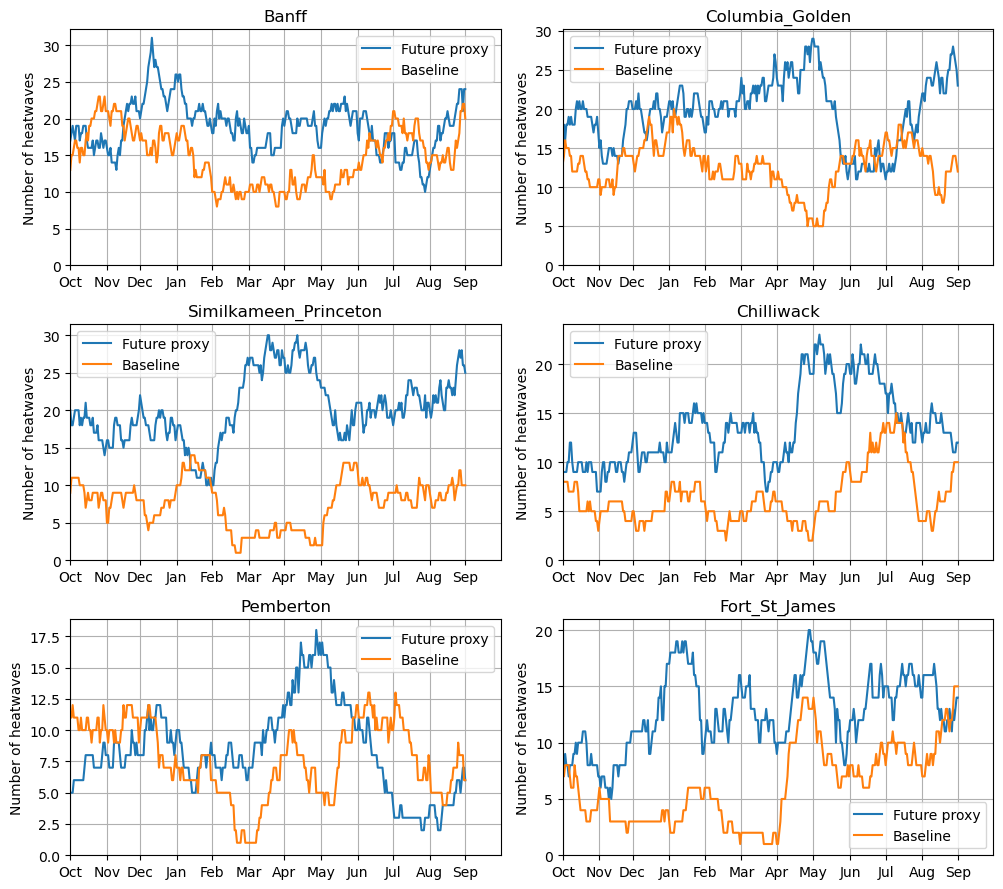

In [40]:
nrows = 3
ncols = 2

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 3*nrows))

for kk_site, ax in enumerate(axes.flatten()[:Nsites]):
    ax.plot(N_future_proxy_hw[kk_site], label = 'Future proxy')
    ax.plot(N_baseline_hw[kk_site], label = 'Baseline')
    # ax.plot(N_all_hw[kk_site], 'k', label = 'All')
    ax.set_title(sites[kk_site])
    ax.legend()
    ax.set_ylabel('Number of heatwaves')
    
for ax in axes.flatten():
    ax.set_xlim(left = 0,right = 364)
    ax.set_ylim(bottom = 0)
    ax.grid(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0)
    
plt.tight_layout()

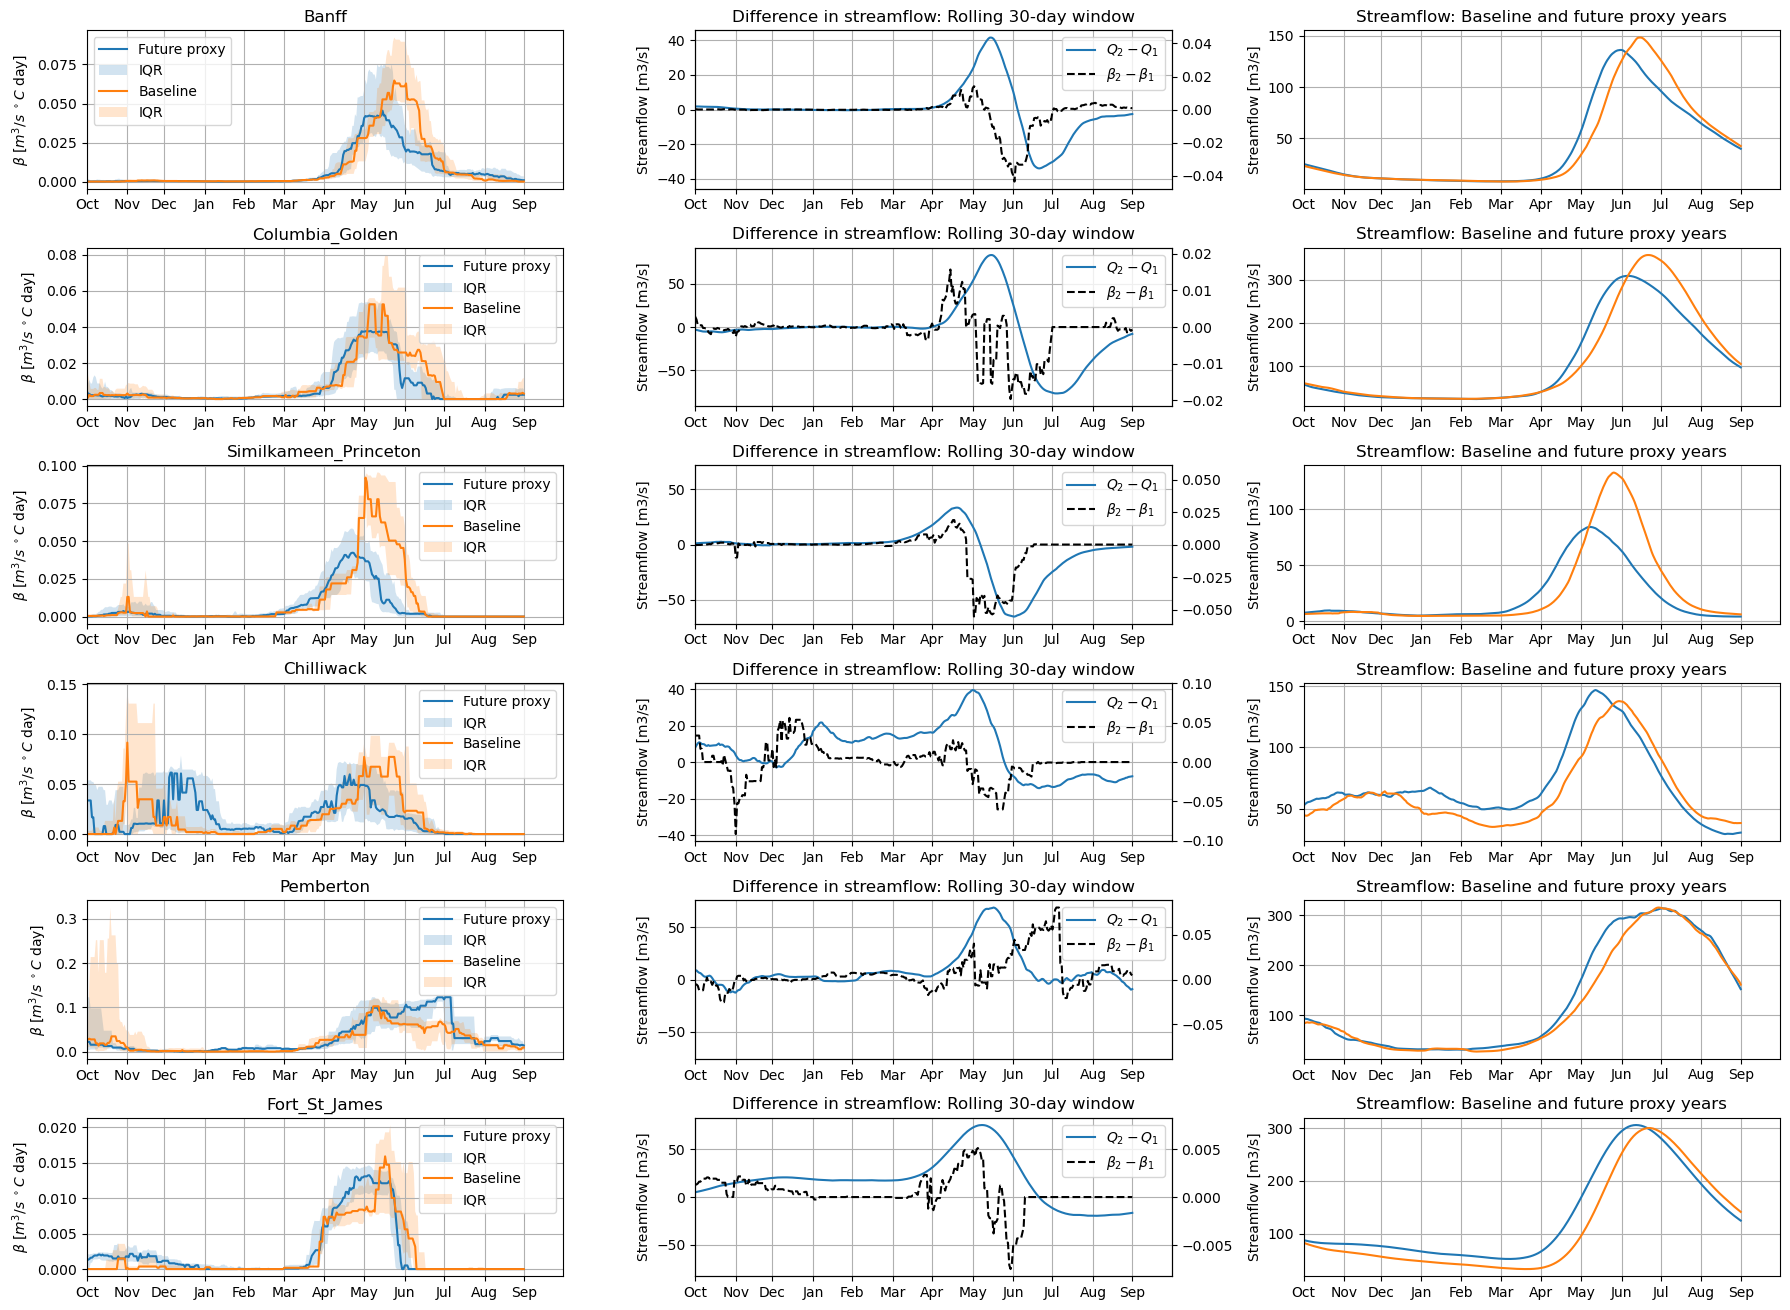

In [42]:
saveIt = 0

kk_site = 0

nrows = Nsites
ncols = 3
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (6*ncols, 2.2*nrows))

for kk_site, site in enumerate(sites):

    ax = axes[kk_site,0]
    ax.plot(dQdT_rolling_future_proxy[kk_site], label = 'Future proxy')
    ax.fill_between(x = np.arange(335), y1 = dQdT_rolling_future_proxy_p1[kk_site], y2 = dQdT_rolling_future_proxy_p2[kk_site], alpha = 0.2, label = 'IQR')
    ax.plot(dQdT_rolling_baseline[kk_site], label = 'Baseline')
    ax.fill_between(x = np.arange(335), y1 = dQdT_rolling_baseline_p1[kk_site], y2 = dQdT_rolling_baseline_p2[kk_site], alpha = 0.2, label = 'IQR')
    ax.set_ylabel('$\u03B2$ [$m^3 / s$ $^\circ C$ day]')
    ax.set_title(site)
    ax.legend()

    ax = axes[kk_site,1]
    ymax1 = 1.1*np.nanmax(np.abs(Q_diff_freshet_rolling[kk_site]))
    ymin1 = -ymax1
    ymax2 = 1.1*np.nanmax(np.abs(dQdT_diff_rolling[kk_site]))
    ymin2 = -ymax2
    l1 = ax.plot(Q_diff_freshet_rolling[kk_site], label = '$Q_2 - Q_1$')
    ax.set_title('Difference in streamflow: Rolling 30-day window')
    ax.set_ylabel('Streamflow [m3/s]')
    ax.set_ylim(bottom = ymin1, top = ymax1)
    ax2 = ax.twinx()
    l2 = ax2.plot(dQdT_diff_rolling[kk_site],'k--', label = '$\u03B2 _2 - \u03B2 _1$')
    ax2.set_ylim(bottom = ymin2, top = ymax2)
    labels = [ll.get_label() for ll in l1+l2]
    ax.legend(l1+l2,labels, loc=0)

    ax = axes[kk_site,2]
    ax.plot(Q_future_proxy_rolling[kk_site])
    ax.plot(Q_baseline_rolling[kk_site])
    ax.set_title('Streamflow: Baseline and future proxy years')
    ax.set_ylabel('Streamflow [m3/s]')


for ax in axes.flatten():
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0)
    
plt.tight_layout()

if saveIt:
    plt.savefig('dQdTdt_and_streamflow.png', dpi = 300, bbox_inches = 'tight')

plt.show()

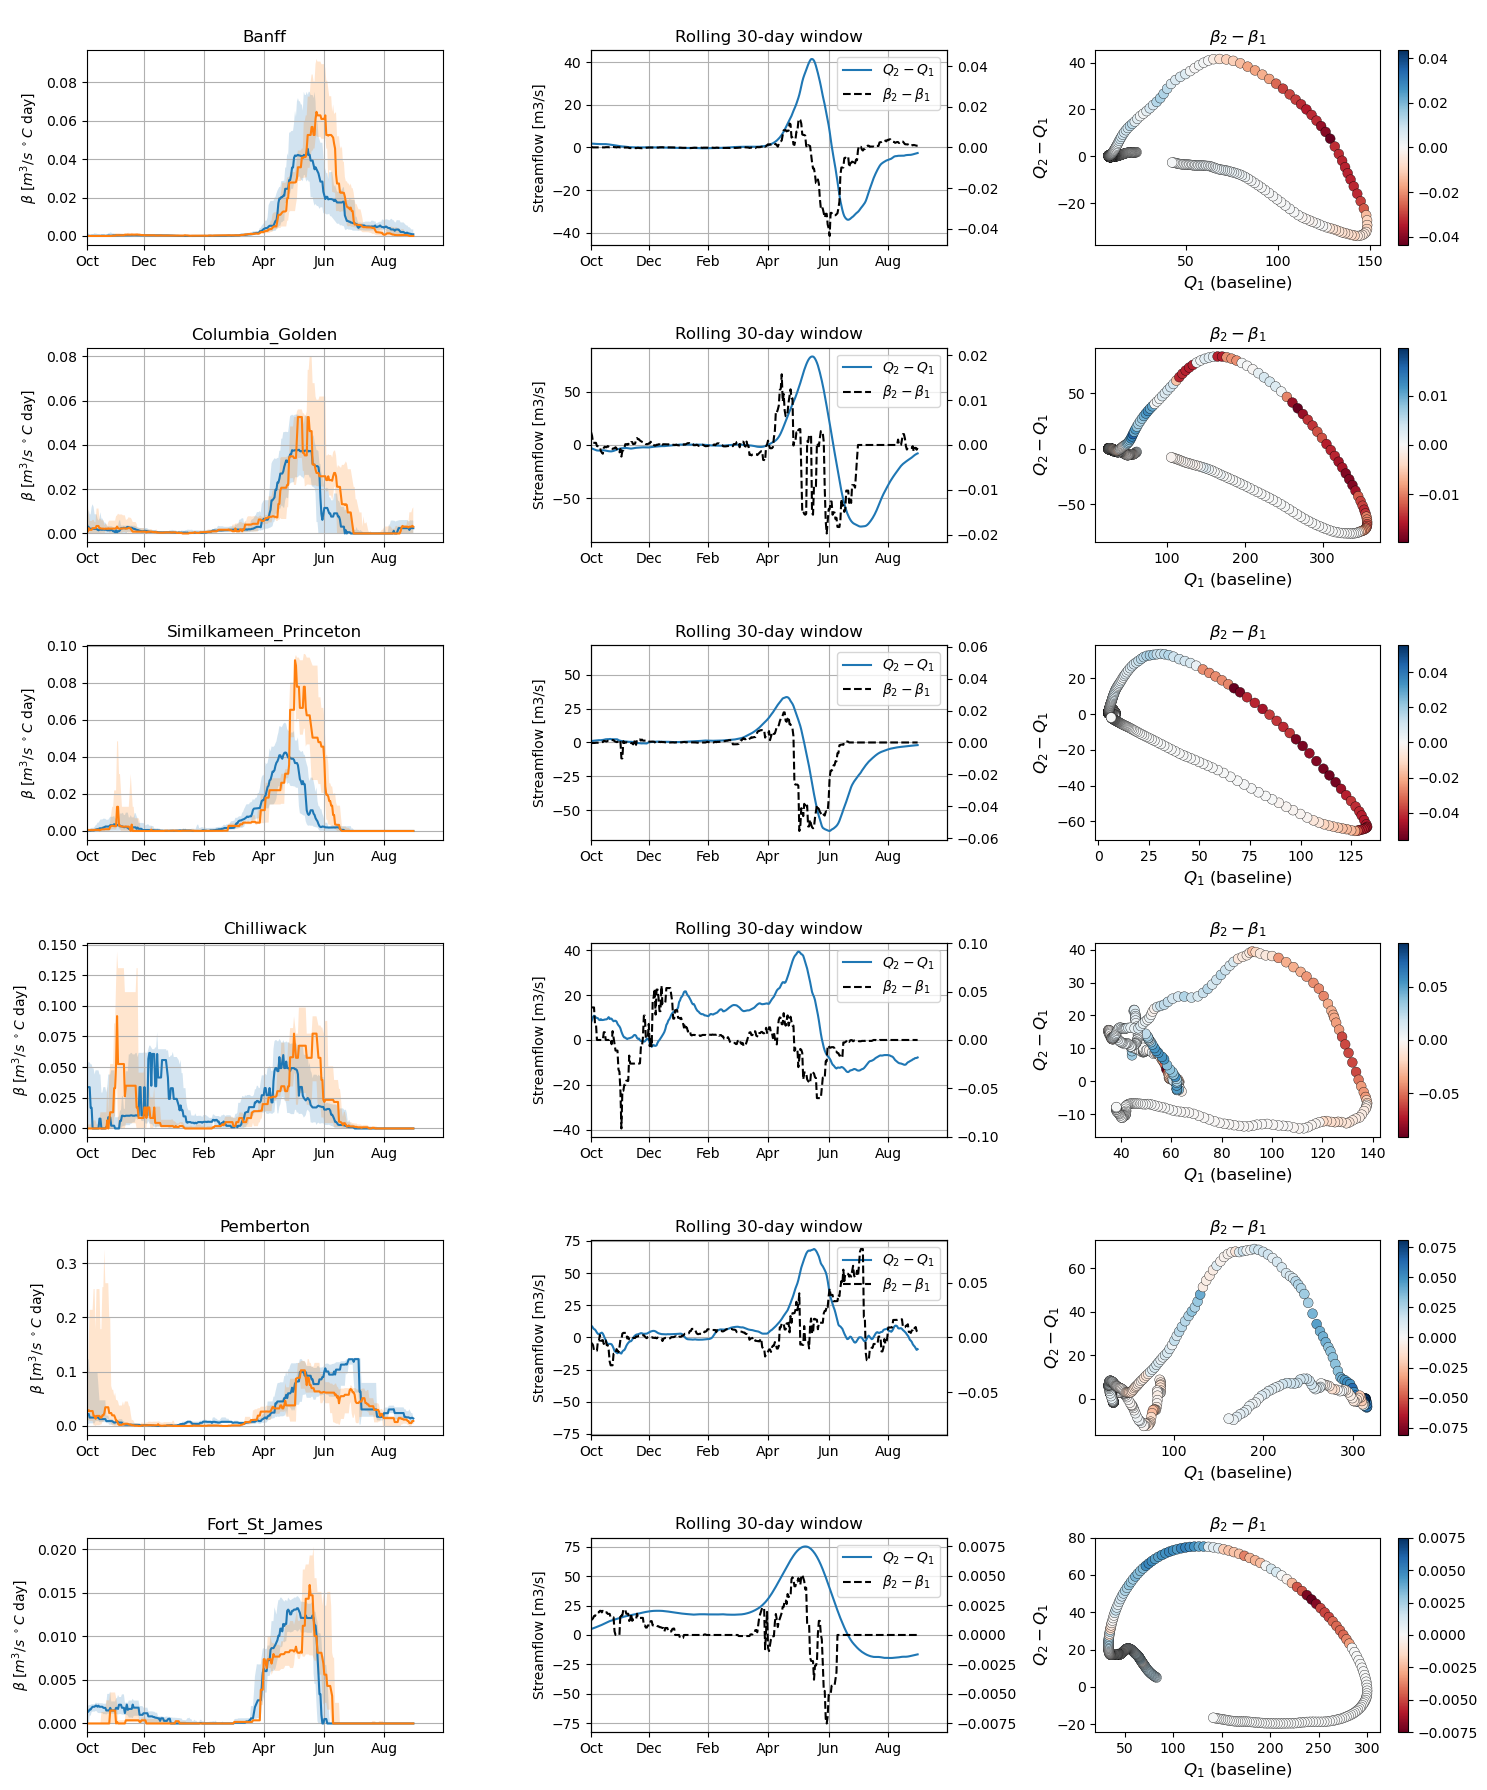

In [43]:
saveIt = 0

fs = 12

kk_site = 0

nrows = Nsites
ncols = 3

fig = plt.figure(figsize = (5*ncols,3*nrows))
gs = fig.add_gridspec(nrows = nrows, ncols = ncols)

axes_beta = [fig.add_subplot(gs[kk,0]) for kk in range(Nsites)]
axes_diff_time = [fig.add_subplot(gs[kk,1]) for kk in range(Nsites)]
axes_diff_state = [fig.add_subplot(gs[kk,2]) for kk in range(Nsites)]

for kk_site, site in enumerate(sites):

    ##### BETA THROUGH TIME
    ax = axes_beta[kk_site]
    ax.plot(dQdT_rolling_future_proxy[kk_site], label = 'Future proxy')
    ax.fill_between(x = np.arange(335), y1 = dQdT_rolling_future_proxy_p1[kk_site], y2 = dQdT_rolling_future_proxy_p2[kk_site], alpha = 0.2, label = 'IQR')
    ax.plot(dQdT_rolling_baseline[kk_site], label = 'Baseline')
    ax.fill_between(x = np.arange(335), y1 = dQdT_rolling_baseline_p1[kk_site], y2 = dQdT_rolling_baseline_p2[kk_site], alpha = 0.2, label = 'IQR')
    ax.set_ylabel('$\u03B2$ [$m^3 / s$ $^\circ C$ day]')
    ax.set_title(site)
    # ax.legend()

    ##### BETA2 - BETA1 & Q2 - Q1
    ax = axes_diff_time[kk_site]
    ymax1 = 1.1*np.nanmax(np.abs(Q_diff_freshet_rolling[kk_site]))
    ymin1 = -ymax1
    ymax2 = 1.1*np.nanmax(np.abs(dQdT_diff_rolling[kk_site]))
    ymin2 = -ymax2
    l1 = ax.plot(Q_diff_freshet_rolling[kk_site], label = '$Q_2 - Q_1$')
    ax.set_title('Rolling 30-day window')
    ax.set_ylabel('Streamflow [m3/s]')
    ax.set_ylim(bottom = ymin1, top = ymax1)
    ax2 = ax.twinx()
    l2 = ax2.plot(dQdT_diff_rolling[kk_site],'k--', label = '$\u03B2 _2 - \u03B2 _1$')
    ax2.set_ylim(bottom = ymin2, top = ymax2)
    labels = [ll.get_label() for ll in l1+l2]
    ax.legend(l1+l2,labels, loc=0)
    
    ##### Q_DIFF VS Q1 BY BETA_DIFF
    ax = axes_diff_state[kk_site]
    vmax = np.max(np.abs(dQdT_diff_rolling[kk_site]))
    vmin = -vmax
    s = ax.scatter(x = Q_baseline_rolling[kk_site], 
                y = Q_diff_freshet_rolling[kk_site], 
                c = dQdT_diff_rolling[kk_site],
                edgecolor = 'k',
                linewidth = 0.25,
                cmap = 'RdBu',
                vmax = vmax, 
                vmin = vmin,
                s = 50
               )
    ax.set_xlabel('$Q_1$ (baseline)', fontsize = fs)
    ax.set_ylabel('$Q_2-Q_1$', fontsize = fs)
    ax.set_title('\n$\u03B2 _2 - \u03B2 _1$')

    cbar = plt.colorbar(s,ax=ax)
    # cbar.ax.set_ylabel('$\u03B2 _2 - \u03B2 _1$')
    
    ax.tick_params(labelsize = fs-2)
    cbar.ax.tick_params(labelsize = fs-2)

for ax in axes_beta:
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_xticks(first_days_of_month[::2])
    ax.set_xticklabels(months_str[::2], rotation = 0)
    
for ax in axes_diff_time:
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_xticks(first_days_of_month[::2])
    ax.set_xticklabels(months_str[::2], rotation = 0)
    
plt.tight_layout()

if saveIt:
    plt.savefig('Figures/dQdTdt_and_streamflow.png', dpi = 300, bbox_inches = 'tight')

plt.show()

In [44]:
sites_short = [
    'Bow River',
    'Columbia River',
    'Similkameen River',
    'Chilliwack River',
    'Lillooet River',
    'Stuart River'
]

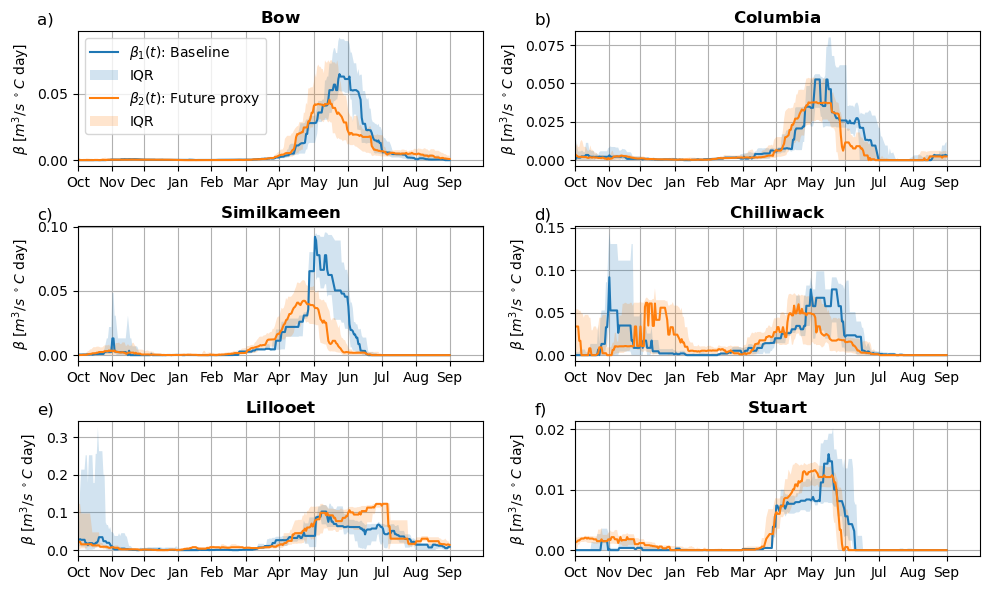

In [45]:
saveIt = 0

fs = 12

kk_site = 0

nrows = 3
ncols = 2

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 2*nrows))

for kk_site, ax in enumerate(axes.flatten()):

    ax.plot(dQdT_rolling_baseline[kk_site], label = '$\u03B2_1(t)$: Baseline')
    ax.fill_between(x = np.arange(335), y1 = dQdT_rolling_baseline_p1[kk_site], y2 = dQdT_rolling_baseline_p2[kk_site], alpha = 0.2, label = 'IQR')
    ax.plot(dQdT_rolling_future_proxy[kk_site], label = '$\u03B2_2(t)$: Future proxy')
    ax.fill_between(x = np.arange(335), y1 = dQdT_rolling_future_proxy_p1[kk_site], y2 = dQdT_rolling_future_proxy_p2[kk_site], alpha = 0.2, label = 'IQR')
    ax.set_ylabel('$\u03B2$ [$m^3 / s$ $^\circ C$ day]')
    ax.set_title(r'$\bf{' + sites_short[kk_site][:-5] + '}$')
    if kk_site == 0:
        ax.legend(loc = 'upper left')
    ax.text(x = -0.1, y = 1.05, s = abc[kk_site], transform = ax.transAxes, fontsize = fs)


for ax in axes.flatten():
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0)
    
plt.tight_layout()

if saveIt:
    plt.savefig('Figures/Supplementary/dQdTdt_all_sites_80p.png', dpi = 300, bbox_inches = 'tight')

plt.show()

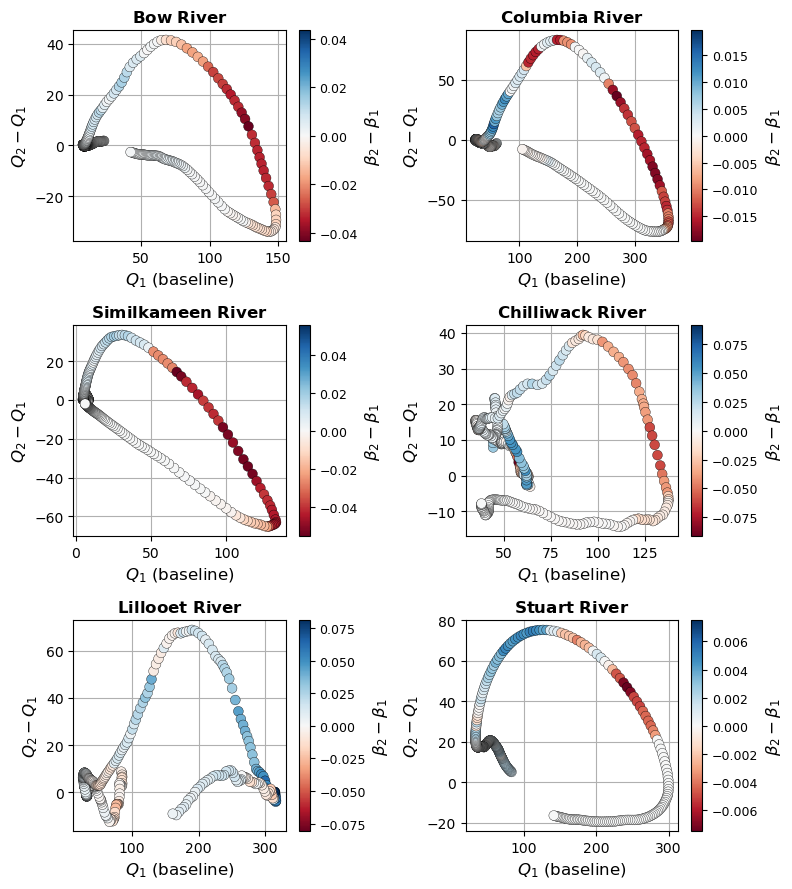

In [46]:
saveIt = 0

fs = 12

kk_site = 0

nrows = 3
ncols = 2

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 3*nrows))

for kk_site, ax in enumerate(axes.flatten()):

    vmax = np.max(np.abs(dQdT_diff_rolling[kk_site]))
    vmin = -vmax
    s = ax.scatter(x = Q_baseline_rolling[kk_site], 
                y = Q_diff_freshet_rolling[kk_site], 
                c = dQdT_diff_rolling[kk_site],
                edgecolor = 'k',
                linewidth = 0.25,
                cmap = 'RdBu',
                vmax = vmax, 
                vmin = vmin,
                s = 50
               )
    ax.set_xlabel('$Q_1$ (baseline)', fontsize = fs)
    ax.set_ylabel('$Q_2-Q_1$', fontsize = fs)
    ax.set_title(r'$\bf{' + sites_short[kk_site][:-5] + '}$' + ' ' + r'$\bf{' + sites_short[kk_site][-5:] + '}$')

    cbar = plt.colorbar(s,ax=ax)
    # cbar.ax.set_ylabel('$\u03B2 _2 - \u03B2 _1$')
    
    ax.tick_params(labelsize = fs-2)
    cbar.ax.tick_params(labelsize = fs-3)
    cbar.ax.set_ylabel('$\u03B2 _2 - \u03B2 _1$', fontsize = fs)


for ax in axes.flatten():
    # ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_axisbelow(True)
    
plt.tight_layout()

if saveIt:
    plt.savefig('Figures/Supplementary/dQdTdt_by_Qdiff_Q_all_sites.png', dpi = 300, bbox_inches = 'tight')

plt.show()

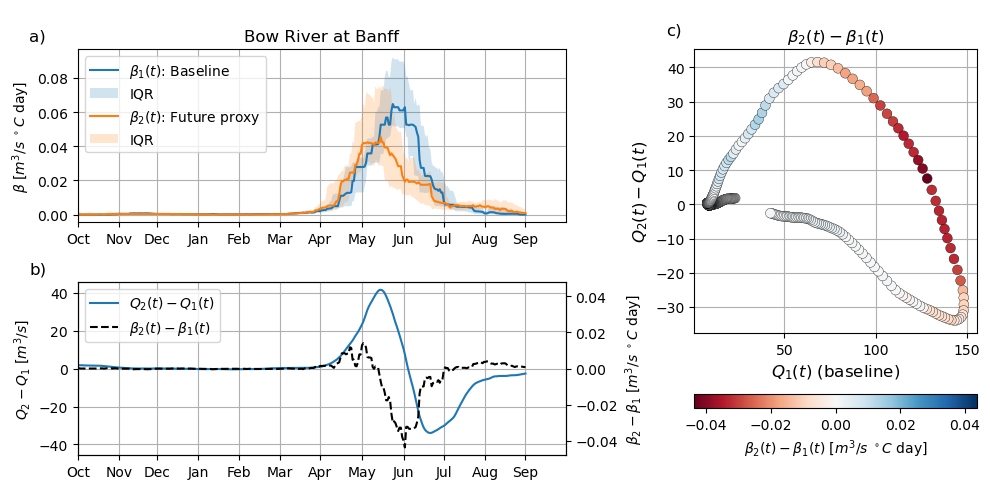

In [47]:
saveIt = 0

kk_site = 0

nrows = 2
ncols = 5

fig = plt.figure(figsize = (2*ncols,2.5*nrows))
gs = fig.add_gridspec(nrows = nrows, ncols = ncols)

axes_beta = [fig.add_subplot(gs[0,:3]) for kk in range(1)]
axes_diff_time = [fig.add_subplot(gs[1,:3]) for kk in range(1)]
axes_diff_state = [fig.add_subplot(gs[:,3:]) for kk in range(1)]

for kk_site, site in enumerate(sites[:1]):

    ##### BETA THROUGH TIME
    ax = axes_beta[kk_site]
    ax.plot(dQdT_rolling_baseline[kk_site], label = '$\u03B2_1(t)$: Baseline')
    ax.fill_between(x = np.arange(335), y1 = dQdT_rolling_baseline_p1[kk_site], y2 = dQdT_rolling_baseline_p2[kk_site], alpha = 0.2, label = 'IQR')
    ax.plot(dQdT_rolling_future_proxy[kk_site], label = '$\u03B2_2(t)$: Future proxy')
    ax.fill_between(x = np.arange(335), y1 = dQdT_rolling_future_proxy_p1[kk_site], y2 = dQdT_rolling_future_proxy_p2[kk_site], alpha = 0.2, label = 'IQR')
    ax.set_ylabel('$\u03B2$ [$m^3 / s$ $^\circ C$ day]')
    ax.set_title('Bow River at Banff', fontsize = fs)
    ax.legend(loc = 'upper left')
    ax.text(x = -0.1, y = 1.05, s = abc[0], transform = ax.transAxes, fontsize = fs)

    ##### BETA2 - BETA1 & Q2 - Q1
    ax = axes_diff_time[kk_site]
    ymax1 = 1.1*np.nanmax(np.abs(Q_diff_freshet_rolling[kk_site]))
    ymin1 = -ymax1
    ymax2 = 1.1*np.nanmax(np.abs(dQdT_diff_rolling[kk_site]))
    ymin2 = -ymax2
    l1 = ax.plot(Q_diff_freshet_rolling[kk_site], label = '$Q_2(t) - Q_1(t)$')
    # ax.set_title('Difference in streamflow')
    ax.set_ylabel('$Q_2 - Q_1$ [$m^3/s$]')
    ax.set_ylim(bottom = ymin1, top = ymax1)
    ax2 = ax.twinx()
    l2 = ax2.plot(dQdT_diff_rolling[kk_site],'k--', label = '$\u03B2 _2(t) - \u03B2 _1(t)$')
    ax2.set_ylim(bottom = ymin2, top = ymax2)
    ax2.set_ylabel('$\u03B2 _2 - \u03B2 _1$ [$m^3 / s$ $^\circ C$ day]')
    labels = [ll.get_label() for ll in l1+l2]
    ax.legend(l1+l2,labels, loc='upper left')
    ax.text(x = -0.1, y = 1.05, s = abc[1], transform = ax.transAxes, fontsize = fs)
    
    ##### Q_DIFF VS Q1 BY BETA_DIFF
    ax = axes_diff_state[kk_site]
    ax.grid(True)
    ax.set_axisbelow(True)
    vmax = np.max(np.abs(dQdT_diff_rolling[kk_site]))
    vmin = -vmax
    s = ax.scatter(x = Q_baseline_rolling[kk_site], 
                y = Q_diff_freshet_rolling[kk_site], 
                c = dQdT_diff_rolling[kk_site],
                edgecolor = 'k',
                linewidth = 0.25,
                cmap = 'RdBu',
                vmax = vmax, 
                vmin = vmin,
                s = 50
               )
    ax.set_xlabel('$Q_1(t)$ (baseline)', fontsize = fs)
    ax.set_ylabel('$Q_2(t)-Q_1(t)$', fontsize = fs)
    ax.set_title('\n$\u03B2 _2(t) - \u03B2 _1(t)$')
    ax.text(x = -0.1, y = 1.05, s = abc[2], transform = ax.transAxes, fontsize = fs)
    
    cbar = plt.colorbar(s,ax=ax, orientation = 'horizontal')
    ax.tick_params(labelsize = fs-2)
    cbar.ax.tick_params(labelsize = fs-2)
    cbar.ax.set_xlabel('$\u03B2 _2(t) - \u03B2 _1(t)$ [$m^3 / s$ $^\circ C$ day]')

for ax in axes_beta:
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0)
    
for ax in axes_diff_time:
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0)
    
plt.tight_layout(w_pad = -1.)

if saveIt:
    plt.savefig('Figures/dQdTdt_and_streamflow.png', dpi = 300, bbox_inches = 'tight')

plt.show()

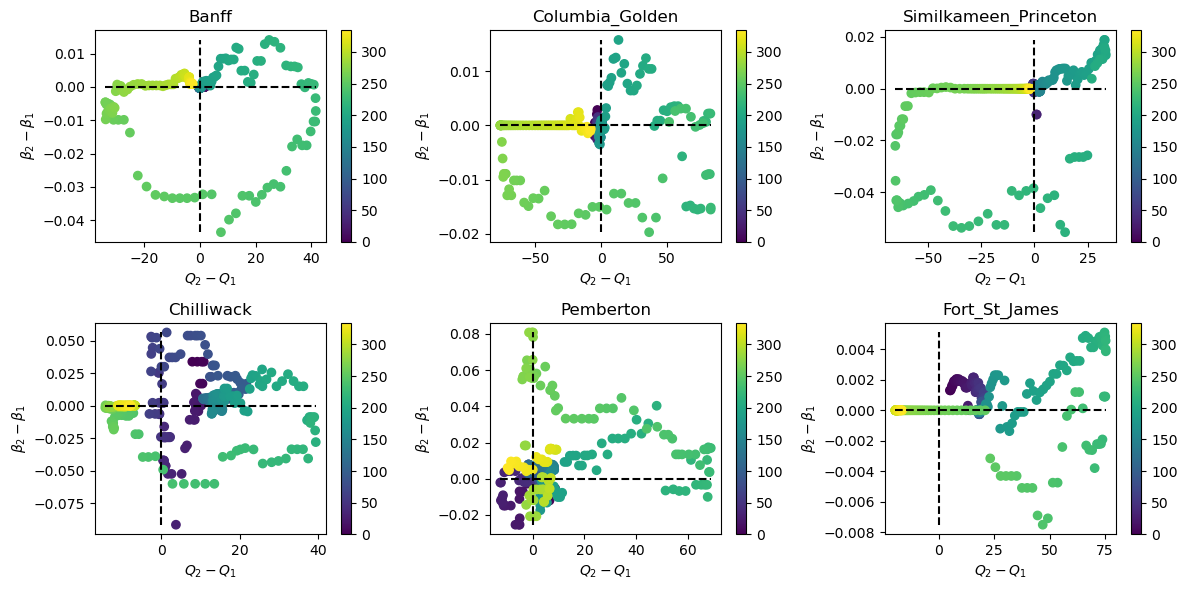

In [49]:
#sensitivity change vs underlying flow change for each day of year

nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 3*nrows))

for kk_site, ax in enumerate(axes.flatten()[:Nsites]):

    x = Q_diff_freshet_rolling[kk_site]
    y = dQdT_diff_rolling[kk_site]
    c = np.arange(335)

    s = ax.scatter(x, y, c = c)
    ax.plot([0,0],[np.nanmin(y), np.nanmax(y)], 'k--')
    ax.plot([np.nanmin(x), np.nanmax(x)],[0,0], 'k--')
    ax.set_xlabel('$Q_2-Q_1$')
    ax.set_ylabel('$\u03B2 _2 - \u03B2 _1$')
    plt.colorbar(s, ax=ax)
    ax.set_title(sites[kk_site])
    
plt.tight_layout()

In [50]:
print('HEATWAVE DURATION')
for kk_site in range(Nsites):
    print(sites_short[kk_site])
    print('\tMean: ' + str(np.round(np.mean(hwd[kk_site]), decimals = 2)) + ' days')
    print('\tMedian: ' + str(np.round(np.median(hwd[kk_site]), decimals = 2)) + ' days')
    print('\tStdDev: ' + str(np.round(np.std(hwd[kk_site]), decimals = 2)) + ' days')
    print('\tMin: ' + str(np.round(np.min(hwd[kk_site]), decimals = 2)) + ' days')
    print('\tMax: ' + str(np.round(np.max(hwd[kk_site]), decimals = 2)) + ' days')

HEATWAVE DURATION
Bow River
	Mean: 4.7 days
	Median: 4.0 days
	StdDev: 2.22 days
	Min: 3.0 days
	Max: 18.0 days
Columbia River
	Mean: 5.04 days
	Median: 4.0 days
	StdDev: 2.68 days
	Min: 3.0 days
	Max: 24.0 days
Similkameen River
	Mean: 4.72 days
	Median: 4.0 days
	StdDev: 2.49 days
	Min: 3.0 days
	Max: 25.0 days
Chilliwack River
	Mean: 4.52 days
	Median: 4.0 days
	StdDev: 1.98 days
	Min: 3.0 days
	Max: 15.0 days
Lillooet River
	Mean: 5.54 days
	Median: 4.0 days
	StdDev: 3.48 days
	Min: 3.0 days
	Max: 33.0 days
Stuart River
	Mean: 4.51 days
	Median: 4.0 days
	StdDev: 2.19 days
	Min: 3.0 days
	Max: 28.0 days


In [51]:
print('HEATWAVE MAGNITUDE')
for kk_site in range(Nsites):
    print(sites_short[kk_site])
    print('\tMean: ' + str(np.round(np.mean(hwm[kk_site]), decimals = 2)) + ' C')
    print('\tMedian: ' + str(np.round(np.median(hwm[kk_site]), decimals = 2)) + ' C')
    print('\tStdDev: ' + str(np.round(np.std(hwm[kk_site]), decimals = 2)) + ' C')
    print('\tMin: ' + str(np.round(np.min(hwm[kk_site]), decimals = 2)) + ' C')
    print('\tMax: ' + str(np.round(np.max(hwm[kk_site]), decimals = 2)) + ' C')

HEATWAVE MAGNITUDE
Bow River
	Mean: 2.28 C
	Median: 2.1 C
	StdDev: 1.09 C
	Min: 0.33 C
	Max: 7.5 C
Columbia River
	Mean: 1.97 C
	Median: 1.83 C
	StdDev: 0.94 C
	Min: 0.17 C
	Max: 5.91 C
Similkameen River
	Mean: 1.96 C
	Median: 1.77 C
	StdDev: 0.93 C
	Min: 0.23 C
	Max: 6.8 C
Chilliwack River
	Mean: 2.02 C
	Median: 1.84 C
	StdDev: 1.02 C
	Min: 0.23 C
	Max: 6.32 C
Lillooet River
	Mean: 1.54 C
	Median: 1.42 C
	StdDev: 0.79 C
	Min: 0.13 C
	Max: 4.61 C
Stuart River
	Mean: 2.26 C
	Median: 2.03 C
	StdDev: 1.08 C
	Min: 0.23 C
	Max: 7.72 C


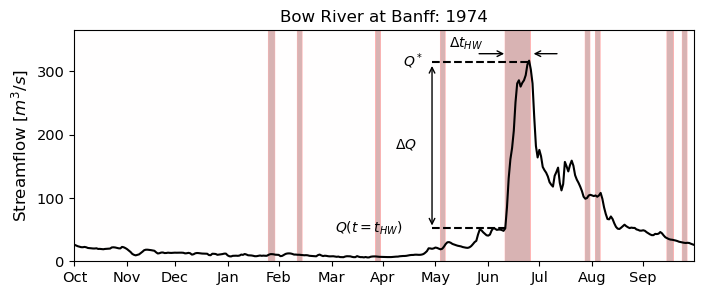

In [52]:
saveIt = 0

year = 63

fig, ax = plt.subplots(figsize = (8,3))

##### SINGLE HEATWAVE LABELLED

heatwave_vec = np.zeros(365)
hws_this_year = np.argwhere(hw_year[0]==year+data_start_years[0]+1).squeeze()
for hw in hws_this_year:
    heatwave_vec[int(t_hw[0][hw]):int(t_hw[0][hw]+hwd[0][hw])] = 1
    
ax.imshow(heatwave_vec.reshape(1,-1), aspect = 'auto', extent = [0,365,0,365], cmap = 'seismic', vmin = -1, alpha = 0.3)
ax.plot(Qyearly[0][year,:], 'k')

tt = int(t_hw[0][hws_this_year[4]])
ttf = tt + int(hwd[0][hws_this_year[4]])
Q_t_hw = Qyearly[0][year,tt]
Q_star = Qyearly[0][year,ttf]

ax.plot([210, tt], [Q_t_hw, Q_t_hw], 'k--')
ax.plot([210, ttf], [Q_star+12, Q_star+12], 'k--')

ax.text(x = 153, y = Q_t_hw-6, s = '$Q(t=t_{HW})$')
ax.text(x = 193, y = Q_star+5, s = '$Q^*$')
ax.text(x = 188, y = 0.5*(Q_star - Q_t_hw) + Q_t_hw, s = '$\Delta Q$')
ax.text(x = 220, y = 338, s = '$\Delta t_{HW}$')
ax.annotate(text = '', xy = (210,Q_t_hw), xytext = (210,Q_star+10), arrowprops=dict(arrowstyle="<->"))
ax.annotate(text = '', xy = (236,328), xytext = (tt+1,328), arrowprops=dict(arrowstyle="<-"))
ax.annotate(text = '', xy = (285,328), xytext = (ttf-0,328), arrowprops=dict(arrowstyle="<-"))

ax.set_ylabel('Streamflow [$m^3/s$]', fontsize = fs)
ax.set_title('Bow River at Banff: ' + str(year + data_start_years[0] + 1), fontsize = fs)

ax.set_xlim(left = 0,right = 364)
ax.set_ylim(top = 365)
ax.set_xticks(first_days_of_month)
ax.set_xticklabels(months_str, rotation = 0, fontsize = fs-2)
ax.tick_params(labelsize = fs-1.5)

if saveIt:
    plt.savefig('Figures/Q_labels.png', dpi = 400, bbox_inches = 'tight')

plt.show()

# Streamflow math  

#### Definitions

$Q^*$: Largest streamflow achieved during heatwave  
$Q(t=t_{HW})$: Streamflow at time of heatwave onset  
$t_{HW}$: Day of heatwave onset    
$T$: Temperature during heatwave  
$\Delta t$: Heatwave duration  
$\Delta Q$: Streamflow increase during heatwave  
$\beta$: Streamflow sensitivity to heatwave  
$\beta=\Delta Q/T\Delta t$
  

#### Case 1: Baseline   
$\underbrace{Q^*_1}_{peak} = \underbrace{Q_1(t=t_{HW})}_{seasonal} + \underbrace{\beta _1T_{1}\Delta t_1}_{heatwave}$  
  
Fraction heatwave $=\beta _1T_{1}\Delta t_1$ / $Q^*_1$  
  

#### Case 2: Future proxy
$\underbrace{Q^*_2}_{peak} = \underbrace{Q_2(t=t_{HW})}_{seasonal} + \underbrace{\beta _2T_{2}\Delta t_2}_{heatwave}$  
  
Fraction heatwave $=\beta _2T_{2}\Delta t_2$ / $Q^*_2$  
  

#### Plane equation
$\underbrace{Q^*_2 - Q^*_1}_{\Delta peak flow} = \underbrace{Q_2(t=t_{HW}) - Q_1(t=t_{HW})}_{\Delta seasonal} + \underbrace{\beta _2T_{2}\Delta t_2 - \beta _1T_{1}\Delta t_1}_{\Delta heatwave}$  
  
$z = ax+by+c$  
$z = Q^*_2 - Q^*_1$  
$a = - \beta _1(t)$  
$b = \beta _2(t)$  
$c = Q_2(t=t_{HW}) - Q_1(t=t_{HW})$  
$x = T_{1}\Delta t_1$  
$y = T_{2}\Delta t_2$  


# Seasonal and heatwave reservoirs / fractions

In [53]:
#calculate planes for each day

beta1 = np.zeros((Nsites, 335))
beta2 = np.zeros((Nsites, 335))
a = np.zeros((Nsites, 335))
b = np.zeros((Nsites, 335))
c = np.zeros((Nsites, 335))

Nx = 25
Ny = 25
Nt = len(a[0,:])

xmax = 2500
ymax = 2500

x = np.linspace(0,xmax,Nx)
y = np.linspace(0,ymax,Ny)
z = np.zeros((Nsites,Ny,Nx,Nt)) #rows x columns x time
y0 = np.zeros((Nsites,Nx,Nt)) #solution that sets z = 0
t_hw_x = np.zeros((Nsites,Nx,Nt))

for kk_site in range(Nsites):

    beta1[kk_site,:] = dQdT_rolling_baseline[kk_site]
    beta2[kk_site,:] = dQdT_rolling_future_proxy[kk_site]
    a[kk_site,:] = -beta1[kk_site,:]
    b[kk_site,:] = beta2[kk_site,:]
    c[kk_site,:] = Q_diff_freshet_rolling[kk_site]

    for kt in range(Nt):
        for kx in range(Nx):
            
            t_hw_x[kk_site,kx,kt] = x[kx] / (Tmean_90[kk_site][kt] + 273)
            
            y0[kk_site,kx,kt] = -(a[kk_site,kt]/b[kk_site,kt])*x[kx] - (c[kk_site,kt]/b[kk_site,kt])
            for ky in range(Ny):
                z[kk_site,ky,kx,kt] = a[kk_site,kt]*x[kx] + b[kk_site,kt]*y[ky] + c[kk_site,kt] #z = ax + by + c

In [54]:
#consider fast (heatwave) and slow (seasonal) reservoirs in baseline (1) and future proxy years (2)

fast1 = np.zeros((Nsites,Nx,335))
fast2 = np.zeros((Nsites,Nx, 335))
frac_fast_baseline = np.zeros((Nsites,Nx,335))
frac_fast_future_proxy = np.zeros((Nsites,Nx,335))

for kk_site in range(Nsites):
    for kx in range(Nx):

        fast1[kk_site,kx,:] = (a[kk_site,:]*x[kx]) 
        fast2[kk_site,kx,:] = (b[kk_site,:]*y[kx])

        frac_fast_baseline[kk_site,kx,:] = -fast1[kk_site,kx,:] / (-fast1[kk_site,kx,:] + Q_baseline_rolling[kk_site,:])
        frac_fast_future_proxy[kk_site,kx,:] = fast2[kk_site,kx,:] / (fast2[kk_site,kx,:] + Q_future_proxy_rolling[kk_site,:])

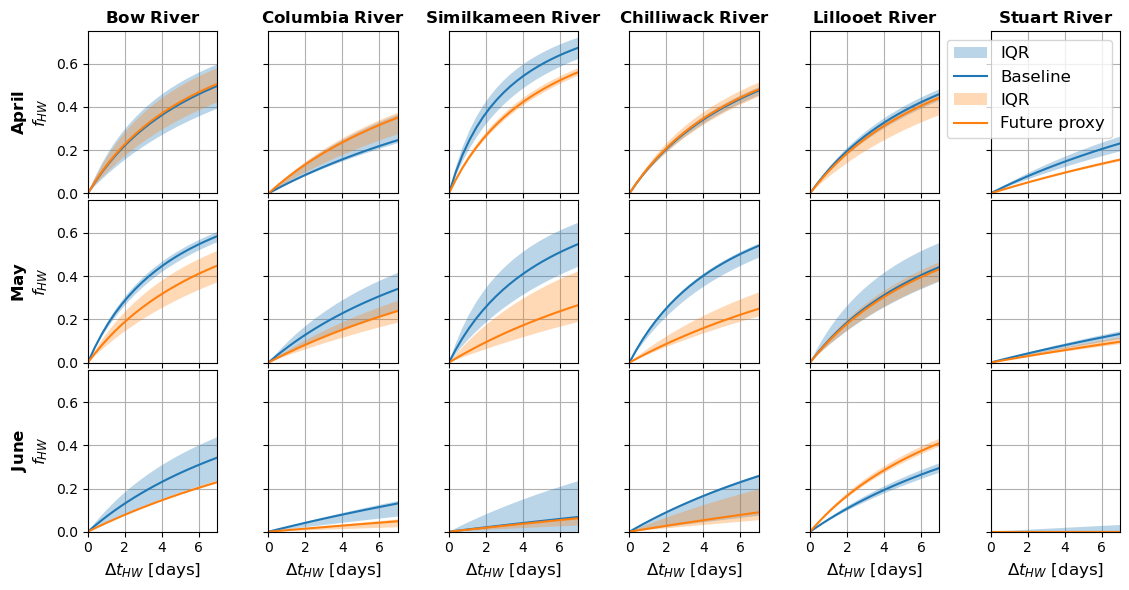

In [56]:
saveIt = 0

kk_months = [6,7,8]

labels = ['April', 'May', 'June']

ncols = Nsites
nrows = len(kk_months)
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (1.9*ncols, 2*nrows))

for kk_site in range(Nsites):
    
    for kk_ax, kk_month in enumerate(kk_months):

        ax = axes[kk_ax,kk_site]

        kk_days = np.arange(kk_month*30,(kk_month+1)*30)
        
        vars = [frac_fast_baseline[kk_site], frac_fast_future_proxy[kk_site]]

        var1 = np.median(vars[0][:,kk_days], axis = 1)
        var1p1 = np.percentile(vars[0][:,kk_days], q = 25, axis = 1)
        var1p2 = np.percentile(vars[0][:,kk_days], q = 75, axis = 1)
        var2 = np.median(vars[1][:,kk_days], axis = 1)
        var2p1 = np.percentile(vars[1][:,kk_days], q = 25, axis = 1)
        var2p2 = np.percentile(vars[1][:,kk_days], q = 75, axis = 1)
        
        t_hw_xx = np.mean(t_hw_x[kk_site,:,kk_days], axis = 0)

        ax.fill_between(x = t_hw_xx, y1 = var1p1, y2 = var1p2, alpha = 0.3, label = 'IQR')
        ax.plot(t_hw_xx,var1, label = 'Baseline')

        ax.fill_between(x = t_hw_xx, y1 = var2p1, y2 = var2p2, alpha = 0.3, label = 'IQR')
        ax.plot(t_hw_xx,var2, label = 'Future proxy')

        if kk_month == kk_months[0]:
            ax.set_title(r'$\bf{' + sites_short[kk_site][:-5] + '}$' + ' ' + r'$\bf{' + sites_short[kk_site][-5:] + '}$')
            
            if kk_site == Nsites-1:
                ax.legend(fontsize = fs)

        ax.set_xlim(left = 0, right = 7)
        ax.set_xticks(np.arange(7)[::2])
        ax.set_yticks(np.linspace(0,0.7,8)[::2])
        ax.set_ylim(bottom = 0, top = 0.75)
        
        ax.grid(True)
        ax.set_axisbelow(True)
        
        if kk_ax < 2: #remove x tick labels for all but bottom row
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('$\Delta t_{HW}$ [days]', fontsize = fs)
        if kk_site > 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(r'$\bf{' + labels[kk_ax] + '}$\n$f_{HW}$', fontsize = fs)# = \u03B2$ $T_{HW}\Delta t_{HW}$ / $Q^*$')
            
plt.tight_layout(h_pad = -0.1, w_pad = 0.3)

if saveIt:
    plt.savefig('Figures/frac_fast.png', dpi = 300, bbox_inches = 'tight')
    
plt.show()

Implication: 

April: frac_slow (future) > frac_slow (baseline) --> greater proportion of early spring flows originating from short-term fluctuations  
May: frac_slow (future) < frac_slow (baseline) --> lesser proportion of late spring flows originating from short-term fluctuations

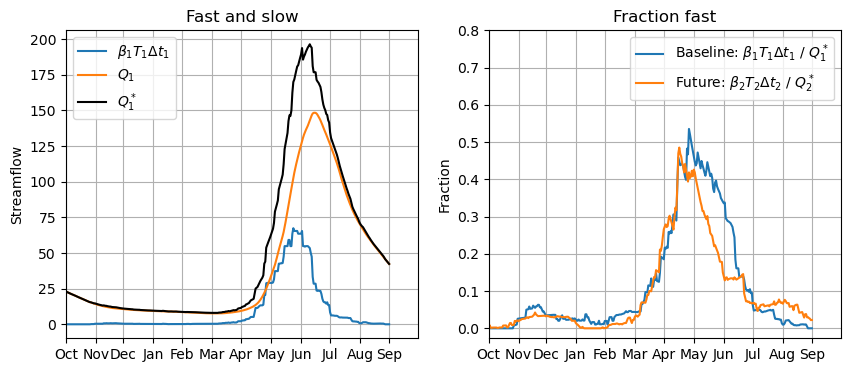

In [57]:
#visualize fast fraction

kk_site = 0
kx = 10

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))

ax = axes[0]
ax.plot(-fast1[kk_site,kx,:], label = '$\u03B2 _1T_{1}\Delta t_{1}$')
ax.plot(Q_baseline_rolling[kk_site], label = '$Q_1$')
ax.plot(-fast1[kk_site,kx,:] + Q_baseline_rolling[kk_site], label = '$Q^*_1$', color = 'k')
ax.set_ylabel('Streamflow')
ax.set_title('Fast and slow')
ax.legend()

ax = axes[1]
ax.plot(frac_fast_baseline[kk_site,kx,:], label = 'Baseline: $\u03B2 _1T_{1}\Delta t_{1}$ / $Q^*_1$')
ax.plot(frac_fast_future_proxy[kk_site,kx,:], label = 'Future: $\u03B2 _2T_{2}\Delta t_{2}$ / $Q^*_2$')
ax.set_ylabel('Fraction')
ax.set_title('Fraction fast')
ax.set_ylim(top = 0.8)
ax.legend()

for ax in axes.flatten():
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0)

In [58]:
Tmean_90_rolling = np.zeros((Nsites,335))
for kk_site in range(Nsites):
    Tmean_90_rolling[kk_site,:] = np.array([np.mean(Tmean_90[kk_site,day:day+30]) for day in range(335)])

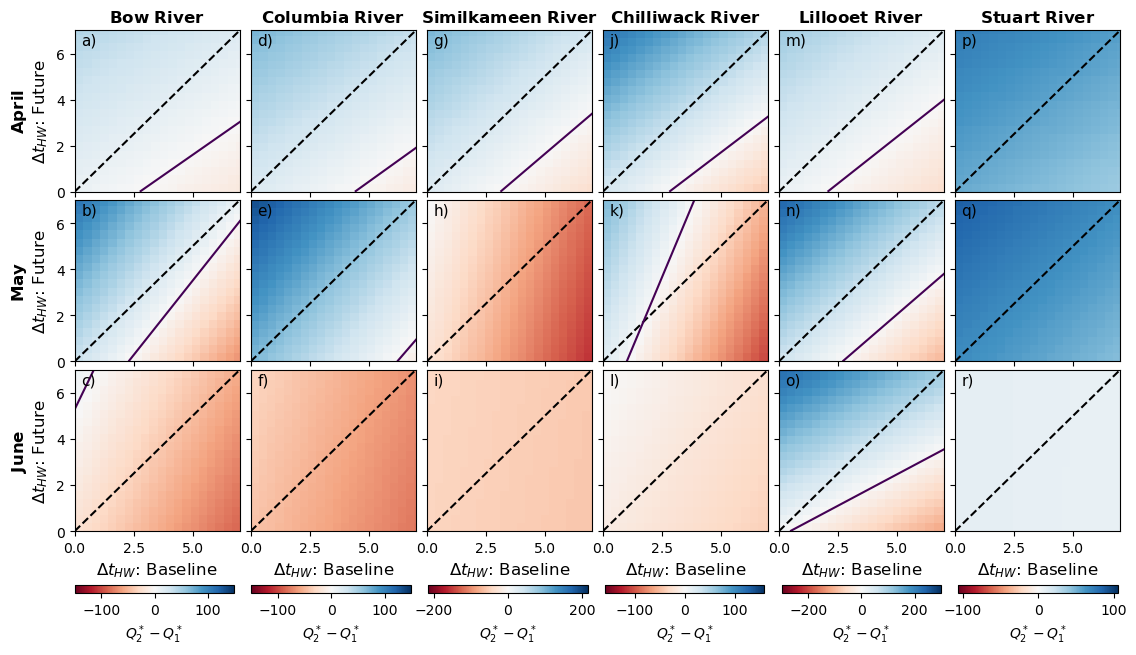

In [59]:
saveIt = 0

days = np.array([183, 213, 244])
Ndays = len(days)

labels = ['April', 'May', 'June']

nrows = Ndays
ncols = Nsites

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (1.9*ncols, 2*nrows))

jj = 0

for kk_site in range(Nsites):

    for kk_day in range(Ndays):
        
        ax = axes[kk_day, kk_site]

        kt = int(days[kk_day])
        xscale = Tmean_90_rolling[kk_site,kt] + 273
        extent = [min(x)/xscale, max(x)/xscale, min(y)/xscale, max(y)/xscale]

        var = np.mean(z[kk_site,:,:,kt:kt+30],axis = -1)
        vmax = np.max(np.abs(z[kk_site,:,:,days]))
        vmin = -vmax

        i = ax.imshow(var, aspect = 'auto', extent = extent, origin = 'lower', vmin = vmin, vmax = vmax, cmap = 'RdBu')

        ax.plot([0,xmax/xscale],[0,ymax/xscale], 'k--')
        ax.contour(x/xscale, y/xscale, var, levels = np.array([0]))

        ax.set_xlim(left = 0, right = 7)
        ax.set_ylim(bottom = 0, top = 7)

        year = '2019'
        if kt < 10:
            day_num = '0' + str((kt - 92)%365)
        else:
            day_num = str((kt - 92)%365)
            
        res = datetime.datetime.strptime(year + "-" + day_num, "%Y-%j").strftime("%B-%d-%Y")[:-5]
        ax.set_xlabel('$\Delta t_{HW}$: Baseline', fontsize = fs)

        if kk_day == Ndays-1: 
            #add colourbar to bottom subplot of each column
            cbar_ax = fig.add_axes([0.155*kk_site+0.07, -0., 0.14, 0.1])
            cbar_ax.axis('off')
            cb = fig.colorbar(i, ax=cbar_ax, orientation = 'horizontal')
            cb.ax.set_xlabel('$Q^*_2-Q^*_1$')           
        else:           
            #remove x-axis labels from all but the last row
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            
        if kk_site > 0:            
            #remove y-axis labels from all but the first column
            ax.set_yticklabels([])
            ax.set_ylabel(None)
        else:
            # ax.set_ylabel(r'$\bf{' + res + '}$\n$\Delta t_{HW}$: Future')
            ax.set_ylabel(r'$\bf{' + labels[kk_day] + '}$\n$\Delta t_{HW}$: Future', fontsize = fs)
        
        if kk_day == 0:
            #put river name in title of first row
            ax.set_title(r'$\bf{' + sites_short[kk_site][:-5] + '}$' + ' ' + r'$\bf{' + sites_short[kk_site][-5:] + '}$')
            
        ax.text(x = 0.04, y = 0.91, s = abc[jj], transform = ax.transAxes, fontsize = fs-1)
        jj+=1

plt.tight_layout(h_pad = -0, w_pad = 0.)

if saveIt:
    plt.savefig('Figures/Qstar_planes.png', dpi = 300, bbox_inches = 'tight')
    
plt.show()

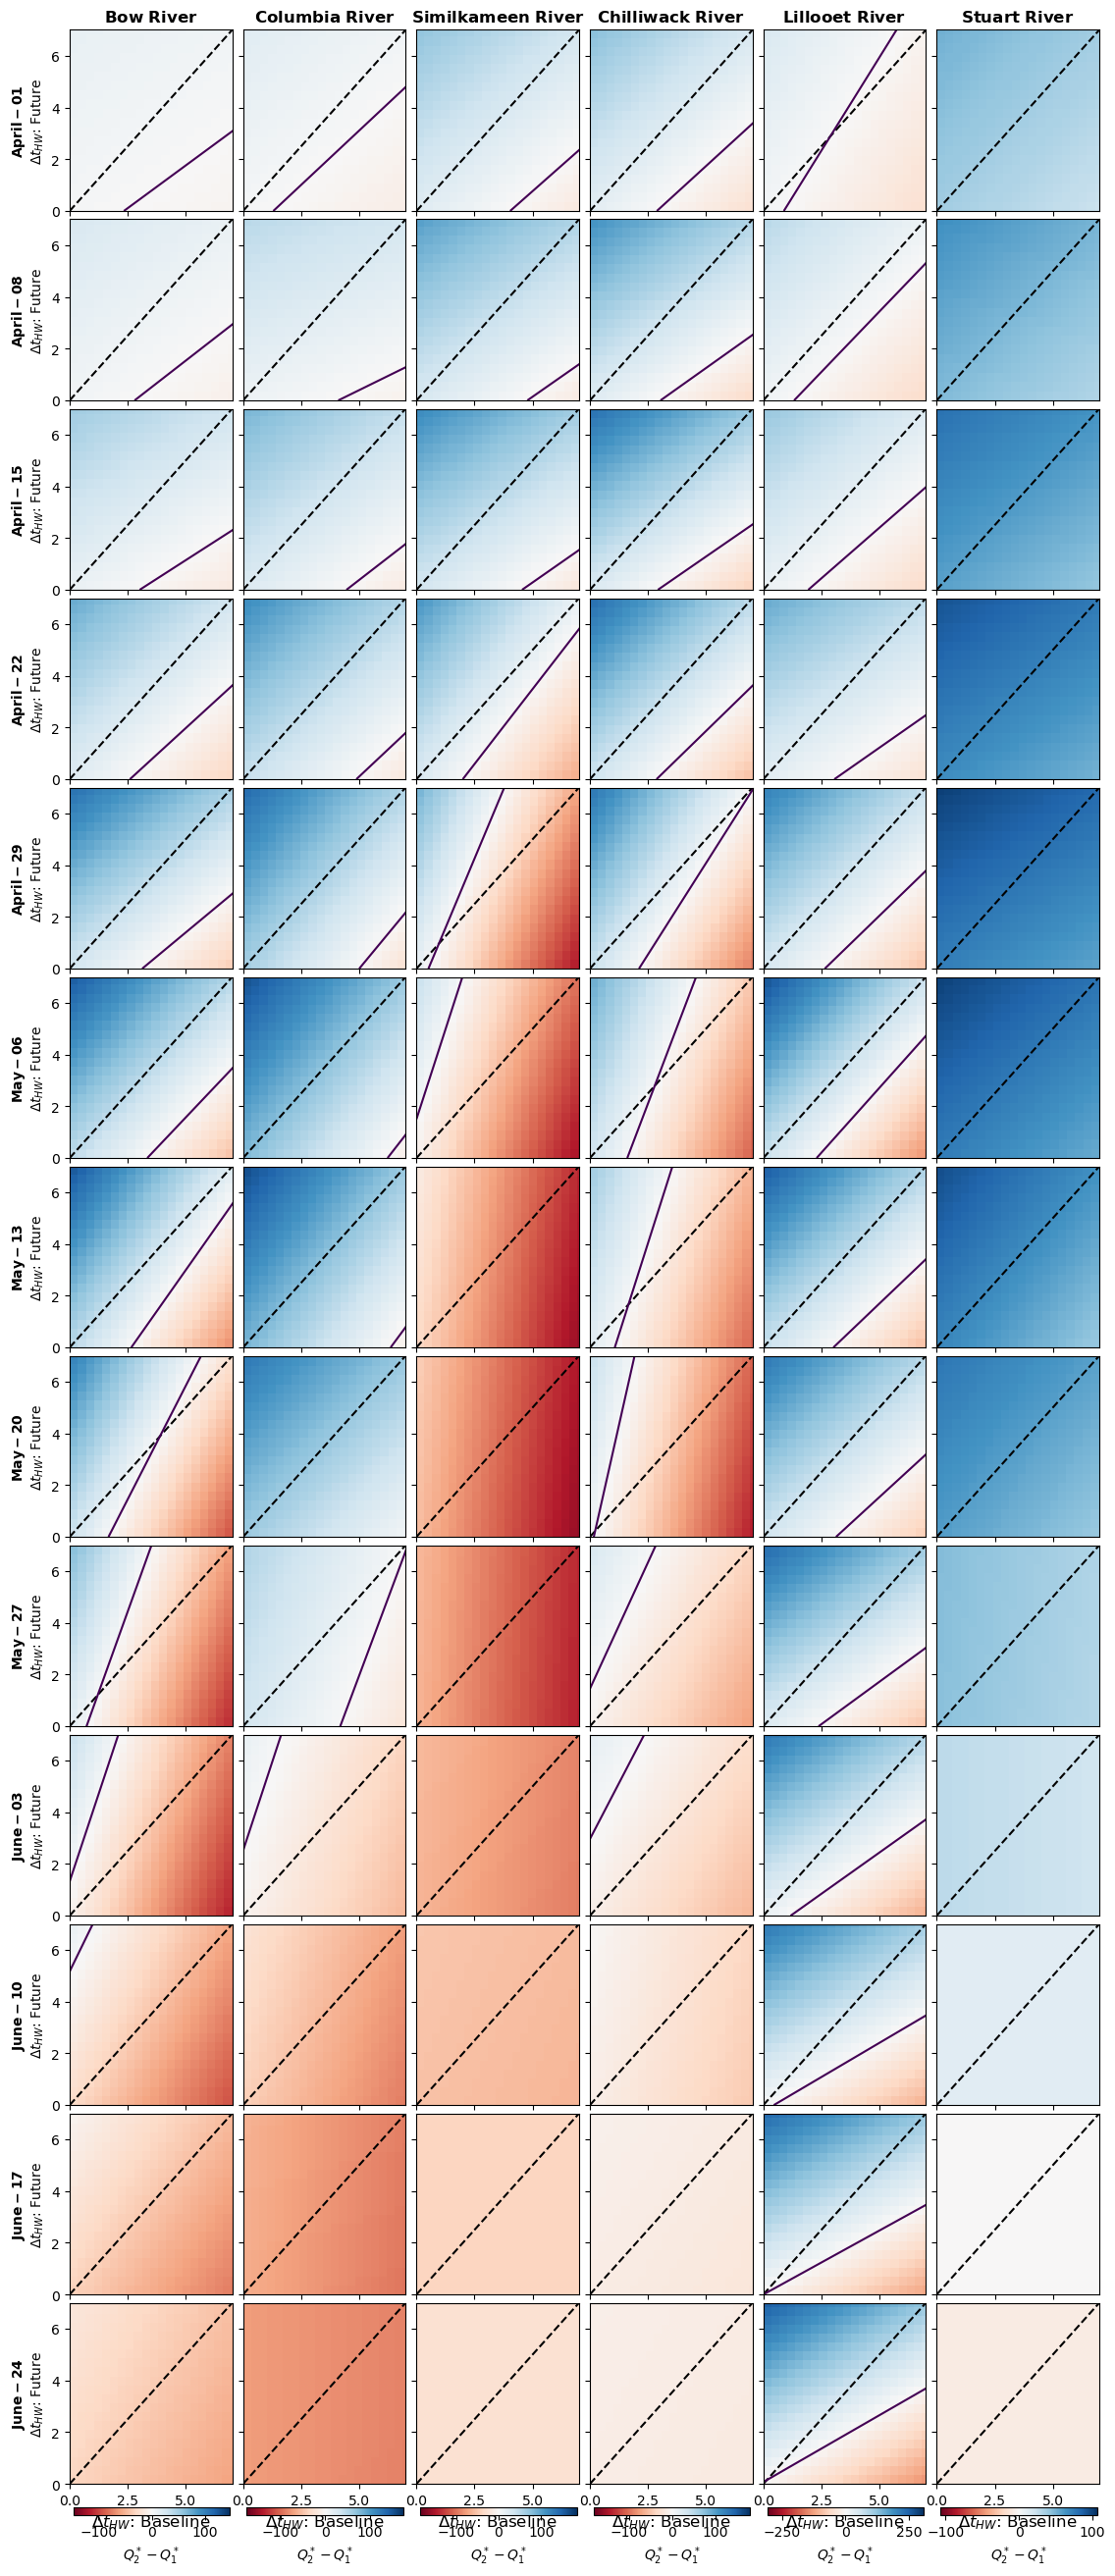

In [60]:
saveIt = 0

days = np.arange(183, 274, 7)
Ndays = len(days)

nrows = Ndays
ncols = Nsites

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (1.9*ncols, 2*nrows))

jj = 0

for kk_site in range(Nsites):

    for kk_day in range(Ndays):
        
        ax = axes[kk_day, kk_site]

        kt = int(days[kk_day])
        xscale = Tmean_90_rolling[kk_site,kt] + 273
        extent = [min(x)/xscale, max(x)/xscale, min(y)/xscale, max(y)/xscale]

        var = np.mean(z[kk_site,:,:,kt:kt+7],axis = -1)
        vmax = np.max(np.abs(z[kk_site,:,:,days]))
        vmin = -vmax

        i = ax.imshow(var, aspect = 'auto', extent = extent, origin = 'lower', vmin = vmin, vmax = vmax, cmap = 'RdBu')

        ax.plot([0,xmax/xscale],[0,ymax/xscale], 'k--')
        ax.contour(x/xscale, y/xscale, var, levels = np.array([0]))

        ax.set_xlim(left = 0, right = 7)
        ax.set_ylim(bottom = 0, top = 7)

        year = '2019'
        if kt < 10:
            day_num = '0' + str((kt - 92)%365)
        else:
            day_num = str((kt - 92)%365)
            
        res = datetime.datetime.strptime(year + "-" + day_num, "%Y-%j").strftime("%B-%d-%Y")[:-5]
        ax.set_xlabel('$\Delta t_{HW}$: Baseline', fontsize = fs)

        if kk_day == Ndays-1: 
            #add colourbar to bottom subplot of each column
            cbar_ax = fig.add_axes([0.155*kk_site+0.07, -0., 0.14, 0.1])
            cbar_ax.axis('off')
            cb = fig.colorbar(i, ax=cbar_ax, orientation = 'horizontal')
            cb.ax.set_xlabel('$Q^*_2-Q^*_1$')           
        else:           
            #remove x-axis labels from all but the last row
            ax.set_xticklabels([])
            ax.set_xlabel(None)
            
        if kk_site > 0:            
            #remove y-axis labels from all but the first column
            ax.set_yticklabels([])
            ax.set_ylabel(None)
        else:
            ax.set_ylabel(r'$\bf{' + res + '}$\n$\Delta t_{HW}$: Future')
        
        if kk_day == 0:
            #put river name in title of first row
            ax.set_title(r'$\bf{' + sites_short[kk_site][:-5] + '}$' + ' ' + r'$\bf{' + sites_short[kk_site][-5:] + '}$')
            
        jj+=1

plt.tight_layout(h_pad = -0, w_pad = 0.)

if saveIt:
    plt.savefig('Figures/Qstar_planes.png', dpi = 300, bbox_inches = 'tight')
    
plt.show()

# Supplementary 

In [61]:
def get_N_hws(df_sites, Nsites, sites, Nyears_sites, Tmean_90, P_running, freshet_day, years_future_proxy, years_baseline, P_threshold):
    
    #calculate:
    #when are heatwaves?
    #what are the qualities and meteorological characteristics of all heatwaves?

    hws = [[] for kk in range(Nsites)]
    Tmean_exceedance = []

    for kk_site, site in enumerate(sites):

        df_weather = df_sites['Weather_stations'][site]
        df_flow = df_sites['Streamflow'][site]
        Nyears = Nyears_sites[kk_site]
        data_start_year = df_sites['Year_start'][site]
        Q = df_flow['Value']
        Tmean = df_weather['Mean Temp (°C)']
        Tx = df_weather['Max Temp (°C)']
        Tn = df_weather['Min Temp (°C)']
        Ndays = len(Q)

        #temp exceedance and anomaly
        Tmean_90_4year = np.concatenate([Tmean_90[kk_site],Tmean_90[kk_site],Tmean_90[kk_site],np.array([Tmean_90[kk_site][-1]]),Tmean_90[kk_site]]) #3 normal years and 1 leap year in 1912
        Tmean_90_vector = np.tile(Tmean_90_4year,29)[:len(Q)]
        Tmean_exceedance.append(Tmean - Tmean_90_vector)

        inds_hotter_90 = np.argwhere([Tmean > Tmean_90_vector])[:,1]
        is_heatwave = np.zeros(Ndays)

        #determine the indices of all heatwave days in temperature record
        for kk,ind in enumerate(inds_hotter_90[2:]):
            if (inds_hotter_90[2:][kk-2]==ind-2) & (inds_hotter_90[2:][kk-1]==ind-1): #if prior two days were also >90th percentile
                if P_running[kk_site][ind] < P_threshold: #if less than 2mm rain the past 7 days
                    if (np.isnan(Q[ind]) == False) & (np.isnan(Q[ind-1]) == False) & (np.isnan(Q[ind-2]) == False): #if streamflow data is available
                        is_heatwave[ind] = 1
                        is_heatwave[ind-1] = 1
                        is_heatwave[ind-2] = 1
        inds_heatwave = np.argwhere(is_heatwave==1)

        #define heatwaves as events, defined by a start day and end day
        # hws = []

        jj_hw = 0
        hws[kk_site] = np.zeros([6000,2])
        hws[kk_site][0,0] = inds_heatwave[0]
        for kk, ind in enumerate(inds_heatwave[:-1]):
            if inds_heatwave[kk+1] != ind + 1: #if the next heatwave day is not the following day, it means we have reached the end of this heatwave
                hws[kk_site][jj_hw,1] = ind #final day of current heatwave is the present day
                hws[kk_site][jj_hw+1,0] = inds_heatwave[kk+1] #first day of next heatwave is the next heatwave day
                jj_hw+=1
        hws[kk_site] = hws[kk_site][:jj_hw-1,:] #clip final hw (end day of final hw is day 0)

    #hw stats
    Nhws = [len(hh) for hh in hws]
    t_hw = [np.zeros(nn) for nn in Nhws]  #timing (day of year)
    
    year_categories_hw = [np.zeros(nn) for nn in Nhws] #0: basic year; 1: baseline; 2: future proxy

    dQ_hw = [np.zeros(nn) for nn in Nhws] #change in streamflow (m3/s)
    dQdT_hw = [np.zeros(nn) for nn in Nhws]
    Qinit = [np.zeros(nn) for nn in Nhws]
    Qfinal = [np.zeros(nn) for nn in Nhws]

    Tmean_hw = [np.zeros(nn) for nn in Nhws]  #mean temp during heatwave (degrees)

    hw_year = [np.zeros(nn) for nn in Nhws]
    hw_month = [np.zeros(nn) for nn in Nhws]

    future_proxy_hw = [np.zeros(nn) for nn in Nhws]
    baseline_hw = [np.zeros(nn) for nn in Nhws]
    freshet_day_hw = [np.zeros(nn) for nn in Nhws]

    inds_future_proxy_hw = []
    inds_baseline_hw = []

    for kk_site, site in enumerate(sites):

        Ndays = len(Q)
        df_weather =  df_sites['Weather_stations'][site]
        data_start_year = df_sites['Year_start'][site] + 1

        for kk_hw in range(Nhws[kk_site]):

            day_start = int(hws[kk_site][kk_hw][0])
            day_final = int(hws[kk_site][kk_hw][1])

            t_hw[kk_site][kk_hw] = df_weather['Day_of_year'][day_start] #day of year
            hw_year[kk_site][kk_hw] = int(df_weather.iloc[day_start]['Year'])
            hw_month[kk_site][kk_hw] = df_weather.index[day_start].month

        #freshet stuff
        for kk_hw, year in enumerate(hw_year[kk_site]-data_start_year):
            if year < Nyears_sites[kk_site]-1:
                if year > -1:
                    freshet_day_hw[kk_site][kk_hw] = freshet_day[kk_site][int(year)]
                if np.size(np.argwhere(year==years_future_proxy[kk_site]))>0:
                    future_proxy_hw[kk_site][kk_hw] = 1
                elif np.size(np.argwhere(year==years_baseline[kk_site]))>0:
                    baseline_hw[kk_site][kk_hw] = 1

        inds_future_proxy_hw.append(np.argwhere(future_proxy_hw[kk_site] == 1).squeeze())
        inds_baseline_hw.append(np.argwhere(baseline_hw[kk_site] == 1).squeeze())

    N_future_proxy_hw = np.zeros((Nsites,335))
    N_baseline_hw = np.zeros((Nsites,335))

    bin_width = 30

    for kk_site, site in enumerate(sites):

        for day_start in range(0,335):

            inds_bin_future_proxy = np.argwhere(
                (t_hw[kk_site][inds_future_proxy_hw[kk_site]] >= day_start) & 
                (t_hw[kk_site][inds_future_proxy_hw[kk_site]] < day_start + bin_width)
            ).squeeze()

            inds_bin_baseline = np.argwhere(
                (t_hw[kk_site][inds_baseline_hw[kk_site]] >= day_start) & 
                (t_hw[kk_site][inds_baseline_hw[kk_site]] < day_start + bin_width)
            ).squeeze()

            N_future_proxy_hw[kk_site,day_start] = np.size(inds_bin_future_proxy)
            N_baseline_hw[kk_site,day_start] = np.size(inds_bin_baseline)
    
    return N_future_proxy_hw, N_baseline_hw

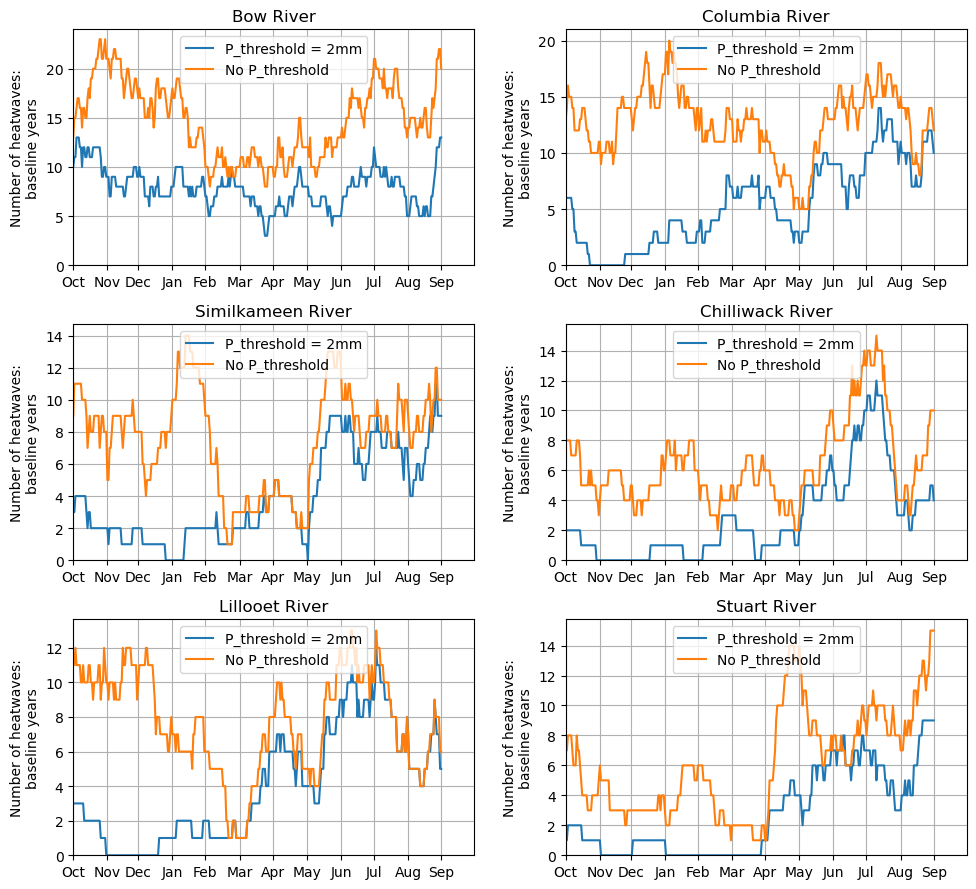

In [62]:
#NUMBER HEATWAVES AS A FUNCTION OF PRECIP THRESHOLD

saveIt = 0

P_thresholds = np.array([2,200])
N_P = len(P_thresholds)
N_baseline_hw = np.zeros((Nsites,335,N_P))

for kk_P, P_threshold in enumerate(P_thresholds):
    N_future_proxy_hw, N_baseline_hw[:,:,kk_P] = get_N_hws(df_sites, Nsites, sites, Nyears_sites, Tmean_90, P_running, freshet_day, years_future_proxy, years_baseline, P_threshold)
    
nrows = 3
ncols = 2

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 3*nrows))

labels = ['P_threshold = ' + str(P_thresholds[0]) + 'mm',
          'No P_threshold']

for kk_site, ax in enumerate(axes.flatten()[:Nsites]):
    
    for kk_P, P_threshold in enumerate(P_thresholds):
        ax.plot(N_baseline_hw[kk_site,:,kk_P], label = labels[kk_P])
    ax.set_title(sites_short[kk_site])
    ax.legend(loc = 'upper center')
    ax.set_ylabel('Number of heatwaves:\nbaseline years')

for ax in axes.flatten():
    ax.set_xlim(left = 0,right = 364)
    ax.set_ylim(bottom = 0)
    ax.grid(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0)
    
plt.tight_layout()

if saveIt:
    plt.savefig('Figures/Supplementary/N_hws_precip.png', dpi = 300, bbox_inches = 'tight')

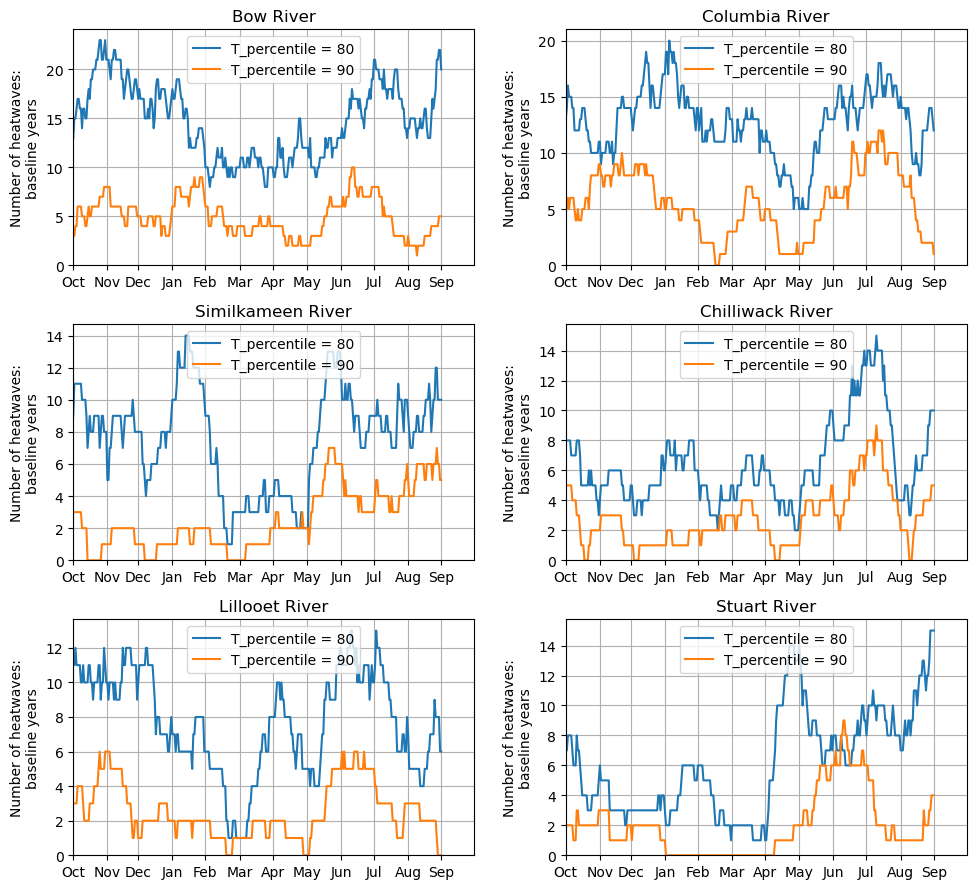

In [63]:
#NUMBER HEATWAVES AS A FUNCTION OF TEMPERATURE PERCENTILE

saveIt = 0

P_threshold = 200
T_percentile_thresholds = np.array([80,90])
N_T = len(T_percentile_thresholds)
N_baseline_hw = np.zeros((Nsites,335,N_T))

#calculate number of events for rolling 30-day windows
for kk_T, T_percentile_threshold in enumerate(T_percentile_thresholds):
    
    #calculate rolling temperature percentile threshold
    Tmean_p = np.zeros((Nsites,365))

    #loop through each site
    for kk_site, site in enumerate(sites):
        df_weather = df_sites['Weather_stations'][site]
        Tmean = df_weather['Mean Temp (°C)']
        for day in range(365):
            if day<7:
                day_range = np.concatenate([np.arange(365 + day - 7,365), np.arange(0, day + 8)])
            elif day + 7 >= 365:
                day_range = np.concatenate([np.arange(day - 7, 365), np.arange(0, 7 - (364 - day))])
            else:
                day_range = np.arange(day - 7, day + 8)
            Tmean_range = []
            for kk, dd in enumerate(day_range):
                Tmean_range.extend(Tmean[df_weather['Day_of_year'] == dd].values)
            Tmean_p[kk_site,day] = np.nanpercentile(Tmean_range, q = T_percentile_threshold)
    
    N_future_proxy_hw, N_baseline_hw[:,:,kk_T] = get_N_hws(df_sites, Nsites, sites, Nyears_sites, Tmean_p, P_running, freshet_day, years_future_proxy, years_baseline, P_threshold)
 
#visualize
nrows = 3
ncols = 2

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 3*nrows))

labels = ['T_percentile = ' + str(tt) for tt in T_percentile_thresholds]

for kk_site, ax in enumerate(axes.flatten()[:Nsites]):
    
    for kk_T, T_threshold in enumerate(T_percentile_thresholds):
        ax.plot(N_baseline_hw[kk_site,:,kk_T], label = labels[kk_T])
    ax.set_title(sites_short[kk_site])
    ax.legend(loc = 'upper center')
    ax.set_ylabel('Number of heatwaves:\nbaseline years')

for ax in axes.flatten():
    ax.set_xlim(left = 0,right = 364)
    ax.set_ylim(bottom = 0)
    ax.grid(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0)
  
plt.tight_layout()

if saveIt:
    plt.savefig('Figures/Supplementary/N_hws_T_threshold.png', dpi = 300, bbox_inches = 'tight')

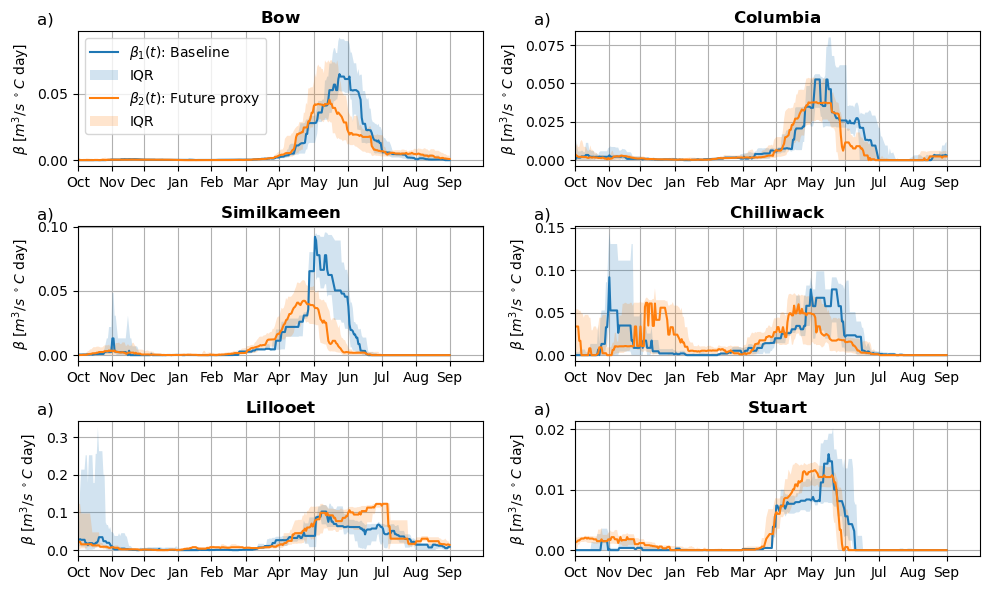

In [64]:
#beta for future proxy and baseline: 90th percentile temp threshold instead of 80th

saveIt = 0

fs = 12

kk_site = 0

nrows = 3
ncols = 2

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 2*nrows))

for kk_site, ax in enumerate(axes.flatten()):

    ax.plot(dQdT_rolling_baseline[kk_site], label = '$\u03B2_1(t)$: Baseline')
    ax.fill_between(x = np.arange(335), y1 = dQdT_rolling_baseline_p1[kk_site], y2 = dQdT_rolling_baseline_p2[kk_site], alpha = 0.2, label = 'IQR')
    ax.plot(dQdT_rolling_future_proxy[kk_site], label = '$\u03B2_2(t)$: Future proxy')
    ax.fill_between(x = np.arange(335), y1 = dQdT_rolling_future_proxy_p1[kk_site], y2 = dQdT_rolling_future_proxy_p2[kk_site], alpha = 0.2, label = 'IQR')
    ax.set_ylabel('$\u03B2$ [$m^3 / s$ $^\circ C$ day]')
    ax.set_title(r'$\bf{' + sites_short[kk_site][:-5] + '}$')
    if kk_site == 0:
        ax.legend(loc = 'upper left')
    ax.text(x = -0.1, y = 1.05, s = abc[0], transform = ax.transAxes, fontsize = fs)


for ax in axes.flatten():
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0)
    
plt.tight_layout()

if saveIt:
    plt.savefig('Figures/Supplementary/dQdTdt_all_sites.png', dpi = 300, bbox_inches = 'tight')

plt.show()

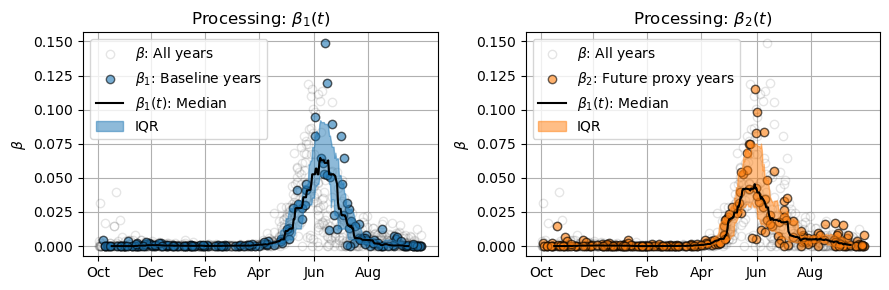

In [66]:
#figure showing preprocessing -- individual betas --> median + shading

saveIt = 0

kk_site = 0

nrows = 1
ncols = 2

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4.5*ncols, 3*nrows))

##### BASELINE
ax = axes[0]

#ALL YEARS
x = t_hw[kk_site]
y = dQdT_hw[kk_site]
ax.scatter(x, y, edgecolor = 'k', facecolor = 'w', alpha = 0.1, label = '$\u03B2$: All years')

#BASELINE YEARS
inds = np.argwhere(year_categories_hw[kk_site]==1).squeeze() #baseline
x = t_hw[kk_site][inds]
y = dQdT_hw[kk_site][inds]
ax.scatter(x, y, edgecolor = 'k', alpha = 0.6, label = '$\u03B2_1$: Baseline years')
ax.plot(np.arange(335)+15, dQdT_rolling_baseline[kk_site], 'k', label = '$\u03B2 _1(t)$: Median')
ax.fill_between(x = np.arange(335)+15, y1 = dQdT_rolling_baseline_p1[kk_site], y2 = dQdT_rolling_baseline_p2[kk_site], alpha = 0.5, color='#1f77b4', label = 'IQR')
ax.set_title('Processing: $\u03B2_1(t)$')

##### FUTURE PROXY
ax = axes[1]

#ALL YEARS
x = t_hw[kk_site]
y = dQdT_hw[kk_site]
ax.scatter(x, y, edgecolor = 'k', facecolor = 'w', alpha = 0.1, label = '$\u03B2$: All years')

#FUTURE PROXY YEARS
inds = np.argwhere(year_categories_hw[kk_site]==2).squeeze() #baseline
x = t_hw[kk_site][inds]
y = dQdT_hw[kk_site][inds]
ax.scatter(x, y, edgecolor = 'k', alpha = 0.6, label = '$\u03B2_2$: Future proxy years', color = '#ff7f0e')
ax.plot(np.arange(335)+15, dQdT_rolling_future_proxy[kk_site], 'k', label = '$\u03B2 _1(t)$: Median')
ax.fill_between(x = np.arange(335)+15, y1 = dQdT_rolling_future_proxy_p1[kk_site], y2 = dQdT_rolling_future_proxy_p2[kk_site], alpha = 0.5, color = '#ff7f0e', label = 'IQR')
ax.set_title('Processing: $\u03B2_2(t)$')

#FIGURE DETAILS
for ax in axes:
    ax.set_ylabel('$\u03B2$')
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.set_xticks(first_days_of_month[::2])
    ax.set_xticklabels(months_str[::2], rotation = 0)
    ax.legend()

plt.tight_layout()
    
if saveIt:
    plt.savefig('Figures/Supplementary/processing.png', bbox_inches = 'tight', dpi = 300)
    
plt.show()

In [ ]:
#consider: fall/winter heatwave response by early-season snowfall

site = 'Chilliwack'
kk_site = sites.index(site)

hw_year_site = hw_year[kk_site]

Psnow_dec1 = [np.zeros(nn) for nn in Nyears_sites]
years_snowy = [None for kk in range(Nsites)]
years_dry = [None for kk in range(Nsites)]

for kk_site in range(Nsites):

    Psnow_dec1[kk_site] = Psnowcumulative[kk_site][:,61]
    years_snowy[kk_site] = np.argwhere(Psnow_dec1[kk_site] > 0).squeeze()
    years_dry[kk_site] = np.argwhere(Psnow_dec1[kk_site] == 0).squeeze()

In [ ]:
kk_site = 3

nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 3*nrows))

for ax in axes.flatten():
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0)

for year in range (101):
    
    #color by year
    color = matplotlib.cm.get_cmap('viridis')(year / 112)
    axes[0,0].plot(Qyearly[kk_site][year,:], color = color, linewidth = 0.5)
    
    #color by freshet timing
    vmax = np.nanmax(Psnow_dec1[kk_site])
    vmin = np.nanmin(Psnow_dec1[kk_site])
    color = matplotlib.cm.get_cmap('viridis')( (Psnow_dec1[kk_site][year] - vmin)/(vmax-vmin) )
    axes[0,1].plot(Qyearly[kk_site][year,:], color = color, linewidth = 0.5, zorder = freshet_day[kk_site][year])
    
    #plot only earliest and latest freshet years
    if np.size(np.argwhere(year == years_dry[kk_site]).squeeze()) > 0:
        axes[1,0].plot(Qyearly_filled[kk_site][year,:], color = 'k', linewidth = 1)
        
    if np.size(np.argwhere(year == years_snowy[kk_site]).squeeze()) > 0:
        axes[1,0].plot(Qyearly_filled[kk_site][year,:], color = 'gray', linewidth = 1)
        
axes[1,0].set_xlim(left = 190,right = 290)

axes[0,0].set_title('Streamflow: Color by year')
axes[0,1].set_title('Streamflow: Color by freshet timing')
axes[1,0].set_title('Streamflow: Baseline and future proxy years')
axes[1,1].set_title('Streamflow: Mean baseline and future proxy years')
        
#plot average of early and late freshet years
axes[1,1].plot(np.nanmedian(Qyearly[kk_site][years_dry[kk_site],:],axis = 0))
axes[1,1].plot(np.nanmedian(Qyearly[kk_site][years_snowy[kk_site],:],axis = 0))


p1 = 16#25
p2 = 84#75
p1 = 25
p2 = 75
y1 = np.percentile(Qyearly[kk_site][years_dry[kk_site],:], q = p1, axis = 0)
y2 = np.percentile(Qyearly[kk_site][years_dry[kk_site],:], q = p2, axis = 0)
y3 = np.percentile(Qyearly[kk_site][years_snowy[kk_site],:], q = p1, axis = 0)
y4 = np.percentile(Qyearly[kk_site][years_snowy[kk_site],:], q = p2, axis = 0)
axes[1,1].fill_between(x = np.arange(365), y1 = y1, y2 = y2, alpha = 0.3)
axes[1,1].fill_between(x = np.arange(365), y1 = y3, y2 = y4, alpha = 0.3)

# axes[1,1].plot(np.nanmedian(Qyearly[years_mid_freshet,:],axis = 0),'k')

plt.tight_layout()
plt.show()

In [ ]:
dQdT_rolling_dry = np.zeros((Nsites,335))
dQdT_rolling_dry_p1 = np.zeros((Nsites,335))
dQdT_rolling_dry_p2 = np.zeros((Nsites,335))
dQdT_rolling_dry_std = np.zeros((Nsites,335))

dQdT_rolling_snowy = np.zeros((Nsites,335))
dQdT_rolling_snowy_p1 = np.zeros((Nsites,335))
dQdT_rolling_snowy_p2 = np.zeros((Nsites,335))
dQdT_rolling_snowy_std = np.zeros((Nsites,335))

Q_dry_rolling = np.zeros((Nsites,335))
Q_snowy_rolling = np.zeros((Nsites,335))
Q_diff_freshet_rolling = np.zeros((Nsites,335))

N_dry_hw = np.zeros((Nsites,335))
N_snowy_hw = np.zeros((Nsites,335))

bin_width = 30

for kk_site, site in enumerate(sites):

    for day_start in range(0,335):

        inds_bin_dry = np.argwhere(
            (t_hw[kk_site][inds_dry_hw[kk_site]] >= day_start) & 
            (t_hw[kk_site][inds_dry_hw[kk_site]] < day_start + bin_width)
        ).squeeze()

        inds_bin_snowy = np.argwhere(
            (t_hw[kk_site][inds_snowy_hw[kk_site]] >= day_start) & 
            (t_hw[kk_site][inds_snowy_hw[kk_site]] < day_start + bin_width)
        ).squeeze()

        N_dry_hw[kk_site,day_start] = np.size(inds_bin_dry)
        N_snowy_hw[kk_site,day_start] = np.size(inds_bin_snowy)

        if N_dry_hw[kk_site,day_start] > 0:
            dQdT_rolling_dry[kk_site,day_start] = np.median(dQdT_hw[kk_site][inds_dry_hw[kk_site]][inds_bin_dry])
            dQdT_rolling_dry_p1[kk_site,day_start] = np.percentile(dQdT_hw[kk_site][inds_dry_hw[kk_site]][inds_bin_dry], q = 25)
            dQdT_rolling_dry_p2[kk_site,day_start] = np.percentile(dQdT_hw[kk_site][inds_dry_hw[kk_site]][inds_bin_dry], q = 75)
            dQdT_rolling_dry_std[kk_site,day_start] = np.std(dQdT_hw[kk_site][inds_dry_hw[kk_site]][inds_bin_dry])
        else:    
            dQdT_rolling_dry[kk_site,day_start] = np.nan
            dQdT_rolling_dry_p1[kk_site,day_start] = np.nan
            dQdT_rolling_dry_p2[kk_site,day_start] = np.nan
            dQdT_rolling_dry_std[kk_site,day_start] = np.nan

        if N_snowy_hw[kk_site,day_start] > 0:
            dQdT_rolling_snowy[kk_site,day_start] = np.median(dQdT_hw[kk_site][inds_snowy_hw[kk_site]][inds_bin_snowy])
            dQdT_rolling_snowy_p1[kk_site,day_start] = np.percentile(dQdT_hw[kk_site][inds_snowy_hw[kk_site]][inds_bin_snowy], q = 25)
            dQdT_rolling_snowy_p2[kk_site,day_start] = np.percentile(dQdT_hw[kk_site][inds_snowy_hw[kk_site]][inds_bin_snowy], q = 75)
            dQdT_rolling_snowy_std[kk_site,day_start] = np.std(dQdT_hw[kk_site][inds_snowy_hw[kk_site]][inds_bin_snowy])
        else:
            dQdT_rolling_snowy[kk_site,day_start] = np.nan
            dQdT_rolling_snowy_p1[kk_site,day_start] = np.nan
            dQdT_rolling_snowy_p2[kk_site,day_start] = np.nan
            dQdT_rolling_snowy_std[kk_site,day_start] = np.nan

        Q_dry_rolling[kk_site,day_start] = np.mean(Q_dry[kk_site,day_start : day_start + bin_width])
        Q_snowy_rolling[kk_site,day_start] = np.mean(Q_snowy[kk_site,day_start : day_start + bin_width])
        Q_diff_freshet_rolling[kk_site,day_start] = np.mean(Q_diff_freshet[kk_site,day_start : day_start + bin_width])
        # Q_diff_freshet_rolling[day_start] = np.mean(Q_diff_freshet[day_start : day_start + bin_width])

    dQdT_diff_rolling = dQdT_rolling_dry - dQdT_rolling_snowy

In [ ]:
nrows = 3
ncols = 2

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 3*nrows))

for kk_site, ax in enumerate(axes.flatten()[:Nsites]):
    ax.plot(N_dry_hw[kk_site], label = 'Dry')
    ax.plot(N_snowy_hw[kk_site], label = 'Snowy')
    ax.set_title(sites[kk_site])
    ax.legend()
    ax.set_ylabel('Number of heatwaves')
    
for ax in axes.flatten():
    ax.set_xlim(left = 0,right = 364)
    ax.set_ylim(bottom = 0)
    ax.grid(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0)
    
plt.tight_layout()

In [ ]:
saveIt = 0

fs = 12

kk_site = 0

nrows = 3
ncols = 2

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 2*nrows))

for kk_site, ax in enumerate(axes.flatten()):

    ax.plot(dQdT_rolling_snowy[kk_site], label = '$\u03B2_1(t)$: Snowy')
    ax.fill_between(x = np.arange(335), y1 = dQdT_rolling_snowy_p1[kk_site], y2 = dQdT_rolling_snowy_p2[kk_site], alpha = 0.2, label = 'IQR')
    ax.plot(dQdT_rolling_dry[kk_site], label = '$\u03B2_2(t)$: Dry')
    ax.fill_between(x = np.arange(335), y1 = dQdT_rolling_dry_p1[kk_site], y2 = dQdT_rolling_dry_p2[kk_site], alpha = 0.2, label = 'IQR')
    ax.set_ylabel('$\u03B2$ [$m^3 / s$ $^\circ C$ day]')
    ax.set_title(r'$\bf{' + sites_short[kk_site][:-5] + '}$')
    if kk_site == 0:
        ax.legend(loc = 'upper left')
    ax.text(x = -0.1, y = 1.05, s = abc[0], transform = ax.transAxes, fontsize = fs)


for ax in axes.flatten():
    ax.set_xlim(left = 0,right = 364)
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.set_xticks(first_days_of_month)
    ax.set_xticklabels(months_str, rotation = 0)
    
plt.tight_layout()

if saveIt:
    plt.savefig('Figures/Supplementary/dQdTdt_all_sites.png', dpi = 300, bbox_inches = 'tight')

plt.show()